In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
from scipy.interpolate import RectBivariateSpline
import numpy as np

In [3]:
import sys
sys.path.append("..")

In [4]:
from vaneska.interpolate import ScipyRectBivariateSpline

/Users/ozymandias1/anaconda2/envs/python3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [5]:
from lightkurve import KeplerTargetPixelFile

In [6]:
import tensorflow as tf

In [7]:
from vaneska.models import KeplerPRF

In [8]:
tpf = KeplerTargetPixelFile.from_archive('kepler-10b', quarter=5)

INFO: Found cached file ./mastDownload/Kepler/kplr011904151_lc_Q111111110111011101/kplr011904151-2010174085026_lpd-targ.fits.gz with expected size 4685387. [astroquery.query]


In [9]:
tpf.plot()

In [10]:
tpf.shape

(4492, 8, 7)

In [83]:
prf = KeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row, npix=8, ss_factor=10)

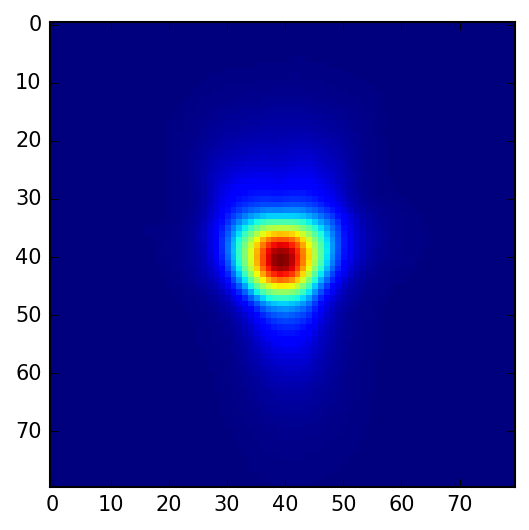

In [84]:
np.shape(prf.supersampled_prf)

plt.imshow(prf.supersampled_prf, interpolation='nearest')
plt.show()

In [85]:
flux0 = np.nansum(tpf.flux[0])
xc0, yc0 = tpf.centroids()[0][0], tpf.centroids()[1][0]
bkg0 = np.nanmean(tpf.flux_bkg[0])

In [86]:
flux = tf.Variable(flux0, dtype=tf.float64)
xc = tf.Variable(xc0, dtype=tf.float64)
yc = tf.Variable(yc0, dtype=tf.float64)
bkg = tf.Variable(bkg0, dtype=tf.float64)

In [87]:
var_list = [flux, xc, yc, bkg]

In [88]:
model = prf(flux, xc, yc) + bkg

In [89]:
model

<tf.Tensor 'add_3:0' shape=<unknown> dtype=float64>

In [90]:
sess = tf.Session()

In [91]:
sess.run(tf.global_variables_initializer())

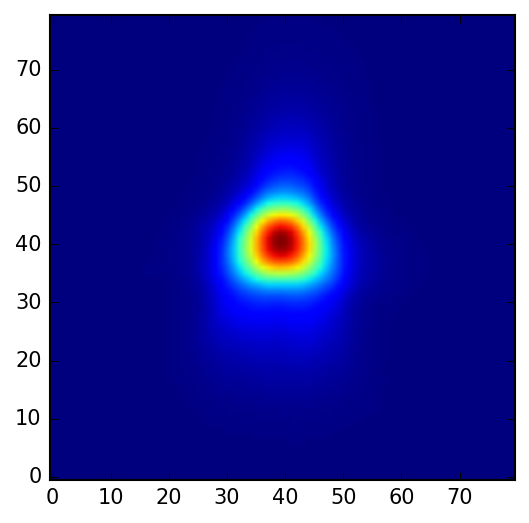

In [92]:
plt.imshow(prf.supersampled_prf, origin='lower')

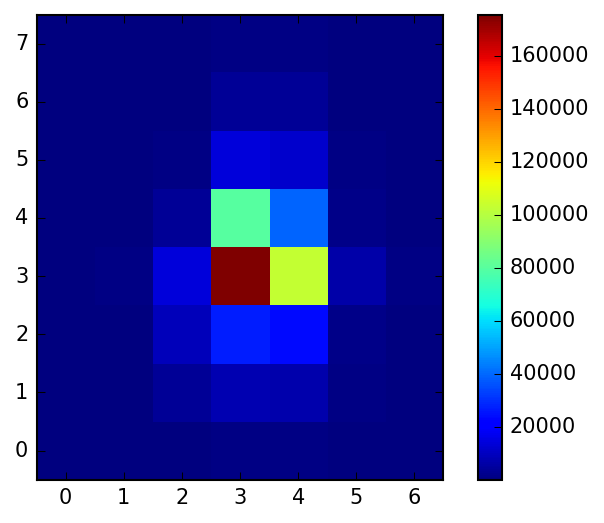

In [93]:
plt.imshow(sess.run(model), origin='lower', interpolation='nearest')
plt.colorbar()

In [94]:
data = tf.placeholder(dtype=tf.float64, shape=tpf.flux[0].shape)

In [95]:
loss = tf.reduce_sum(tf.subtract(model, tf.multiply(data, tf.log(model))))

In [96]:
grad = tf.gradients(loss, var_list)

In [97]:
sess.run(grad, feed_dict={data:tpf.flux[0] + tpf.flux_bkg[0]})

[0.0044475438186056095,
 -44269.86760742744,
 5975.697319870256,
 -5.219284902837343]

In [98]:
sess.run(loss, feed_dict={data:tpf.flux[-1] + tpf.flux_bkg[-1]})

-5427784.969858378

In [99]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss, var_list, method='BFGS')

In [100]:
import tqdm

In [ ]:
psf_flux = []
psf_xc = []
psf_yc = []
psf_bkg = []
for n in tqdm.tqdm(range(len(tpf.time))):
    optimizer.minimize(session=sess, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]})
    psf_flux.append(sess.run(flux))
    psf_xc.append(sess.run(xc))
    psf_yc.append(sess.run(yc))
    psf_bkg.append(sess.run(bkg))
    print(sess.run(grad, feed_dict={data:tpf.flux[n] + tpf.flux_bkg[n]}))


  0%|          | 0/4492 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511129.200226
  Number of iterations: 38
  Number of functions evaluations: 46



  0%|          | 1/4492 [00:00<21:22,  3.50it/s]

[4.230087807810534e-11, 0.00010023306845141633, -3.7565952879958786e-05, 8.470767198787144e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5510940.942151
  Number of iterations: 12
  Number of functions evaluations: 16
[1.003644965365258e-06, -1.555872404424008e-05, -1.4913730410626158e-06, 1.0463772259772242e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511404.038329
  Number of iterations: 35
  Number of functions evaluations: 121



  0%|          | 3/4492 [00:00<16:28,  4.54it/s]

[-1.0365075985008243e-10, -3.256380227867339e-05, -5.194306140765548e-07, -1.9703130793580215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511851.050315
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.0484383326792024e-11, -1.63991921908746e-06, 9.381492418469861e-07, 1.5963181887457267e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512002.704763
  Number of iterations: 13
  Number of functions evaluations: 18



  0%|          | 5/4492 [00:00<12:55,  5.78it/s]

[2.9100518459815664e-06, 7.541593276982894e-05, -1.1005333362845704e-05, -5.5442183399811995e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511785.667918
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.5600897476783157e-06, 0.0005271240827369184, -0.0003352619260112988, -4.466437786287969e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511894.477759
  Number of iterations: 10
  Number of functions evaluations: 63



  0%|          | 7/4492 [00:00<10:39,  7.01it/s]

[2.245590483454605e-05, -0.0007844783508517139, -0.0006685786393063609, 1.138128144506645e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511998.895151
  Number of iterations: 24
  Number of functions evaluations: 33
[-2.4881453668246234e-11, 0.0003058135298488196, 0.00046365173875528853, 1.6457815210646487e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512303.827159
  Number of iterations: 8
  Number of functions evaluations: 12
[5.040841830706265e-06, -0.0006855793626527884, 0.0004872344343311852, 2.5318523055872788e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512086.896216
  Number of iterations: 10
  Number of functions evaluations: 14



  0%|          | 10/4492 [00:00<08:24,  8.89it/s]

[-2.025170664485265e-06, 0.00021474382970154693, -9.988089550461154e-05, -6.379745176587903e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511302.441852
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.343168714613597e-11, 0.00031521150435764866, -0.00031448436857317574, -3.136474585607729e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512771.566961
  Number of iterations: 35
  Number of functions evaluations: 41



  0%|          | 12/4492 [00:00<07:41,  9.71it/s]

[-6.665572521019625e-11, 1.045475983119104e-06, -8.108632755465806e-06, 1.2078055888764538e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5511783.323615
  Number of iterations: 31
  Number of functions evaluations: 39
[7.295174880850297e-12, 5.712484380637761e-06, 2.632114046718925e-07, -8.290612640848849e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511589.603304
  Number of iterations: 37
  Number of functions evaluations: 42



  0%|          | 14/4492 [00:01<06:53, 10.83it/s]

[1.4436822830948826e-10, -2.985088076457032e-05, -4.85050659335684e-05, 3.037136864225687e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5508158.684019
  Number of iterations: 35
  Number of functions evaluations: 43
[-7.217454932317846e-12, -2.288360747115803e-05, -3.8456544643850066e-05, -9.171441613942122e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512204.749898
  Number of iterations: 36
  Number of functions evaluations: 40



  0%|          | 16/4492 [00:01<06:27, 11.55it/s]

[-5.215491823140628e-10, 0.0002989109304962767, 0.0003186176199960755, -4.1721276544670616e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512755.745039
  Number of iterations: 31
  Number of functions evaluations: 88
[4.809733330363164e-09, 0.002226055356231882, -0.0002840003198798513, -2.6130625851994438e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513267.115520
  Number of iterations: 11
  Number of functions evaluations: 15



  0%|          | 18/4492 [00:01<06:18, 11.83it/s]

[-3.851870046404655e-05, -0.0028092061770621513, -0.0021492891100933775, -2.32895323015736e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512954.497152
  Number of iterations: 33
  Number of functions evaluations: 77
[-5.419018098834494e-11, -0.0004049400465646613, 0.00033407936098228674, -2.051427483440449e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512696.349659
  Number of iterations: 34
  Number of functions evaluations: 38



  0%|          | 20/4492 [00:01<05:59, 12.45it/s]

[4.1225321767424106e-11, -1.302707892136823e-05, 7.362079486483708e-06, -2.4322881819749398e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512866.225149
  Number of iterations: 12
  Number of functions evaluations: 70
[-3.103036460669513e-06, -0.003961107745908521, 0.0009993781914090505, 8.635193337047653e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512794.266434
  Number of iterations: 13
  Number of functions evaluations: 17
[-4.961406193745681e-06, -0.002227063087048009, 0.00019269705808255821, 6.65994742576892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5511991.447702
  Number of iterations: 35
  Number of functions evaluations: 97



  1%|          | 23/4492 [00:01<05:15, 14.19it/s]

[-1.4491269685959485e-09, 0.0021380677535489667, -0.0002624763201310998, -1.7854052883903293e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512501.242312
  Number of iterations: 36
  Number of functions evaluations: 39
[-4.782843999323605e-11, 3.7941947539366083e-06, 2.6012512535089627e-06, -8.402600726320486e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5512520.260090
  Number of iterations: 9
  Number of functions evaluations: 75
[-1.0759226280029378e-05, 0.00029384484264483035, -4.058960439579096e-05, 1.404818953387732e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513473.276897
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.101641811969035e-10, 0.00011429507731008925, -4.0058130252873525e-05, -4.367257910864453e-08]



  1%|          | 26/4492 [00:01<04:39, 15.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513291.518505
  Number of iterations: 28
  Number of functions evaluations: 35
[4.076735476976623e-11, -1.665240870352136e-05, 1.1328404070809484e-05, 7.194918327790845e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513603.772594
  Number of iterations: 24
  Number of functions evaluations: 33
[-5.4248694078551374e-11, -1.1187166819581762e-05, 1.614479515410494e-05, -1.177867592350168e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513830.225985
  Number of iterations: 12
  Number of functions evaluations: 16
[9.693840402445406e-06, 0.0001008996678137919, -0.0008583270173403434, 1.472162741711358e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514312.587148
  Number of iterations: 35
  Number of functions evaluations: 99



  1%|          | 30/4492 [00:01<04:06, 18.11it/s]

[3.227834691373055e-09, -0.00015160032580752159, 0.002396989524640958, -4.170312536078136e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514020.311350
  Number of iterations: 31
  Number of functions evaluations: 97
[-1.0253299711007746e-09, -0.004701964042396867, 0.0035125232261634665, 7.693523206286912e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514091.812851
  Number of iterations: 10
  Number of functions evaluations: 14
[1.9367478725992177e-05, 0.0006302108590716671, -0.0008340360691363458, -1.0339237255241329e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514184.839907
  Number of iterations: 29
  Number of functions evaluations: 106



  1%|          | 33/4492 [00:02<04:06, 18.13it/s]

[-3.0713844636001686e-09, -0.0037225069786472886, 0.0023861641730036354, 4.724013836776564e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514322.288501
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.5102144187983946e-10, -3.8039113405829994e-05, -1.7534257494844496e-05, -5.217666643186902e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514525.093204
  Number of iterations: 32
  Number of functions evaluations: 37
[7.820736679792217e-11, -0.0002289450867465348, 0.0006481222535512643, -2.7694726068006048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514886.831078
  Number of iterations: 38
  Number of functions evaluations: 42



  1%|          | 36/4492 [00:02<03:38, 20.42it/s]

[-2.701679158167991e-11, 1.645068141442607e-05, -1.3650351320393384e-06, 6.769082183666342e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514863.586888
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.2092442758931954e-10, 0.0002518934102226922, -0.00011447232827777043, -6.633900317964958e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514486.260773
  Number of iterations: 35
  Number of functions evaluations: 95
[4.909558150648086e-10, -0.0003045042722078506, -4.3499785533640534e-05, 3.120737767092763e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514894.870888
  Number of iterations: 36
  Number of functions evaluations: 117



  1%|          | 39/4492 [00:02<03:53, 19.03it/s]

[1.1477919829860905e-09, 0.0008452318688796367, 0.0006048425057088025, 6.619767205506832e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514863.534585
  Number of iterations: 10
  Number of functions evaluations: 69
[-3.6668549236352696e-05, -0.011377180003364629, -0.0074235035172023345, -4.016302093234891e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514611.926420
  Number of iterations: 11
  Number of functions evaluations: 16
[2.8848116474013315e-05, -0.0020420715418367763, 1.6332014638464898e-05, -6.804817312966449e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515045.504848
  Number of iterations: 10
  Number of functions evaluations: 65



  1%|          | 42/4492 [00:02<03:45, 19.78it/s]

[1.1115678147019352e-05, 0.0007656355228391476, -0.0005434052909549791, -1.47846411779895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514961.056959
  Number of iterations: 12
  Number of functions evaluations: 16
[1.3074945105626644e-05, -0.00034908422458101995, -0.0004149480737396516, 1.6571800232068057e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515370.650903
  Number of iterations: 35
  Number of functions evaluations: 171
[3.2249569763796726e-08, -0.013727922742873488, -0.004396013584482716, 5.535689546753986e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515012.365741
  Number of iterations: 34
  Number of functions evaluations: 40



  1%|          | 45/4492 [00:02<03:56, 18.79it/s]

[3.302098004753784e-11, -0.0002468848792887002, -0.0003547244723449694, -1.508431163310675e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515773.264608
  Number of iterations: 36
  Number of functions evaluations: 43
[-2.0319789253986364e-11, -7.140148682083236e-06, 8.953466021921486e-07, 5.790890433843288e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515112.539712
  Number of iterations: 31
  Number of functions evaluations: 39
[1.8422812754492757e-11, -7.011158231762238e-07, -3.564700818969868e-06, -4.737842451696395e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515784.302841
  Number of iterations: 37
  Number of functions evaluations: 41



  1%|          | 48/4492 [00:02<03:37, 20.39it/s]

[-9.574449393034978e-11, -4.808435733139049e-06, 4.636891026166268e-05, -1.634636048741811e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515939.204941
  Number of iterations: 12
  Number of functions evaluations: 20
[-2.8696509542527025e-05, -0.0019148973096889677, -0.008107598305286956, 3.925968968032656e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515502.955088
  Number of iterations: 28
  Number of functions evaluations: 35
[2.432117875150741e-12, -8.221149983000942e-08, 1.4161014405544847e-07, -2.6608903969105313e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515278.322119
  Number of iterations: 31
  Number of functions evaluations: 42


[1.9202296870635127e-10, 4.2924518766085384e-05, 0.0002307759987161262, -6.595539780995807e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515650.446450
  Number of iterations: 22
  Number of functions evaluations: 67



  1%|          | 52/4492 [00:03<03:16, 22.59it/s]

[4.623517134254296e-09, 0.0017432083318453806, 0.0012061112174706068, 2.4922715239350524e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515373.145656
  Number of iterations: 10
  Number of functions evaluations: 89
[1.375723218558899e-05, -7.539690341218375e-05, 0.006217399732122431, -2.4647015983703113e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515588.419837
  Number of iterations: 35
  Number of functions evaluations: 40
[-3.882163800497662e-10, 0.00016254322463282733, -0.000369777852029074, -1.9491857616849018e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516120.374604
  Number of iterations: 10
  Number of functions evaluations: 15



  1%|          | 55/4492 [00:03<03:10, 23.26it/s]

[-3.1491298801240505e-06, -0.0007696284442317847, -0.0007486015783797484, 8.264652739953249e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515501.200906
  Number of iterations: 12
  Number of functions evaluations: 18
[4.592160908291603e-05, 0.0054476756390613446, -0.0008008711592992768, 5.426748009074167e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5523051.076534
  Number of iterations: 28
  Number of functions evaluations: 42
[-1.1873613463969646e-09, 3.894037854479393e-05, -5.8186436945106834e-05, -8.389908067174545e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515885.811496
  Number of iterations: 27
  Number of functions evaluations: 42



  1%|▏         | 58/4492 [00:03<02:58, 24.82it/s]

[-3.080138314542902e-11, -2.416395545878913e-07, 5.801575753139332e-07, 7.001372592796429e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515804.693160
  Number of iterations: 35
  Number of functions evaluations: 117
[1.3096966566816803e-10, 2.176417547161691e-05, -4.498890120885335e-06, 3.509550428049124e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515676.838471
  Number of iterations: 11
  Number of functions evaluations: 15
[-5.994477552604717e-06, -5.9249743117106846e-05, -4.069576971232891e-05, 8.484003177766652e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515708.593954
  Number of iterations: 36
  Number of functions evaluations: 82



  1%|▏         | 61/4492 [00:03<03:20, 22.11it/s]

[1.1349567516708015e-08, -0.0032176356339732592, 0.0030808904903096845, 3.5251292284099733e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515817.958148
  Number of iterations: 38
  Number of functions evaluations: 41
[1.7189511966608784e-11, 2.7428686735220253e-06, 4.141906174481846e-06, 2.5614000920270996e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514997.326738
  Number of iterations: 36
  Number of functions evaluations: 103
[5.826312878334794e-10, 7.296761896213866e-05, -1.2932294339407235e-05, 2.0345174567282243e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514826.544192
  Number of iterations: 35
  Number of functions evaluations: 39



  1%|▏         | 64/4492 [00:03<03:24, 21.63it/s]

[3.5598104845824263e-10, -2.1229928734101122e-05, 8.585211617173627e-06, 2.9626693354156686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515331.120783
  Number of iterations: 34
  Number of functions evaluations: 38
[-5.3232158264693297e-11, 4.533660103334114e-06, -3.3423530112486333e-06, -7.804546897638431e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515915.253688
  Number of iterations: 35
  Number of functions evaluations: 79
[-1.9066713225629472e-10, -0.0002581958583505184, 0.0001877265804068884, -1.750071543238363e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516271.207082
  Number of iterations: 35
  Number of functions evaluations: 39



  1%|▏         | 67/4492 [00:03<03:21, 21.94it/s]

[1.5181575788170143e-10, -0.00022195833116711583, 0.00012468488966987934, 4.846067865882375e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516223.377120
  Number of iterations: 36
  Number of functions evaluations: 95
[-2.190485655709229e-09, -0.0014073910956540203, 0.00015724222612334415, 2.335509665107871e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516225.625046
  Number of iterations: 33
  Number of functions evaluations: 38
[-2.5912357242557915e-10, -7.712555816397071e-05, 5.293941831041593e-05, -4.704933501686881e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516000.498458
  Number of iterations: 8
  Number of functions evaluations: 15



  2%|▏         | 70/4492 [00:03<03:17, 22.35it/s]

[-2.658215486857525e-06, 0.003047099712148338, 0.0037467989895958453, 2.186112075808211e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516100.307967
  Number of iterations: 20
  Number of functions evaluations: 30
[-5.776418883149392e-10, -0.0007677963280912081, 0.0005110066140332492, -4.7035883266044465e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515794.850401
  Number of iterations: 31
  Number of functions evaluations: 36
[1.239764445618019e-10, -0.0022295312223832298, 0.0018635206724866293, 4.2146934386977364e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515865.331014
  Number of iterations: 35
  Number of functions evaluations: 42



  2%|▏         | 73/4492 [00:03<03:04, 24.00it/s]

[-1.2619754980597309e-10, -2.6945290301227942e-05, -6.981302794883959e-05, -3.4896007750084834e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516361.254796
  Number of iterations: 30
  Number of functions evaluations: 36
[-9.10509202756149e-11, -9.87096118478803e-05, -2.338000740564894e-05, 5.1584629456868925e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515952.389810
  Number of iterations: 34
  Number of functions evaluations: 39
[8.356101054152187e-10, 1.7246468814846594e-05, 2.7669648261507973e-06, 6.248158347377242e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516701.639667
  Number of iterations: 32
  Number of functions evaluations: 38



  2%|▏         | 76/4492 [00:04<02:54, 25.30it/s]

[-9.16413377474723e-11, 2.1101168385939673e-05, 9.139741450781003e-06, -1.364726742725253e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516557.170836
  Number of iterations: 35
  Number of functions evaluations: 40
[2.0323089652135584e-10, -9.184251666738419e-05, -1.8300423107575625e-05, 9.406917411691751e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516324.274415
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.070933444140338e-10, -3.240368869228405e-05, -1.4356843166751787e-05, -6.478019333178153e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517675.869323
  Number of iterations: 34
  Number of functions evaluations: 77



  2%|▏         | 79/4492 [00:04<03:06, 23.68it/s]

[-9.495223617789206e-11, 1.7859277704701526e-05, 3.471323179837782e-05, 1.5985455403821902e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516767.271769
  Number of iterations: 27
  Number of functions evaluations: 99
[2.1550556131288978e-10, -0.00027986420900560915, 6.577025123988278e-05, -3.08731785692018e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517152.131327
  Number of iterations: 35
  Number of functions evaluations: 41
[-9.198346251348966e-11, -1.8920208276540507e-05, 1.240563506144099e-06, -1.5523496488256683e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517136.706430
  Number of iterations: 11
  Number of functions evaluations: 16



  2%|▏         | 82/4492 [00:04<03:12, 22.87it/s]

[-1.7036731265671068e-05, -0.0004348562406448764, 4.146765058976598e-05, 1.1534915350663866e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517371.845943
  Number of iterations: 12
  Number of functions evaluations: 17
[-1.7147934586067733e-05, 0.0015063908240335877, 0.0017156236426671967, -1.4242956448695665e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517614.595498
  Number of iterations: 36
  Number of functions evaluations: 41
[-5.014959185770107e-10, 0.000221827168843447, -2.1180949261179194e-05, -2.2594992654667578e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517345.745000
  Number of iterations: 31
  Number of functions evaluations: 36
[7.604172846953361e-11, -4.206549283480854e-05, 2.2969290512264706e-05, -1.5611230086420846e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517107.419641
  Number of iterations: 31
  Number of functions evaluations: 40



  2%|▏         | 86/4492 [00:04<02:58, 24.63it/s]

[-5.5877223854861047e-11, -0.0014901880776960752, 0.00026290875939594116, -9.260851197012698e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517182.032028
  Number of iterations: 35
  Number of functions evaluations: 39
[1.8477867673449833e-11, -5.110303118271986e-05, 8.110887938528322e-05, -1.0721985721495741e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517529.916059
  Number of iterations: 11
  Number of functions evaluations: 16
[-1.4030491304324426e-05, 0.0002925398466686602, -0.0003589218540582806, -2.107943134488366e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516982.245808
  Number of iterations: 10
  Number of functions evaluations: 14
[9.495156081001412e-06, -0.0003860584129142808, -0.0002008774463320151, 2.5228614186634246e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517565.838434
  Number of iterations: 36
  Number of functions evaluations: 97



  2%|▏         | 90/4492 [00:04<03:01, 24.21it/s]

[2.806358790317931e-09, -0.0002765675008049584, 0.0014263338944147108, -2.215184633946876e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517246.157594
  Number of iterations: 13
  Number of functions evaluations: 18
[-4.430441818100046e-06, -9.827715757637634e-05, 0.00027928299277846236, 1.744790567581589e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516762.252995
  Number of iterations: 31
  Number of functions evaluations: 39
[-9.655354033660801e-11, -0.001497691371696419, 0.0008509021154168295, -2.8272640217874567e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517521.402580
  Number of iterations: 36
  Number of functions evaluations: 39



  2%|▏         | 93/4492 [00:04<02:51, 25.68it/s]

[-1.2491273813919346e-10, 5.734162186854519e-06, 2.897915692301467e-06, -2.7856500883771673e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517286.169174
  Number of iterations: 28
  Number of functions evaluations: 35
[1.1036730383773286e-10, 0.0005701993036382191, 0.0002235351494164206, 9.903651310150252e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517535.792558
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.5291935516905464e-05, 0.0009521343558844819, 0.00041166835580952466, -3.4676260600718933e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517184.475568
  Number of iterations: 35
  Number of functions evaluations: 42
[3.424778204086376e-10, 0.0

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517007.756490
  Number of iterations: 35
  Number of functions evaluations: 94



  2%|▏         | 97/4492 [00:04<02:56, 24.85it/s]

[-1.7936359342218822e-10, -0.000463267144823476, 0.0007470317632396473, -2.19820416313965e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517162.665816
  Number of iterations: 12
  Number of functions evaluations: 16
[3.129940524073966e-05, 0.001050674039106525, 0.0012137497924413765, -3.3841381038568485e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517390.207517
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.12438671586615e-05, 0.00032218405794992577, -0.0005494926390383625, 4.620727023230131e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517122.366186
  Number of iterations: 37
  Number of functions evaluations: 40
[2.8530502613199893e-12, -2.2707217794959433e-07, -1.0980693332385272e-07, 1.737715527028172e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516973.708566
  Number of iterations: 33
  Number of functions evaluations: 38



  2%|▏         | 101/4492 [00:05<02:46, 26.40it/s]

[1.2986806074977153e-10, -0.0003560329391802952, 9.476736522628926e-06, -1.608474176073571e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517658.363272
  Number of iterations: 31
  Number of functions evaluations: 39
[-2.5325902659745214e-10, 0.00017246142760996008, -2.534959276090376e-05, -6.521756257260591e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515754.398557
  Number of iterations: 36
  Number of functions evaluations: 39
[3.549356988874486e-12, -3.6795199775951914e-07, -6.166555976960808e-08, 6.124467599732952e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516456.676383
  Number of iterations: 37
  Number of functions evaluations: 41



  2%|▏         | 104/4492 [00:05<03:02, 24.08it/s]

[-1.5103466394217335e-10, 8.252852694567991e-06, 1.2294760381337255e-05, -3.5204474668759644e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516126.166073
  Number of iterations: 35
  Number of functions evaluations: 83
[-1.939698274396051e-09, 0.0010772505884233397, 0.0010479108586878283, -1.4445721222555719e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516989.070600
  Number of iterations: 37
  Number of functions evaluations: 41
[-6.4952054151801164e-12, 4.1404473449802026e-07, 8.696297300048172e-07, 6.035139055171612e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517534.195554
  Number of iterations: 32
  Number of functions evaluations: 38



  2%|▏         | 107/4492 [00:05<03:21, 21.71it/s]

[-8.828145679762311e-11, 1.2970916486665374e-05, 2.0898847651551478e-05, -2.0384587906541185e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517389.672538
  Number of iterations: 33
  Number of functions evaluations: 81
[-9.365586339446508e-09, -0.0012015216530016914, 0.0014355942948895972, 3.700702193243366e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516273.317407
  Number of iterations: 11
  Number of functions evaluations: 15
[3.897033629158327e-05, 0.00428769558948261, -0.0027484287256811513, -2.9752638717184254e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516647.079507
  Number of iterations: 7
  Number of functions evaluations: 60



  2%|▏         | 110/4492 [00:05<03:27, 21.14it/s]

[-6.494393248018468e-06, 8.604783261034754e-05, -3.585508238757029e-05, 1.6488207910114738e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517118.641550
  Number of iterations: 33
  Number of functions evaluations: 38
[-6.635797042062186e-10, 0.0007004881163084065, 0.0003048832113563549, -5.014841945039095e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517426.639862
  Number of iterations: 27
  Number of functions evaluations: 35
[1.5730471786268296e-10, 0.0002865181759261759, 0.00010171041321882512, 1.1810626820984993e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517416.877313
  Number of iterations: 10
  Number of functions evaluations: 75



  3%|▎         | 113/4492 [00:05<03:23, 21.56it/s]

[-1.8858276060037746e-06, 0.0005149963722033135, -0.0019911924391635694, -3.215031937342516e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517635.298007
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.8865377702974653e-06, -0.0009455854478801484, -0.0005278820535750128, 1.1809324840239555e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517241.933427
  Number of iterations: 11
  Number of functions evaluations: 78
[5.433082016712866e-06, 0.00012189948529339745, -0.00016892655730771367, 2.6137633168943353e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518263.825865
  Number of iterations: 38
  Number of functions evaluations: 45



  3%|▎         | 116/4492 [00:05<03:15, 22.36it/s]

[-8.428438849628073e-11, -3.56568939423596e-05, 6.14360578765627e-06, 2.4584022040308184e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517415.871569
  Number of iterations: 36
  Number of functions evaluations: 39
[3.6366634530160535e-11, -4.671900569519494e-06, -5.950951162958518e-07, 4.7730577268367824e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516242.353555
  Number of iterations: 34
  Number of functions evaluations: 41
[-2.517460085879608e-10, 0.0002600569105197792, 9.618020703783259e-05, -3.653150874027844e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515965.893911
  Number of iterations: 35
  Number of functions evaluations: 39



  3%|▎         | 119/4492 [00:05<03:05, 23.56it/s]

[3.472947016774919e-11, 2.883621164073702e-07, -6.80131051922217e-07, 4.030577538394198e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517298.602572
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.880556359724956e-11, -6.284860955929616e-05, -5.981424692436121e-06, -3.8225097531707775e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5509662.673592
  Number of iterations: 29
  Number of functions evaluations: 35
[1.283750597144695e-10, 5.280194727674825e-06, 1.1715928849298507e-07, -1.8409731183943734e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513491.559672
  Number of iterations: 27
  Number of functions evaluations: 34



  3%|▎         | 122/4492 [00:05<02:53, 25.15it/s]

[-7.95932590669235e-11, -3.375909591341042e-05, -1.945956682902761e-06, -5.314845230586229e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513535.302570
  Number of iterations: 30
  Number of functions evaluations: 102
[3.518395462129287e-10, -0.009327752973149472, 0.0027174925762665225, -1.7352154046967883e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516949.872048
  Number of iterations: 38
  Number of functions evaluations: 101
[-2.176963210392957e-11, 6.242877589102136e-06, -1.4838551578577608e-06, 2.8498793325226757e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518136.008305
  Number of iterations: 33
  Number of functions evaluations: 39



  3%|▎         | 125/4492 [00:06<03:40, 19.80it/s]

[-1.4339965586501746e-10, 0.0001111310807573318, 1.2936397979501635e-06, -6.071210112423842e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517617.789016
  Number of iterations: 38
  Number of functions evaluations: 42
[1.3174246416003399e-11, -8.629558578832075e-07, 3.722987457877025e-06, -2.0500320330185673e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517515.614552
  Number of iterations: 32
  Number of functions evaluations: 37
[6.664619550678097e-11, -5.137719517733785e-05, 3.414020102354698e-05, 5.307401185206118e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518242.797930
  Number of iterations: 37
  Number of functions evaluations: 45



  3%|▎         | 128/4492 [00:06<03:37, 20.06it/s]

[-5.770404987170963e-11, -1.0721178114181384e-05, -3.477834980003536e-07, -1.0805780825684508e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518186.641337
  Number of iterations: 35
  Number of functions evaluations: 39
[1.5721728779949373e-10, -2.718601990636671e-05, 3.499504418869037e-05, 1.0384322124412648e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518311.150329
  Number of iterations: 38
  Number of functions evaluations: 42
[-3.1446965691184214e-11, -8.843333034747047e-06, -1.3552087693824433e-05, -6.847252542740989e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518624.410045
  Number of iterations: 29
  Number of functions evaluations: 35



  3%|▎         | 131/4492 [00:06<03:31, 20.65it/s]

[-2.616201942584606e-10, 0.0001187673724416527, 1.454219818697311e-05, -3.886544688302962e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517904.418835
  Number of iterations: 35
  Number of functions evaluations: 95
[-7.324568940085541e-09, 0.006650298656040832, 0.0007604450129292673, -3.137716180101613e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518493.501488
  Number of iterations: 10
  Number of functions evaluations: 14
[-3.116813778097655e-05, 0.0037644799131157924, -0.004043989303681883, -3.7213512654732384e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518083.998002
  Number of iterations: 36
  Number of functions evaluations: 43



  3%|▎         | 134/4492 [00:06<03:40, 19.78it/s]

[-9.246551267716452e-11, -4.708447113443981e-05, 5.644480552291498e-06, -2.4165834666689534e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517591.348844
  Number of iterations: 27
  Number of functions evaluations: 112
[3.905823667965658e-11, -2.1926412955508567e-05, 2.49270124186296e-05, -1.2250461312035554e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518805.923819
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.7761945400358616e-11, 8.489475476380903e-06, 1.078150307876058e-05, 1.2440840024829924e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518103.290650
  Number of iterations: 36
  Number of functions evaluations: 39



  3%|▎         | 137/4492 [00:06<03:46, 19.24it/s]

[3.0569250516337965e-10, -6.667637535429094e-06, -4.624684152076952e-06, 8.980919852241698e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518158.175570
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.2717803372919168e-11, -8.62701199366711e-09, 3.686582203954458e-07, -1.4922315605403469e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518076.451280
  Number of iterations: 35
  Number of functions evaluations: 39
[1.2516802698481211e-11, 2.6062134566018358e-06, 2.7859041438205168e-06, 7.59869722699591e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518199.253355
  Number of iterations: 28
  Number of functions evaluations: 33



  3%|▎         | 140/4492 [00:06<03:22, 21.53it/s]

[-7.199042490607654e-11, 2.1801452021463774e-07, -4.3633554014377296e-07, -1.6776446787325483e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518273.205976
  Number of iterations: 38
  Number of functions evaluations: 42
[1.0577250880716704e-12, 7.263133738888428e-08, -2.7497662813402712e-08, 1.8122947587073668e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517971.039757
  Number of iterations: 11
  Number of functions evaluations: 17
[1.305692867103938e-05, -0.0001150479643001745, -0.00033086670191551093, 1.4905019607436287e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518249.925469
  Number of iterations: 33
  Number of functions evaluations: 112



  3%|▎         | 143/4492 [00:07<03:24, 21.25it/s]

[2.7167766833077756e-08, -0.0030988842058832233, -0.0011494672471599188, 5.552323462887365e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517344.871353
  Number of iterations: 37
  Number of functions evaluations: 42
[4.4536518570281736e-12, 8.270808393717743e-08, 5.804849934065714e-07, 2.5301982731207318e-12]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517093.887333
  Number of iterations: 32
  Number of functions evaluations: 37
[-9.306983222295839e-11, 9.725365089252591e-06, 3.850465873256326e-06, -3.3144856637079556e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517465.784904
  Number of iterations: 9
  Number of functions evaluations: 17
[2.956069725908346e-06, 5.33016514054907e-05, -1.2694694305537269e-05, 7.649427757883132e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518355.157960
  Number of iterations: 36
  Number of functions evaluations: 44



  3%|▎         | 147/4492 [00:07<03:07, 23.21it/s]

[-1.6838136787655777e-12, -1.9751496438402683e-08, -2.8703652787953615e-09, 1.9874990542234627e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518130.269237
  Number of iterations: 35
  Number of functions evaluations: 39
[1.789948562633259e-10, -0.0001906111597236304, 0.00021931156516075134, 2.2894790063787696e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517651.441725
  Number of iterations: 35
  Number of functions evaluations: 42
[2.8010932982824865e-11, -1.1664894827845274e-05, 0.00011801957043644506, -2.260918232632747e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518221.446323
  Number of iterations: 12
  Number of functions evaluations: 16



  3%|▎         | 150/4492 [00:07<02:55, 24.75it/s]

[-1.964590496164858e-05, -0.00014147979027256952, 0.0005022758687118767, -1.1066545418936258e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518467.879547
  Number of iterations: 32
  Number of functions evaluations: 44
[-2.5423489008469247e-10, 0.0003838745078610373, -6.0147522162878886e-05, -9.522974742104395e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518708.490232
  Number of iterations: 30
  Number of functions evaluations: 123
[2.1195600222873034e-10, -0.005234134658167022, 0.00017258535262953956, -7.286730825395438e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518584.844727
  Number of iterations: 29
  Number of functions evaluations: 39



  3%|▎         | 153/4492 [00:07<03:15, 22.18it/s]

[-2.3560296422142635e-10, -0.00046124202708597295, 0.0006076046556700021, -8.678099524539462e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518162.294458
  Number of iterations: 33
  Number of functions evaluations: 41
[1.903856412799332e-12, 3.044988261535764e-08, 8.748247637413442e-08, 6.92182977601874e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518211.655805
  Number of iterations: 9
  Number of functions evaluations: 13
[-1.7294549914157777e-05, -0.006029912487974798, 0.0023771341457177186, -2.583258484900597e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518923.145018
  Number of iterations: 35
  Number of functions evaluations: 79



  3%|▎         | 156/4492 [00:07<03:17, 21.96it/s]

[-6.86387552698009e-11, -8.411282124143327e-06, -6.07510628469754e-05, 3.4270029924954315e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518249.127731
  Number of iterations: 35
  Number of functions evaluations: 41
[-3.2710825107612473e-10, -0.0006667889197160548, -0.0006400844704330666, -4.0978599069596555e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518712.784510
  Number of iterations: 34
  Number of functions evaluations: 39
[-7.910313376546796e-11, 3.5688598018168705e-05, 6.048107024980709e-06, 1.941853255971182e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518922.207873
  Number of iterations: 22
  Number of functions evaluations: 30



  4%|▎         | 159/4492 [00:07<03:19, 21.77it/s]

[-1.0035647573375384e-10, 1.4017527973919641e-06, 4.1640469135018066e-06, -1.6143107139932056e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518708.926984
  Number of iterations: 32
  Number of functions evaluations: 74
[-1.0589130620963783e-08, 0.00580407256984472, 0.0017418222942069406, 4.398119347381879e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518765.367981
  Number of iterations: 8
  Number of functions evaluations: 12
[-3.10282875134061e-05, 0.011914057705325831, -0.005849029776072712, -1.2629332246660852e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518830.524862
  Number of iterations: 30
  Number of functions evaluations: 37



  4%|▎         | 162/4492 [00:07<03:18, 21.80it/s]

[-1.2475656532145996e-10, -0.0006930619665581617, 0.00016510165005456656, -3.5307027024256143e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518970.948671
  Number of iterations: 35
  Number of functions evaluations: 93
[-7.161889414852851e-10, 0.0010638061526151432, -5.296755625749938e-05, -1.8335720187723226e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518556.079646
  Number of iterations: 34
  Number of functions evaluations: 39
[7.457638187546856e-10, 9.454836799704935e-05, -0.00010664980072760954, 3.316410622788979e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518452.768112
  Number of iterations: 11
  Number of functions evaluations: 15



  4%|▎         | 165/4492 [00:07<03:13, 22.37it/s]

[3.6364918319778394e-05, -0.004216346799239545, -0.00018187354544352274, 9.253174002576969e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518564.037512
  Number of iterations: 24
  Number of functions evaluations: 36
[-1.4479090209781886e-09, 0.0019673538076858677, 0.0006178390503919218, 1.3859972425311895e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518627.286382
  Number of iterations: 10
  Number of functions evaluations: 16
[4.986948229151675e-06, 0.0013798322111142625, -0.00020805374333576765, 4.3613358258198787e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518823.007023
  Number of iterations: 34
  Number of functions evaluations: 41
[-2.240879200948731e-10, -1.8047868252324406e-05, -3.7770070775877684e-05, -9.105829568145651e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518717.619044
  Number of iterations: 11
  Number of functions evaluations: 15



  4%|▍         | 169/4492 [00:08<02:50, 25.42it/s]

[6.17109170799289e-06, 0.0004074200874129019, -0.00027045723982155323, -4.234588266704975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518744.868869
  Number of iterations: 22
  Number of functions evaluations: 31
[-3.4639526490243266e-11, -1.669024186412571e-05, 3.9775519326212816e-05, 2.1411882400457216e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518807.851017
  Number of iterations: 34
  Number of functions evaluations: 39
[-2.445424756788994e-10, 7.220316410894156e-05, -0.00013190471145207994, -1.0321253141043485e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518650.852788
  Number of iterations: 34
  Number of functions evaluations: 103



  4%|▍         | 172/4492 [00:08<03:03, 23.57it/s]

[5.418586022584715e-10, 0.00016054489606176503, 0.0003271122241130797, 1.363398704490315e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518934.444567
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.2217362498355708e-11, 1.0158332770515699e-06, -1.8791688489727676e-06, -3.1915737830345847e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518834.760677
  Number of iterations: 13
  Number of functions evaluations: 20
[-5.593836884724632e-06, 0.0005638756952066615, 0.004447373057701043, 1.1458265725128314e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518714.251482
  Number of iterations: 36
  Number of functions evaluations: 42



  4%|▍         | 175/4492 [00:08<02:57, 24.39it/s]

[6.815932887538345e-11, -1.0636690603860188e-06, -3.4687236620811746e-06, 2.479871530347566e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518838.545656
  Number of iterations: 35
  Number of functions evaluations: 42
[1.2941158041013257e-10, -1.8762960735330125e-05, -4.948225068801548e-05, 3.216360322522149e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519145.317612
  Number of iterations: 34
  Number of functions evaluations: 100
[1.6776263798284896e-10, 0.0025811897635321657, 0.0032772042613942176, -1.0126877836302839e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518577.327625
  Number of iterations: 35
  Number of functions evaluations: 40



  4%|▍         | 178/4492 [00:08<03:17, 21.85it/s]

[1.1807678099162722e-11, -1.702164809103124e-08, -1.4178840501699597e-07, -1.4330326925104941e-09]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519654.033549
  Number of iterations: 36
  Number of functions evaluations: 89
[-1.8636424608392543e-10, 5.492530999617884e-05, 0.00017333912001049612, -6.497263393967501e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519248.909882
  Number of iterations: 30
  Number of functions evaluations: 37
[3.011777459371867e-12, 7.361563802987803e-07, 1.1605116014834493e-06, -1.060865839619396e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519066.203784
  Number of iterations: 33
  Number of functions evaluations: 38



  4%|▍         | 181/4492 [00:08<03:22, 21.26it/s]

[4.295422732780718e-10, -0.00037617651923937956, 0.00012202169455122203, 2.412141456575867e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519905.150968
  Number of iterations: 37
  Number of functions evaluations: 40
[-6.130092180395286e-11, -2.6166558200202417e-06, 5.966448952676728e-06, -1.0504732639304848e-08]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518853.760045
  Number of iterations: 31
  Number of functions evaluations: 107
[-1.1352233458827854e-09, 0.0011768900335482613, 0.004792395173353725, -8.270002035404289e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518602.723624
  Number of iterations: 11
  Number of functions evaluations: 16



  4%|▍         | 184/4492 [00:08<03:22, 21.23it/s]

[-1.884216040578049e-05, 0.003294022894806403, -0.0011172666963830125, 2.9892452025892524e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518041.286737
  Number of iterations: 37
  Number of functions evaluations: 78
[6.683515720029565e-11, 1.3389681043918245e-06, 1.0256089808535762e-05, -1.986655662200576e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517709.423665
  Number of iterations: 38
  Number of functions evaluations: 128
[7.648478985572416e-11, 2.394336388533702e-05, -6.733132977387868e-06, 1.7017819375908516e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518023.569833
  Number of iterations: 12
  Number of functions evaluations: 17



  4%|▍         | 187/4492 [00:08<03:39, 19.61it/s]

[1.1444704270230886e-05, -0.00046916995461288025, 2.944422340078745e-05, -1.3386770725265507e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519207.019773
  Number of iterations: 36
  Number of functions evaluations: 81
[-3.3462210693308014e-10, -3.7711133700213395e-06, 7.024385740805883e-05, -8.631765091582366e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519074.104422
  Number of iterations: 37
  Number of functions evaluations: 43
[2.6689576330257703e-10, -9.895280891214497e-05, -0.00017748547725204844, 1.2365193446939315e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519396.823890
  Number of iterations: 30
  Number of functions evaluations: 39



  4%|▍         | 190/4492 [00:09<03:34, 20.02it/s]

[-5.636092512834034e-10, 0.0012817498136428185, 0.000860121344885556, -1.6281033687892688e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519390.093380
  Number of iterations: 10
  Number of functions evaluations: 15
[-4.92870844100244e-06, 0.001078271332062286, -0.0010106464287673589, 1.4419600985471348e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519276.984395
  Number of iterations: 11
  Number of functions evaluations: 15
[2.129338032088538e-05, 0.0017647105714786449, -0.0034166157001891406, -2.627280600964177e-06]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519196.684169
  Number of iterations: 35
  Number of functions evaluations: 81



  4%|▍         | 193/4492 [00:09<03:17, 21.79it/s]

[2.4889891363233385e-11, 5.646245926982374e-05, -3.2758787710918114e-05, -6.900468263459913e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519781.806718
  Number of iterations: 11
  Number of functions evaluations: 21
[-1.2999192659199875e-05, -6.885735319883679e-05, -0.0004075714787177276, -1.3561568557030057e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519573.795081
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.5112078796717292e-05, 0.005074955720374419, -0.0030343277412612224, 5.775389824158594e-07]


INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519434.192168
  Number of iterations: 10
  Number of functions evaluations: 74


  4%|▍         | 196/4492 [00:09<03:03, 23.37it/s]

[1.3628755403321396e-05, 0.0014674059275421314, -3.8815216612420045e-05, 1.7362879278781662e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519314.891778
  Number of iterations: 20
  Number of functions evaluations: 32
[1.3041107863737134e-10, 1.2853340194851626e-05, 3.7297222661436535e-05, 1.2689130701737383e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520017.982303
  Number of iterations: 26
  Number of functions evaluations: 38
[-1.7160458817833124e-10, 4.8341566980525386e-06, 1.925786455103662e-05, -4.5021943839707035e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519887.647185
  Number of iterations: 35
  Number of functions evaluations: 39
[3.8776011655056175e-10,

  4%|▍         | 200/4492 [00:09<03:06, 23.03it/s]

[1.7896033786823917e-09, -0.003915202844382293, 0.00194650977391575, 9.694398147575e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519460.061219
  Number of iterations: 35
  Number of functions evaluations: 41
[1.075366505912112e-10, 5.127968279339257e-05, 5.8531859394861385e-06, -1.5764300120846286e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519470.349239
  Number of iterations: 36
  Number of functions evaluations: 40
[6.18122220075179e-11, -2.5178313535434427e-05, 7.062463919282891e-05, -1.401062610373316e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519861.620829
  Number of iterations: 37
  Number of functions evaluations: 41


  5%|▍         | 203/4492 [00:09<03:00, 23.71it/s]

[-8.433036127047933e-11, 2.4423268769169226e-05, -1.6653197235427797e-05, 3.6882835008356096e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520251.678302
  Number of iterations: 35
  Number of functions evaluations: 39
[-9.248123534338903e-11, -2.000398444579332e-05, -5.045172656537034e-06, 1.9344239010621322e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520027.074914
  Number of iterations: 11
  Number of functions evaluations: 15
[1.2914921619886464e-05, -0.00025107474448304856, 0.00030036119278520346, 5.556994248090419e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520114.077340
  Number of iterations: 11
  Number of functions evaluations: 72


  5%|▍         | 206/4492 [00:09<02:52, 24.88it/s]

[1.2675574657725237e-05, -0.0016604651914349233, -0.003300749633126543, 5.612028377566247e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519379.818660
  Number of iterations: 32
  Number of functions evaluations: 38
[1.9058297301421945e-10, -0.00013784059501631418, 0.00013578573452832643, -1.9629910796847838e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520030.268417
  Number of iterations: 35
  Number of functions evaluations: 39
[-7.189584604744281e-11, -8.275056188722374e-06, -8.151542715495452e-06, -1.2388976289301468e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519999.172139
  Number of iterations: 38
  Number of functions evaluations: 45


  5%|▍         | 209/4492 [00:09<02:51, 24.91it/s]

[3.8331861990092975e-11, -4.954285486746812e-06, -8.55855796544347e-06, 8.268497775354433e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520437.526290
  Number of iterations: 35
  Number of functions evaluations: 43
[-1.540236957073282e-10, 5.419047283794498e-06, 1.906728357425891e-05, -3.018893635076125e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519636.035860
  Number of iterations: 35
  Number of functions evaluations: 41
[1.0550093784700287e-12, -1.0615440260153264e-07, -1.1674637789838016e-07, 1.908695423935569e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519904.878660
  Number of iterations: 26
  Number of functions evaluations: 92


  5%|▍         | 212/4492 [00:10<03:09, 22.56it/s]

[9.15104052777449e-09, -0.008603235363807471, 0.014211808986146934, -1.4611343248649433e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520160.271389
  Number of iterations: 32
  Number of functions evaluations: 100
[2.122037827574641e-09, -0.001554139739710081, 0.006904123960339348, -1.3763178763337436e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519962.064319
  Number of iterations: 38
  Number of functions evaluations: 41
[6.099183658125895e-13, 3.3647211239440367e-08, -3.001332515850663e-10, -8.551936936385118e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519349.919771
  Number of iterations: 36
  Number of functions evaluations: 40


  5%|▍         | 215/4492 [00:10<03:18, 21.59it/s]

[1.9308337047274637e-10, 0.0009685695340522216, 0.0008527951140422374, -1.3305895874005103e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519938.177739
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.8983065907272074e-11, -8.227034413721412e-07, -7.277194526977837e-07, 1.632972146392575e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519717.858445
  Number of iterations: 9
  Number of functions evaluations: 13
[-1.2995771826661631e-05, 0.00036607677611755207, -0.0002073057203233475, -3.833394679464419e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519471.332549
  Number of iterations: 31
  Number of functions evaluations: 100


  5%|▍         | 218/4492 [00:10<03:18, 21.49it/s]

[-6.324141149996465e-09, 0.012707038280495908, -0.005258802993921563, -2.384366951657668e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520024.093835
  Number of iterations: 35
  Number of functions evaluations: 79
[9.432617881222072e-12, -0.00032435767934657633, -0.000180672352144029, 1.613080636841957e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519458.885904
  Number of iterations: 12
  Number of functions evaluations: 65
[-3.342721265755383e-06, -0.0017173481996906048, -0.0014292799514805665, -1.8438687388044883e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520086.775582
  Number of iterations: 38
  Number of functions evaluations: 45


  5%|▍         | 221/4492 [00:10<03:33, 20.02it/s]

[-4.1661112060165095e-11, -5.113570296089165e-07, -3.0627561500295997e-06, 1.4867790998351893e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520283.069923
  Number of iterations: 37
  Number of functions evaluations: 40
[-5.158913747582705e-11, 2.31215426538256e-06, -1.8876216927310452e-06, 2.741723481580749e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520009.034461
  Number of iterations: 21
  Number of functions evaluations: 33
[7.508435366510025e-11, 2.277259181937552e-05, -5.118141416460276e-06, 5.7040944412278805e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519547.453370
  Number of iterations: 35
  Number of functions evaluations: 39


  5%|▍         | 224/4492 [00:10<03:19, 21.44it/s]

[4.6108344572970417e-11, -5.714232429454569e-07, -6.048358045518398e-07, -9.941180656447557e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519268.015942
  Number of iterations: 10
  Number of functions evaluations: 53
[1.1145432488373838e-05, -0.001237598567513487, 0.0033431875472160755, -1.1281697320786321e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518748.456768
  Number of iterations: 27
  Number of functions evaluations: 36
[3.9852044581012436e-10, 1.0791941349452827e-05, -2.4066812329692766e-06, 1.7871016555481845e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518968.625915
  Number of iterations: 7
  Number of functions evaluations: 10


  5%|▌         | 227/4492 [00:10<03:11, 22.22it/s]

[-8.973847913345233e-06, 1.2673285709752236e-06, -1.6467456589452922e-06, -6.368094673803171e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519393.473364
  Number of iterations: 38
  Number of functions evaluations: 47
[-3.4716108460175477e-11, -5.4591085245192517e-05, 0.00014716572331963107, 1.2291614948090057e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520397.651704
  Number of iterations: 34
  Number of functions evaluations: 97
[2.5915690713210204e-09, 0.001662631165345374, 0.0007603101712447824, 2.2718747828553987e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520133.766170
  Number of iterations: 33
  Number of functions evaluations: 37


  5%|▌         | 230/4492 [00:10<03:31, 20.20it/s]

[-6.633063594913002e-10, -0.0001577885136612167, 9.379871335113421e-05, -4.3674338257027046e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520006.195716
  Number of iterations: 9
  Number of functions evaluations: 13
[-6.58691809889058e-06, -0.0010005473666296893, 0.00042830534948734567, 8.82970919713344e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520158.736390
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.1416796207893736e-11, 2.9831790016032755e-07, -1.9808976503554732e-07, -8.30498170234506e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520428.406799
  Number of iterations: 33
  Number of functions evaluations: 87


  5%|▌         | 233/4492 [00:11<03:18, 21.46it/s]

[1.2217983898915596e-09, -6.10094436979125e-05, -1.1250649549765512e-05, 8.706213885378844e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519854.054398
  Number of iterations: 37
  Number of functions evaluations: 46
[8.940228071740997e-11, -2.5481265311100287e-06, -1.1549176633707248e-05, 1.436524921238913e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519907.676421
  Number of iterations: 35
  Number of functions evaluations: 40
[3.775109140222166e-10, 0.0011025376718407642, -0.0021510743572434876, -7.966891818478317e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520171.132397
  Number of iterations: 36
  Number of functions evaluations: 97


  5%|▌         | 236/4492 [00:11<03:22, 21.04it/s]

[-3.485188092983149e-11, 0.0008586605454183882, 0.0015577681115246378, -1.557386972717012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520067.429194
  Number of iterations: 11
  Number of functions evaluations: 16
[1.4083937001200392e-05, -0.00014077166542847408, -0.00022643555166723672, 3.495839506761911e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520125.844878
  Number of iterations: 34
  Number of functions evaluations: 93
[1.7382229926254933e-09, -0.0010124126538357814, 0.002875020250939997, -2.5858555102731273e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520132.861709
  Number of iterations: 37
  Number of functions evaluations: 41


  5%|▌         | 239/4492 [00:11<03:15, 21.79it/s]

[2.8784243912005625e-10, 0.00012215853394081932, -0.0008366962993022753, 4.5333483644771633e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520564.232157
  Number of iterations: 37
  Number of functions evaluations: 43
[-2.1038524221361765e-11, 8.045598178796354e-06, -7.082104275468737e-06, 6.974231414602627e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520103.002405
  Number of iterations: 37
  Number of functions evaluations: 42
[5.7097527227101263e-11, -1.3950957509223372e-05, -2.8216849386808462e-05, -1.9146210838982824e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520197.014669
  Number of iterations: 10
  Number of functions evaluations: 17
[-1.0139434980813676e-05, 0.005561239507187565,

  5%|▌         | 243/4492 [00:11<02:57, 23.87it/s]

[9.656495568444168e-11, 6.810579861848964e-06, -4.803112460649572e-05, 2.726480818893151e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520283.625258
  Number of iterations: 32
  Number of functions evaluations: 110
[1.2462800627437154e-08, -0.001139120284733508, 0.000707154669726151, -6.334408178432227e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519716.092389
  Number of iterations: 29
  Number of functions evaluations: 116
[-1.0407433451500858e-08, -0.0066021773022839625, 0.0019009221159649314, -5.314857580485111e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519923.423394
  Number of iterations: 34
  Number of functions evaluations: 147


  5%|▌         | 246/4492 [00:11<03:56, 17.95it/s]

[-3.4410796347777994e-10, -5.189503644942306e-05, -0.00028931866108905524, -3.158924305468602e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520075.036576
  Number of iterations: 35
  Number of functions evaluations: 78
[-1.8972673692524422e-10, -0.0002750216413005546, -0.00027124116058985237, -1.8908678456330819e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520411.296690
  Number of iterations: 10
  Number of functions evaluations: 15
[4.332606635693188e-06, -5.443040140562516e-05, -3.387718788872007e-05, -5.4412306438322844e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520161.129702
  Number of iterations: 7
  Number of functions evaluations: 17
[-2.0926721933104547e

  6%|▌         | 250/4492 [00:11<03:21, 21.06it/s]

[-1.9293437446810634e-05, 0.0011369283449766954, -0.0006794917590013938, 8.043111212607812e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520289.870270
  Number of iterations: 34
  Number of functions evaluations: 38
[2.8164058585300467e-10, 4.592317600327078e-05, -1.4900277164997533e-05, 3.3774065177905044e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520673.933865
  Number of iterations: 36
  Number of functions evaluations: 73
[-1.6069485585940013e-10, -2.4856555910446332e-05, 4.4582318878383376e-05, -4.9781960664851965e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521233.965656
  Number of iterations: 35
  Number of functions evaluations: 123


  6%|▌         | 253/4492 [00:12<03:36, 19.57it/s]

[-1.1372310298324306e-10, -0.00020270970662750187, 0.0009138627083302708, 2.381977437515559e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520180.618262
  Number of iterations: 35
  Number of functions evaluations: 46
[6.271220782255726e-11, 1.9667736523842905e-06, 1.2736096323351376e-05, -1.4668160019937204e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520532.108736
  Number of iterations: 30
  Number of functions evaluations: 91
[9.682979380983003e-09, 0.013230530202463342, -0.006171802659082459, -1.4224954215658059e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521057.776062
  Number of iterations: 33
  Number of functions evaluations: 40


  6%|▌         | 256/4492 [00:12<03:33, 19.86it/s]

[-1.19751516862443e-10, -2.905725523305591e-06, 7.794678822392598e-07, 1.3377865593078297e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520179.870258
  Number of iterations: 35
  Number of functions evaluations: 41
[-8.023672958684669e-11, -0.0022549252416865784, 0.0015098213752935408, -3.0216227187018774e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520709.928550
  Number of iterations: 33
  Number of functions evaluations: 38
[-6.828404768705054e-11, -5.8503516356722685e-05, 3.17285939672729e-05, -2.0810613232669084e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520941.007923
  Number of iterations: 11
  Number of functions evaluations: 15
[1.904431280911993e-05, -0.

  6%|▌         | 260/4492 [00:12<03:18, 21.29it/s]

[1.266283224110598e-10, -0.00022259931392909493, 0.00027267824225418735, -3.580145024884018e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520376.569559
  Number of iterations: 33
  Number of functions evaluations: 39
[6.586435823824344e-11, 2.5207341195709887e-05, -2.0209443391649984e-05, -2.771690833514029e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520305.867047
  Number of iterations: 34
  Number of functions evaluations: 97
[-3.171554685543754e-10, -0.00025544835648361186, -1.246239298779983e-05, -3.7701768207387687e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520319.803831
  Number of iterations: 28
  Number of functions evaluations: 36


  6%|▌         | 263/4492 [00:12<03:18, 21.31it/s]

[2.903506254869903e-11, 1.5775567590026185e-06, -8.610895747551695e-07, -9.014127555495577e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520155.919697
  Number of iterations: 33
  Number of functions evaluations: 82
[1.4682429924639528e-09, 6.84368583279138e-05, -0.00010257035501126666, -1.6210600759514193e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519818.644159
  Number of iterations: 28
  Number of functions evaluations: 36
[1.1203643655172124e-10, -0.00013833896400683443, 0.0002590405638329685, -1.0290525542799855e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519349.084985
  Number of iterations: 34
  Number of functions evaluations: 43


  6%|▌         | 266/4492 [00:12<03:15, 21.61it/s]

[7.679248296282859e-11, 0.0008669823459968029, -0.00012242008051543962, -2.4946689491933682e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519656.811500
  Number of iterations: 35
  Number of functions evaluations: 39
[7.841244754197563e-11, 4.915283398077008e-06, 9.572235285304487e-06, 3.095760503502021e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519120.937547
  Number of iterations: 32
  Number of functions evaluations: 40
[-1.525870202759294e-10, 1.570494873703865e-05, -1.4989944247645326e-05, -4.0113556665222205e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520847.401419
  Number of iterations: 36
  Number of functions evaluations: 41


  6%|▌         | 269/4492 [00:12<03:05, 22.80it/s]

[-2.0171797825846438e-10, -2.907000634877477e-05, 3.062233554373961e-05, 6.425597476322764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521140.901672
  Number of iterations: 37
  Number of functions evaluations: 89
[-2.2476276308885934e-10, -1.675928479016875e-05, -0.00010576019667496439, -6.770063865069176e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520451.230598
  Number of iterations: 36
  Number of functions evaluations: 45
[3.5085824870439986e-11, -3.0024534680705983e-07, -1.3359676813706756e-06, 4.288622457160329e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520815.724328
  Number of iterations: 30
  Number of functions evaluations: 88


  6%|▌         | 272/4492 [00:12<03:24, 20.61it/s]

[-7.645424363045272e-10, -0.002471538005011098, -0.00011812466618721373, -3.911610901852214e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520909.307488
  Number of iterations: 9
  Number of functions evaluations: 64
[1.1109772312125742e-05, -1.844794041971909e-07, -1.6123940440593287e-06, -1.4204347809076978e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520901.340785
  Number of iterations: 37
  Number of functions evaluations: 55
[2.73765480771071e-10, -0.0001510921990757197, -0.0008672373623994645, 9.000849059415117e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521348.877858
  Number of iterations: 34
  Number of functions evaluations: 39


  6%|▌         | 275/4492 [00:13<03:21, 20.89it/s]

[-1.054115362705832e-10, -8.664924644108396e-05, 5.3527317504631355e-05, -7.634644583198735e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521116.503317
  Number of iterations: 32
  Number of functions evaluations: 36
[-2.728323695438961e-10, 0.0030404852525407478, 0.0010100902582053095, -6.218915982181272e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520957.073943
  Number of iterations: 36
  Number of functions evaluations: 40
[3.700501276932e-11, -9.162185051536653e-06, 2.7957012207480147e-06, 5.896510280045675e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520764.105581
  Number of iterations: 34
  Number of functions evaluations: 39


  6%|▌         | 278/4492 [00:13<03:15, 21.52it/s]

[5.700847302905765e-11, 4.824509096579277e-05, -7.219865801744163e-05, -4.0244522492294266e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521450.702538
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.078658965751662e-11, -6.438929517571523e-05, -4.596064172801562e-06, -9.066809192326275e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521398.538805
  Number of iterations: 11
  Number of functions evaluations: 15
[1.5288298410612647e-05, 0.0017784081492209225, -0.0012608787965291413, -2.9833577601667827e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520920.230080
  Number of iterations: 33
  Number of functions evaluations: 41


  6%|▋         | 281/4492 [00:13<03:03, 22.92it/s]

[2.6588958465523227e-11, 1.0280042261001654e-05, 1.3836724974680692e-05, -2.878861593558213e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521702.547685
  Number of iterations: 29
  Number of functions evaluations: 94
[2.1720803246305653e-09, -0.0067815725140008, 0.007925428910311894, -2.7652950677081733e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520686.133904
  Number of iterations: 36
  Number of functions evaluations: 39
[1.1116733835553338e-11, -7.060170901240781e-07, 4.6157947508618236e-07, 6.426367216150197e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521573.872306
  Number of iterations: 37
  Number of functions evaluations: 57


  6%|▋         | 284/4492 [00:13<03:24, 20.59it/s]

[-1.2376799758684331e-10, -3.2500370252819266e-06, 0.00016598508045717608, -8.224352643360078e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521662.695938
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.8779076861250021e-10, 2.7170791327080224e-05, 1.870958658400923e-05, -6.917668959882661e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521186.364476
  Number of iterations: 38
  Number of functions evaluations: 117
[7.88043354529866e-11, -3.3562741919013206e-07, -1.614608299860265e-05, 1.4546623905431488e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521486.402975
  Number of iterations: 35
  Number of functions evaluations: 44


  6%|▋         | 287/4492 [00:13<03:36, 19.40it/s]

[-4.6463795441362143e-10, -6.518685358969378e-05, -0.00043423667557362933, -4.781336320203167e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521131.898862
  Number of iterations: 32
  Number of functions evaluations: 90
[-2.0249877528705912e-08, 0.0049659801745747245, 0.0032759608839114662, -4.86617416461943e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520835.962209
  Number of iterations: 12
  Number of functions evaluations: 16
[2.6454955902316044e-05, 0.0010505326624752342, -0.0007927838159957901, 2.8637801565700727e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520955.366905
  Number of iterations: 10
  Number of functions evaluations: 14


  6%|▋         | 290/4492 [00:13<03:17, 21.32it/s]

[2.4697802321375743e-05, 0.0015362257197466533, -0.0011231763328396482, 2.85540689648478e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520742.719853
  Number of iterations: 37
  Number of functions evaluations: 43
[1.71050716993304e-11, 5.264682840788737e-07, 1.5966106730047613e-06, 2.4095708761606716e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520763.407408
  Number of iterations: 27
  Number of functions evaluations: 34
[1.967875038269562e-10, -0.0008517983053479838, 0.00047105321937124245, 1.8591943129475652e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520841.305243
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.8852970056574755e-05, 0.00032998148208207567, -0.000

  7%|▋         | 294/4492 [00:13<02:59, 23.38it/s]

[1.169462551971201e-10, -0.00016532080144315842, 0.00016027363744797185, 2.680727507753389e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520936.673305
  Number of iterations: 36
  Number of functions evaluations: 45
[-2.449018045649898e-10, -0.00046885303481758456, 8.232101026806049e-05, -3.246338924345338e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521000.812808
  Number of iterations: 11
  Number of functions evaluations: 89
[-1.168271979620425e-05, -0.0010607570870888594, -0.0015418657694681315, -2.8735396540024993e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521171.228505
  Number of iterations: 9
  Number of functions evaluations: 15


  7%|▋         | 297/4492 [00:13<02:54, 24.06it/s]

[1.0084225736809935e-05, 0.0005311686625191214, 7.006093801464885e-05, -4.968232618640656e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521175.060668
  Number of iterations: 35
  Number of functions evaluations: 40
[-3.7928139448584197e-10, -0.0005215816822783381, -9.066625170817133e-05, -2.947182152768235e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521269.362335
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.6779045167170104e-11, -0.00024210707897509565, -9.525092355033848e-05, -1.896438585058391e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520506.748122
  Number of iterations: 36
  Number of functions evaluations: 95


  7%|▋         | 300/4492 [00:14<03:00, 23.24it/s]

[1.3030876959072013e-09, -0.00036369237932376564, 0.0007819566908437992, 1.9246696364438876e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520719.795975
  Number of iterations: 35
  Number of functions evaluations: 94
[-3.876810929573371e-10, 0.0006388730280377786, -0.0006374981985572958, -5.425446176765547e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521029.879720
  Number of iterations: 29
  Number of functions evaluations: 37
[-1.020352261883739e-10, -8.637350128992693e-05, 9.186903844238259e-05, -4.407699760733408e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520465.741742
  Number of iterations: 35
  Number of functions evaluations: 156


  7%|▋         | 303/4492 [00:14<03:32, 19.71it/s]

[8.799554019472966e-10, -0.0005243998471087252, -2.4768798539298587e-05, 1.7427684066984028e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521147.916079
  Number of iterations: 36
  Number of functions evaluations: 40
[-6.012883342274011e-10, 1.0853526191567653e-05, -1.7913554984261282e-05, -2.8307485788747755e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521030.987072
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.4041826902622123e-10, -3.649734026112128e-07, 3.527335138642229e-06, -5.657816237736313e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520574.187754
  Number of iterations: 36
  Number of functions evaluations: 41


  7%|▋         | 306/4492 [00:14<03:11, 21.81it/s]

[3.420837918488573e-11, 1.2241707736393437e-06, -2.285938535351306e-06, 4.240517825770951e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519440.421010
  Number of iterations: 36
  Number of functions evaluations: 79
[-2.878161398447987e-09, 0.0010543970593062113, -0.0029571447194030043, -2.9620661166074314e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520303.306044
  Number of iterations: 34
  Number of functions evaluations: 90
[-1.9396276815589197e-10, 3.3104830890806625e-05, 1.3031813068664633e-05, 1.100808505460904e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519858.168215
  Number of iterations: 23
  Number of functions evaluations: 32


  7%|▋         | 309/4492 [00:14<03:22, 20.67it/s]

[2.7546016682922225e-11, -7.461326276825275e-07, 9.214381861966103e-07, -1.0389205717942218e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521344.754825
  Number of iterations: 35
  Number of functions evaluations: 41
[-5.20251473845601e-10, 7.338074669860362e-05, 0.00014453079165832605, -1.4307633056098723e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520714.600750
  Number of iterations: 35
  Number of functions evaluations: 40
[1.7006426952445586e-10, 4.3556148284551455e-05, 3.511975592118688e-05, 4.365637562564473e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520770.657727
  Number of iterations: 22
  Number of functions evaluations: 33


  7%|▋         | 312/4492 [00:14<03:03, 22.75it/s]

[4.995588052166683e-09, -0.0004279260010662256, 9.621096978662536e-06, -1.2300946748977637e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521081.967057
  Number of iterations: 11
  Number of functions evaluations: 18
[-2.4514679801988792e-05, -0.00022436613608078915, -0.0018908291149273282, 2.1970464265663736e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520578.959121
  Number of iterations: 36
  Number of functions evaluations: 39
[5.788681339824464e-11, -8.701309752723319e-06, -3.3667802199488506e-06, 1.1457491400079789e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521113.664591
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.0821422273890602e-10, 3.1394915822602343e-06

  7%|▋         | 316/4492 [00:14<02:54, 23.92it/s]

[-6.11643413868379e-11, -2.064367799903266e-05, 3.848142841889057e-05, -2.5186012386768653e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520979.788309
  Number of iterations: 36
  Number of functions evaluations: 41
[3.09353237470944e-11, -7.279732017195784e-08, 2.0907069483655505e-05, 2.28784424738393e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520680.613911
  Number of iterations: 36
  Number of functions evaluations: 140
[-1.3266380572210523e-10, 0.0004068127764185192, 0.0001887986818474019, -2.865470668522718e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521393.921730
  Number of iterations: 37
  Number of functions evaluations: 41


  7%|▋         | 319/4492 [00:15<03:16, 21.19it/s]

[-6.368620041052875e-11, 3.636294491116132e-05, 3.045939956791699e-05, 7.050642625294756e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521375.585575
  Number of iterations: 36
  Number of functions evaluations: 43
[3.356478046889766e-10, 0.0002169893182326632, -0.0005853528618899873, 4.3559737938903e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521077.363622
  Number of iterations: 29
  Number of functions evaluations: 38
[-4.1621516563145056e-11, -2.1228703189990483e-05, 3.0924484235583805e-05, 6.229093907350602e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520897.321693
  Number of iterations: 11
  Number of functions evaluations: 15
[2.2772090274414576e-05, 0.00059

  7%|▋         | 323/4492 [00:15<03:00, 23.09it/s]

[4.5536884592939364e-11, -2.7412240342528094e-05, 8.09762605058495e-06, -1.4911579415688436e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521068.819635
  Number of iterations: 35
  Number of functions evaluations: 38
[-5.671991522293585e-12, -1.0705982731451513e-06, -6.273858161875978e-07, 7.608470520281685e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521157.817030
  Number of iterations: 12
  Number of functions evaluations: 18
[-2.4036207040619307e-05, 0.0018383088158770988, -0.022689673691274947, -1.8486897632730148e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521586.429880
  Number of iterations: 34
  Number of functions evaluations: 96


  7%|▋         | 326/4492 [00:15<03:05, 22.41it/s]

[-1.0675460146956917e-09, 0.0003618443697632756, -0.0006646571891906206, -7.366257858132386e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521268.760598
  Number of iterations: 37
  Number of functions evaluations: 42
[4.2853834239867106e-10, 1.8772268731481745e-05, 2.5068075046874583e-05, 2.0009533618914332e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520811.195074
  Number of iterations: 35
  Number of functions evaluations: 39
[8.072546580847884e-11, -2.5165606757582282e-05, -3.431836375966668e-06, 1.606799637787759e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521132.084660
  Number of iterations: 36
  Number of functions evaluations: 40


  7%|▋         | 329/4492 [00:15<02:59, 23.15it/s]

[-2.448653259323752e-12, 1.5690829968662e-08, -9.50185494730249e-08, -1.1080591999501621e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521069.515024
  Number of iterations: 36
  Number of functions evaluations: 41
[3.0143308682450964e-10, -0.0002986889196563425, -0.00023047300601319876, 2.0058040617332296e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520716.490199
  Number of iterations: 34
  Number of functions evaluations: 100
[1.3853585155779169e-08, -0.00892901090446685, -0.000946539828873938, -3.6799481509808274e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521031.336764
  Number of iterations: 38
  Number of functions evaluations: 43


  7%|▋         | 332/4492 [00:15<03:11, 21.75it/s]

[-3.4971825782492694e-12, -1.2658233572437894e-07, -2.7860369300469756e-07, -2.9428892656113703e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520872.775268
  Number of iterations: 12
  Number of functions evaluations: 16
[-5.4110455928704955e-06, 0.00016655117497066385, -5.3165895224083215e-06, 1.435702610130818e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520921.873408
  Number of iterations: 34
  Number of functions evaluations: 41
[2.7800341152392494e-10, 0.0001398298968524614, -1.3072974979877472e-05, 1.0129622474153166e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520984.600103
  Number of iterations: 37
  Number of functions evaluations: 42


  7%|▋         | 335/4492 [00:15<03:01, 22.90it/s]

[-3.0330711336609695e-10, -0.0005544383761844074, 4.155992610321846e-05, -2.0967488434386894e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520813.262363
  Number of iterations: 36
  Number of functions evaluations: 42
[6.712594325872234e-11, 1.5235492583087762e-05, -2.4218168618972413e-05, 1.7237110516710175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520792.612791
  Number of iterations: 10
  Number of functions evaluations: 15
[-3.550842405645408e-06, -0.0004594613137669512, 9.414237865712494e-06, -4.682032087588439e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521374.118997
  Number of iterations: 34
  Number of functions evaluations: 68


  8%|▊         | 338/4492 [00:15<03:01, 22.95it/s]

[3.020963178744507e-08, 0.006028920315202413, 0.0037278697363944957, 7.949358069025969e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520630.991869
  Number of iterations: 37
  Number of functions evaluations: 41
[8.747585988899687e-12, -5.1293113756401e-07, 7.334165275096893e-09, -9.861217398210442e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520638.874209
  Number of iterations: 9
  Number of functions evaluations: 83
[6.918864673106408e-06, 0.003802541500363077, 0.0007054778343444923, -5.23710501088015e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521645.648554
  Number of iterations: 37
  Number of functions evaluations: 86


  8%|▊         | 341/4492 [00:16<03:28, 19.87it/s]

[-2.076444897101959e-10, 8.780328471402754e-06, -6.646523797826376e-05, 3.0891647562203417e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520509.543375
  Number of iterations: 31
  Number of functions evaluations: 93
[-7.474739481885817e-09, -0.020524993767594424, -0.008457814603389124, 4.9815501748096125e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521159.637914
  Number of iterations: 35
  Number of functions evaluations: 95
[1.1735424849338566e-08, 0.0005788911219042348, -0.005867837906407658, 3.993213371633608e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520729.231727
  Number of iterations: 10
  Number of functions evaluations: 16


  8%|▊         | 344/4492 [00:16<03:35, 19.27it/s]

[-7.4335064684971815e-06, -0.0003518584203447972, -2.3889839212642983e-05, 4.6103259543350816e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520503.313013
  Number of iterations: 36
  Number of functions evaluations: 46
[2.4512983223118345e-11, -6.935669262020383e-06, 1.324562617810443e-06, 4.893673133388177e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520825.554153
  Number of iterations: 34
  Number of functions evaluations: 39
[-5.123929232297986e-11, 8.575303127145162e-06, -1.2400805644574575e-05, -1.1052120330035109e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519789.922442
  Number of iterations: 34
  Number of functions evaluations: 40


  8%|▊         | 347/4492 [00:16<03:26, 20.11it/s]

[1.0800778414005174e-10, -3.802777769124077e-05, 2.70895725407172e-06, 1.675911376342043e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520101.224183
  Number of iterations: 37
  Number of functions evaluations: 42
[-9.693764367602054e-11, -1.5342490314651513e-05, 2.776278961391654e-05, 7.170423976798901e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520052.410940
  Number of iterations: 37
  Number of functions evaluations: 81
[-1.2270434321393076e-10, 5.390840783547901e-05, -7.214451034087688e-05, -3.306432572180995e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520889.104100
  Number of iterations: 34
  Number of functions evaluations: 117


  8%|▊         | 350/4492 [00:16<03:37, 19.01it/s]

[1.8800221336309764e-09, 0.0005369396467358456, 0.00019860116844938602, 1.1287061981724023e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520780.286200
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.6793504000606196e-10, -0.00018885036593019322, 0.00028270401708141435, -1.5910977979594065e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521019.495156
  Number of iterations: 10
  Number of functions evaluations: 91


  8%|▊         | 352/4492 [00:16<03:35, 19.18it/s]

[2.520883922994474e-06, -2.1325896113921772e-05, -8.597889609518461e-05, 4.98599950216061e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521095.227242
  Number of iterations: 22
  Number of functions evaluations: 75
[5.082560198665237e-09, 0.00016697983346602996, -3.6069790439796634e-05, -1.5683926004594895e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520728.456155
  Number of iterations: 36
  Number of functions evaluations: 40
[7.236376298527802e-11, 7.403641575365327e-07, -6.039137588231824e-06, 1.5019892218859354e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521299.809396
  Number of iterations: 30
  Number of functions evaluations: 37


  8%|▊         | 355/4492 [00:16<03:21, 20.51it/s]

[-1.5072502881213756e-10, -9.039597171067726e-05, 6.793300053686835e-05, -2.3700610696231195e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520717.881915
  Number of iterations: 37
  Number of functions evaluations: 40
[9.68081084046224e-13, -2.500019036233425e-08, 8.594724931754172e-09, -1.2363998713738056e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521467.276448
  Number of iterations: 31
  Number of functions evaluations: 105
[1.6783248523583039e-09, 0.00031669683812651783, 0.00018530637680669315, 1.4430253195696352e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521063.359354
  Number of iterations: 36
  Number of functions evaluations: 40


  8%|▊         | 358/4492 [00:16<03:23, 20.28it/s]

[-3.363666138157806e-10, 0.000514713033226144, -0.0008941523974499432, -4.0568505843552316e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520730.042563
  Number of iterations: 32
  Number of functions evaluations: 39
[8.132473817631936e-11, -2.0488061409196234e-05, 3.2499518056283705e-05, 2.1324418120194366e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520759.080594
  Number of iterations: 7
  Number of functions evaluations: 57
[-1.5485115452590608e-05, -0.0001677457489677181, -8.773653462412767e-06, -4.427761419734111e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521139.085819
  Number of iterations: 32
  Number of functions evaluations: 39


  8%|▊         | 361/4492 [00:16<03:14, 21.29it/s]

[-5.888113868007805e-11, -8.979427548183594e-06, 2.030140603892505e-05, 1.8631367781907215e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521117.015096
  Number of iterations: 34
  Number of functions evaluations: 41
[-1.2287674523714376e-10, -0.00039892395989227225, -0.0011189214092155453, -4.177800347893168e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521079.445835
  Number of iterations: 24
  Number of functions evaluations: 34
[-2.5186764926292404e-09, -3.0519592201017076e-05, 1.8996766812051646e-05, -9.78009126462176e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520742.095694
  Number of iterations: 34
  Number of functions evaluations: 40


  8%|▊         | 364/4492 [00:17<03:01, 22.76it/s]

[1.8525935559926543e-10, 5.3748544814880006e-05, 5.924368269916158e-05, 6.07666803542628e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520479.822571
  Number of iterations: 22
  Number of functions evaluations: 31
[2.95703726262142e-11, 1.7844219200924272e-05, 7.67854908190202e-06, -1.01976075361776e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520912.762524
  Number of iterations: 37
  Number of functions evaluations: 40
[-7.83556492259252e-11, 2.5275858206441626e-07, -1.733706085360609e-06, -1.8077481511724613e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520649.085570
  Number of iterations: 35
  Number of functions evaluations: 41


  8%|▊         | 367/4492 [00:17<02:50, 24.19it/s]

[-1.1519784865604565e-10, 0.0010097770473294077, -0.00010043748807220254, 7.915263999791478e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521567.426368
  Number of iterations: 26
  Number of functions evaluations: 99
[4.644662003096267e-10, -0.0027235595362071763, -0.000735519719455624, 9.926682039695933e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520640.637719
  Number of iterations: 31
  Number of functions evaluations: 39
[3.485488946075588e-10, 0.0013347892765978031, -0.00045372701970336493, -3.167178530549819e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520908.066209
  Number of iterations: 13
  Number of functions evaluations: 17


  8%|▊         | 370/4492 [00:17<02:54, 23.60it/s]

[-3.107975639500939e-05, 0.000919867648917716, 6.241709343157709e-05, -2.1825495652993965e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520893.717161
  Number of iterations: 13
  Number of functions evaluations: 18
[9.962801186208601e-06, -0.00863900122612904, 0.0010212764118477935, -1.560196659944335e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520935.798047
  Number of iterations: 34
  Number of functions evaluations: 42
[1.613339223500987e-10, -0.0001715602165859309, 3.4336027965764515e-05, 7.546634628319282e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521056.583997
  Number of iterations: 32
  Number of functions evaluations: 40
[-4.170640005227155e-11, 1.734658

  8%|▊         | 374/4492 [00:17<02:42, 25.42it/s]

[-3.0367202545969474e-10, 0.000531953689915099, 0.00019853984485962428, -1.3468535764449285e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520866.063822
  Number of iterations: 32
  Number of functions evaluations: 40
[8.860118454884214e-11, 4.051050837006187e-06, 1.0932981240330264e-05, 2.668815268780378e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520502.219319
  Number of iterations: 35
  Number of functions evaluations: 109
[5.806168614473639e-10, -0.0005131685120431939, 0.0009059459680429427, 6.801982612714141e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520842.465747
  Number of iterations: 32
  Number of functions evaluations: 43


  8%|▊         | 377/4492 [00:17<03:03, 22.48it/s]

[-9.831762357373486e-11, 5.349159891920863e-06, 3.547139931470156e-05, -4.1937173289596785e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520691.756411
  Number of iterations: 12
  Number of functions evaluations: 19
[2.80248997495125e-05, 9.759579370438587e-06, -0.0018567320421425393, -1.659914753426861e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520587.235114
  Number of iterations: 11
  Number of functions evaluations: 23
[1.218623853447686e-05, -0.00025115569860645337, -0.0016202254773816094, 4.433221840405288e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520726.104898
  Number of iterations: 11
  Number of functions evaluations: 15
[3.019048179616528e-05, 0.0007

  8%|▊         | 381/4492 [00:17<02:43, 25.21it/s]

[1.1398434713455474e-11, -4.832365448237397e-06, 3.718734660651535e-06, 1.2517475944662237e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520416.486605
  Number of iterations: 13
  Number of functions evaluations: 18
[7.305383822789075e-06, 0.0007317507877360185, 0.002269514336148859, 9.963762193088144e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520673.449857
  Number of iterations: 35
  Number of functions evaluations: 40
[-3.146580457129289e-10, 0.00011333181009831605, -3.180276144121308e-05, -2.9971119130944857e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520440.191035
  Number of iterations: 32
  Number of functions evaluations: 36


  9%|▊         | 384/4492 [00:17<02:37, 26.04it/s]

[-1.690352025018882e-11, 5.809056347061414e-06, -5.268842869554646e-06, -1.544905935402241e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520760.090840
  Number of iterations: 33
  Number of functions evaluations: 38
[-3.0050977635129317e-10, 8.797831787887844e-05, -5.439296364784241e-05, -7.210594464845954e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520436.219980
  Number of iterations: 33
  Number of functions evaluations: 64
[2.0411893095900746e-11, 2.427486833767034e-07, 8.97764039109461e-07, -6.37732666675106e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518999.959067
  Number of iterations: 30
  Number of functions evaluations: 35


  9%|▊         | 387/4492 [00:17<02:46, 24.63it/s]

[5.753645667544438e-10, -5.447205239761388e-06, -6.971933544264175e-06, -4.456742597191976e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519259.104139
  Number of iterations: 31
  Number of functions evaluations: 36
[-2.845560805216085e-10, 0.0035225946651280537, -0.001461439602280734, -8.810183949048422e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519373.443510
  Number of iterations: 11
  Number of functions evaluations: 67
[1.1951052274020678e-05, -0.00020553870331241342, -0.001031468633300392, -7.352278119654443e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519724.633153
  Number of iterations: 27
  Number of functions evaluations: 38


  9%|▊         | 390/4492 [00:18<02:52, 23.72it/s]

[-6.181244014899501e-11, 3.5130935884808423e-06, 7.217306119855493e-06, 4.644863815794764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520317.159839
  Number of iterations: 36
  Number of functions evaluations: 42
[-4.980940616558516e-11, 5.079264610685641e-06, 1.7233227481483482e-05, 3.4641993496009604e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520629.313701
  Number of iterations: 8
  Number of functions evaluations: 16
[-1.6019958998312982e-05, -6.462168153120729e-05, 5.8161362176178955e-05, 1.7556974104548928e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520719.964495
  Number of iterations: 35
  Number of functions evaluations: 156


  9%|▊         | 393/4492 [00:18<03:18, 20.70it/s]

[5.071100921995308e-10, 0.0019721536264114548, 0.0012398011658660835, 1.9777022708389325e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520918.052373
  Number of iterations: 12
  Number of functions evaluations: 17
[1.2413932009894789e-06, -8.56915630720323e-06, -3.208328053005971e-05, 4.083364313345328e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520530.766438
  Number of iterations: 37
  Number of functions evaluations: 41
[-2.6458052762579065e-11, -8.006030839169398e-06, -6.984837455092929e-06, -4.211109572160865e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520372.604298
  Number of iterations: 28
  Number of functions evaluations: 37
[-3.211224853735817e-10, -0.00019816697749774903, -8.

  9%|▉         | 397/4492 [00:18<02:58, 22.99it/s]

[-7.901101300999969e-11, 1.171642770714243e-05, -1.7785043382900767e-05, -3.767692524636601e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520459.091094
  Number of iterations: 10
  Number of functions evaluations: 20
[5.222654070762001e-06, 0.003024612539093141, -0.0003979595894634258, -1.29836039153286e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520753.919375
  Number of iterations: 9
  Number of functions evaluations: 13
[-2.00968184616325e-05, -0.0035427948421329347, 0.0015047237102407962, -1.1238467900742677e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520961.950197
  Number of iterations: 36
  Number of functions evaluations: 42
[-2.6943502116905105e-11, -7.13

  9%|▉         | 402/4492 [00:18<02:43, 25.06it/s]

[8.19382758661738e-06, 0.007628002992987604, -0.015677152643547743, -7.542843984298386e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520965.560797
  Number of iterations: 33
  Number of functions evaluations: 99
[1.7482264386137203e-09, -0.0003168293555972923, -7.084189201123081e-05, 7.500630239132278e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520969.339196
  Number of iterations: 11
  Number of functions evaluations: 15
[-6.207834825789488e-06, -0.0001281013273910503, -8.45345148263732e-05, -9.101106768216738e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521368.469360
  Number of iterations: 33
  Number of functions evaluations: 38


  9%|▉         | 405/4492 [00:18<02:45, 24.66it/s]

[-4.863715398310819e-10, -6.025626362315961e-05, -3.4647500797291286e-05, -2.329970911763013e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521153.140996
  Number of iterations: 8
  Number of functions evaluations: 17
[1.4913286797980842e-05, -0.000431296474289411, 8.777844050200656e-05, -2.1136966272816693e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520587.994664
  Number of iterations: 38
  Number of functions evaluations: 43
[7.50531854547265e-11, 7.775209269311745e-06, 1.2083797628292814e-05, 1.4016629967805727e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521044.133731
  Number of iterations: 22
  Number of functions evaluations: 33
[9.335383421155141e-11, -1.35

  9%|▉         | 409/4492 [00:18<02:36, 26.02it/s]

[-2.3275014728041388e-12, -7.973783340275986e-07, 1.3208409654907882e-07, -1.6558754367679285e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520952.948265
  Number of iterations: 11
  Number of functions evaluations: 15
[2.329913774167013e-05, -0.0005481344503550645, -0.000367981561794295, -1.2897264941580389e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520722.680372
  Number of iterations: 37
  Number of functions evaluations: 52
[3.433825359472342e-11, 1.2605937399712275e-05, -2.207639772677794e-05, -1.1522193643642709e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520851.581129
  Number of iterations: 8
  Number of functions evaluations: 12
[-1.3854481353727053e-05,

  9%|▉         | 413/4492 [00:18<02:24, 28.16it/s]

[1.279599174015822e-10, -0.00020198245670144388, 0.00020505605243670288, 2.011521205158573e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520634.745949
  Number of iterations: 12
  Number of functions evaluations: 16
[2.4629489194746314e-06, 5.5741839332767995e-05, -0.000959883243922377, -1.713324457863763e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520766.436747
  Number of iterations: 11
  Number of functions evaluations: 65
[3.523942837029871e-06, -0.0057121427441870765, -0.007119091207641759, 4.273862761250413e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521011.768923
  Number of iterations: 6
  Number of functions evaluations: 71


  9%|▉         | 416/4492 [00:19<02:36, 26.01it/s]

[-1.0426388119933773e-05, 9.546586170472438e-07, -1.2713553587673232e-06, -1.6424584914354057e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521013.175206
  Number of iterations: 37
  Number of functions evaluations: 41
[-7.711842102409161e-11, 2.6411637463752413e-05, -4.1761990360100754e-05, -1.9435974718540194e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520781.443896
  Number of iterations: 24
  Number of functions evaluations: 32
[5.665386996339672e-12, -3.5232553727837512e-06, 3.3515370887471363e-06, -9.700110714661037e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520511.900535
  Number of iterations: 34
  Number of functions evaluations: 38


  9%|▉         | 419/4492 [00:19<02:37, 25.88it/s]

[9.281876135747158e-11, 4.246053322276566e-07, 4.077101039001718e-07, -1.120640635843273e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520961.841323
  Number of iterations: 37
  Number of functions evaluations: 43
[-2.928006882091383e-11, 6.962732186366338e-07, 5.4275969887385145e-06, 8.114651839363773e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520803.928755
  Number of iterations: 36
  Number of functions evaluations: 40
[2.1829177918389342e-10, -0.0002629064877055498, -5.8284767874283716e-05, 1.4777798562626288e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520924.213092
  Number of iterations: 36
  Number of functions evaluations: 45


  9%|▉         | 422/4492 [00:19<02:43, 24.85it/s]

[1.1431752202847867e-10, -0.00018885850067817955, -0.001115668446800555, 5.662789259730516e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521203.052642
  Number of iterations: 35
  Number of functions evaluations: 41
[-2.5721303559267383e-11, -3.484089575067628e-06, 2.3180291464086622e-07, -2.9121949296495586e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520870.319781
  Number of iterations: 25
  Number of functions evaluations: 31
[4.828238286611053e-11, 2.9355621791182784e-06, -2.590491931186989e-06, -8.535087936412111e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521391.201393
  Number of iterations: 28
  Number of functions evaluations: 86


  9%|▉         | 425/4492 [00:19<02:52, 23.60it/s]

[1.427110834020806e-09, -0.006086645021014192, 0.005674430636645411, -6.779845418414254e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520801.442326
  Number of iterations: 36
  Number of functions evaluations: 42
[3.2680853856437153e-10, 0.00010749450689218065, 0.0005227813126111869, -3.471828413648126e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520361.312206
  Number of iterations: 31
  Number of functions evaluations: 38
[1.4858948706869546e-10, 7.987569233591785e-06, -7.106715202098712e-06, -2.2002414867827724e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520073.817052
  Number of iterations: 31
  Number of functions evaluations: 38


 10%|▉         | 428/4492 [00:19<02:52, 23.62it/s]

[4.0954928250819256e-11, 1.935603631864069e-05, 5.00400346936658e-07, -2.0179200310721512e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520467.075163
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.5388426513954223e-10, 4.303702212382632e-05, 1.612725100130774e-05, -4.473914894109754e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519752.384503
  Number of iterations: 34
  Number of functions evaluations: 39
[1.0991518372555076e-10, -3.569485579646425e-05, -8.71445081429556e-06, -2.010225780280095e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521019.758999
  Number of iterations: 38
  Number of functions evaluations: 42


 10%|▉         | 431/4492 [00:19<02:48, 24.13it/s]

[-2.2872335535967236e-11, -3.6322330743132625e-07, -8.262632036348805e-07, 3.2295622842681837e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521241.621196
  Number of iterations: 25
  Number of functions evaluations: 32
[-2.980945555501602e-10, 1.4207929780241102e-05, -8.238977898145095e-06, -1.4708223405879295e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521123.204833
  Number of iterations: 12
  Number of functions evaluations: 17
[-8.600413411496977e-06, -0.0016722359757750382, 0.00014282196025305893, -2.843961415255336e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520938.570140
  Number of iterations: 38
  Number of functions evaluations: 45
[2.6066763764848178e-11, 3.8774305721744895e-0

 10%|▉         | 435/4492 [00:19<02:31, 26.69it/s]

[2.4172526392608577e-05, 0.013780665214881083, -0.01424493587910547, -2.812275681218779e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520136.408863
  Number of iterations: 33
  Number of functions evaluations: 42
[3.995520060640079e-11, 6.750665306753945e-07, -6.507798389066011e-08, -1.3904834506028863e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520283.599313
  Number of iterations: 36
  Number of functions evaluations: 40
[-9.685630075750851e-11, -3.5552686767914565e-05, -2.3796765162842348e-05, -2.986704017438058e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520507.332227
  Number of iterations: 10
  Number of functions evaluations: 15
[2.4886351000100518e-06, -0.0003064531579184404, -0.

 10%|▉         | 439/4492 [00:20<02:28, 27.35it/s]

[6.339183778597546e-11, 8.880008863343392e-06, 7.7906788646942e-06, 1.3235069373784825e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520855.434547
  Number of iterations: 25
  Number of functions evaluations: 34
[-3.20907500659523e-10, -1.3432804735202808e-06, 0.00025705183361424133, -1.4645242985000806e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520837.643002
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.5843563613837652e-10, 1.999537062147283e-06, -1.7842194210970774e-06, -5.604940611636522e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520363.921096
  Number of iterations: 37
  Number of functions evaluations: 41


 10%|▉         | 442/4492 [00:20<02:35, 26.11it/s]

[1.879652410281818e-10, -6.725073035340756e-06, -1.0506973922019824e-05, 4.696585076402471e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520953.467753
  Number of iterations: 37
  Number of functions evaluations: 46
[-1.4136164201011825e-10, 1.7023558029904962e-06, 1.2777347365044989e-05, -3.131803505418418e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520564.866326
  Number of iterations: 30
  Number of functions evaluations: 37
[3.694902105631781e-10, -0.0007420508568429796, 0.0004058500053361058, 2.250766684142036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521073.903554
  Number of iterations: 35
  Number of functions evaluations: 39


 10%|▉         | 445/4492 [00:20<02:38, 25.60it/s]

[-6.600297045022963e-11, 3.828457897725457e-05, 1.302151576965116e-05, 1.8971878845697177e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520801.855287
  Number of iterations: 35
  Number of functions evaluations: 118
[6.927778359658299e-11, 2.375494113948662e-05, -3.433425990806427e-05, -4.6427946154281585e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520712.432219
  Number of iterations: 31
  Number of functions evaluations: 111
[-8.25311709685278e-09, 0.0005164326153135335, 0.005640064791805344, 3.867606353180619e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520629.358978
  Number of iterations: 35
  Number of functions evaluations: 60


 10%|▉         | 448/4492 [00:20<03:23, 19.88it/s]

[-5.174522702683371e-12, 3.4896993383881636e-07, -2.6488669391255826e-07, -6.220950421464977e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520787.410707
  Number of iterations: 34
  Number of functions evaluations: 40
[2.7981513807395775e-10, 5.593925379798748e-06, -0.00023616698854311835, 2.8786059347307713e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520503.805855
  Number of iterations: 35
  Number of functions evaluations: 40
[-7.454476575949331e-11, 0.00024684157847332244, -0.00024411074991803616, -1.542440958290925e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520992.316209
  Number of iterations: 34
  Number of functions evaluations: 100


 10%|█         | 451/4492 [00:20<03:20, 20.20it/s]

[7.623964393826954e-10, 0.00041918894112313865, 0.0005848590808454901, 6.224522711706371e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520794.014414
  Number of iterations: 9
  Number of functions evaluations: 68
[2.2859683728900827e-05, 2.3156710540206404e-06, -4.875670128967613e-06, -2.3542196736503485e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520792.334898
  Number of iterations: 27
  Number of functions evaluations: 34
[-3.280115025081076e-11, -9.18591467780061e-06, -1.664426235947758e-06, -5.7185997048847526e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521102.288967
  Number of iterations: 36
  Number of functions evaluations: 40


 10%|█         | 454/4492 [00:20<03:11, 21.10it/s]

[1.4239414335148748e-10, -0.00020260351971046475, -9.293328366766218e-05, 8.807465023963346e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520919.715441
  Number of iterations: 35
  Number of functions evaluations: 39
[1.0288101967570462e-10, 3.11689598220255e-05, 2.4102580937324092e-05, 3.122973957214725e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520896.530599
  Number of iterations: 37
  Number of functions evaluations: 42
[1.9553520434756333e-10, -0.00010296192522218917, 5.125542884343304e-06, 8.30860379386067e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520765.619470
  Number of iterations: 11
  Number of functions evaluations: 15
[9.868758484472828e-06, 0.0001

 10%|█         | 458/4492 [00:20<02:59, 22.45it/s]

[-2.5131446186252293e-10, -0.0005481257005612861, 0.00018506721426092554, 4.592857238971959e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520771.318494
  Number of iterations: 36
  Number of functions evaluations: 41
[1.7317896552557221e-10, 0.0006291186180078512, 0.0008965565502876416, -1.6523348767005785e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521347.690928
  Number of iterations: 34
  Number of functions evaluations: 38
[-4.025826260897758e-10, -2.8729455152642913e-06, 8.373393939109519e-06, -1.954950552551793e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521552.194339
  Number of iterations: 29
  Number of functions evaluations: 35


 10%|█         | 461/4492 [00:21<02:47, 24.09it/s]

[-9.5689706158808e-12, -4.058234708281816e-06, 2.2082058421801776e-06, 9.658239763510323e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521194.587671
  Number of iterations: 7
  Number of functions evaluations: 12
[2.674223639818809e-05, -7.085077413648833e-08, -3.9042788557708263e-08, -5.975255223944487e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521063.120204
  Number of iterations: 37
  Number of functions evaluations: 41
[9.592931136948035e-11, -5.788947419205215e-06, 5.163895184523426e-05, -3.212565244936627e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520568.438014
  Number of iterations: 27
  Number of functions evaluations: 70


 10%|█         | 464/4492 [00:21<02:45, 24.37it/s]

[-8.491880272749885e-09, -0.00038221369982238684, -0.004428062675287947, -3.014948902868575e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521012.669980
  Number of iterations: 35
  Number of functions evaluations: 39
[-8.373451975199342e-11, 7.80400762323552e-05, 6.259703695832286e-05, 1.8416614244731733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521243.367457
  Number of iterations: 8
  Number of functions evaluations: 12
[1.8845167563019856e-06, -0.001996462975284885, 0.0014674491339974338, -3.7393884544378864e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520839.476392
  Number of iterations: 21
  Number of functions evaluations: 30


 10%|█         | 467/4492 [00:21<02:41, 24.97it/s]

[4.3354785907168125e-11, 1.5467222738152486e-05, 5.171848897589371e-06, -2.227422479794683e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520376.909482
  Number of iterations: 34
  Number of functions evaluations: 39
[2.5077532064821106e-11, -1.0776046337923617e-05, 1.208028152177576e-05, -5.654369195084996e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520161.964728
  Number of iterations: 11
  Number of functions evaluations: 15
[2.0289506416572463e-06, -1.9801781490969006e-05, 1.9876968508469872e-05, 3.4276489202511584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519462.037541
  Number of iterations: 30
  Number of functions evaluations: 40


 10%|█         | 470/4492 [00:21<02:38, 25.30it/s]

[6.915416503328053e-11, 5.4005464789952384e-05, 3.971342448494397e-05, 4.253442820179032e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520227.151041
  Number of iterations: 35
  Number of functions evaluations: 40
[-5.2335751184184875e-11, 6.396169510480831e-06, 9.296549251303077e-06, -7.2521013638748855e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520840.189366
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.7619747544675435e-10, 0.00017929853174791788, 4.870681368629448e-05, -2.1414731321556246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521076.698295
  Number of iterations: 6
  Number of functions evaluations: 11
[3.844977446839856e-07, 7.750334589218255e-06, -8.541319402866066e-06, -1.89

 11%|█         | 474/4492 [00:21<02:29, 26.86it/s]

[6.9147283385251335e-12, 4.067785539518809e-07, -3.1338640837930143e-07, -9.845684267872912e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520831.219464
  Number of iterations: 21
  Number of functions evaluations: 30
[-7.411341332308474e-11, 0.00016044802737269492, 9.944271732820198e-05, -2.8804433760409864e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520525.553509
  Number of iterations: 35
  Number of functions evaluations: 39
[-3.208350252137393e-12, -5.273075203149347e-07, -2.58827640209347e-07, -2.975604207478e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520800.307190
  Number of iterations: 8
  Number of functions evaluations: 12
[8.208809762089847e-06, 0.0006306524960564275, 0.00019

 11%|█         | 479/4492 [00:21<02:16, 29.46it/s]

[7.281547283535805e-11, 5.733085572501295e-06, 5.081754352431744e-06, 8.237671156319237e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521302.370757
  Number of iterations: 34
  Number of functions evaluations: 40
[-1.6183243981005013e-12, 7.759649633953813e-08, 1.2549207895062864e-07, 2.3954949135429615e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520977.879481
  Number of iterations: 36
  Number of functions evaluations: 39
[7.424064574906852e-11, -3.0799114938417915e-06, 6.059830411686562e-06, -4.749070092735508e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520931.468103
  Number of iterations: 29
  Number of functions evaluations: 37
[-1.1688396821599167e-10, 1.4003936939843697e-05, -1.1861449820571579e-05, -3.

 11%|█         | 483/4492 [00:21<02:19, 28.66it/s]

[-2.8228434910751443e-10, -5.1482770231814357e-05, -5.9353131291572936e-05, -9.41603219839493e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521359.070948
  Number of iterations: 10
  Number of functions evaluations: 14
[-8.995446638057625e-07, 3.2025517384681734e-05, 1.0241270501865074e-05, -5.488885501669927e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520708.778771
  Number of iterations: 24
  Number of functions evaluations: 78
[-2.0998721458713454e-08, 0.0003774853107643139, 1.3242186469142325e-05, -7.391227138331402e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521038.028439
  Number of iterations: 34
  Number of functions evaluations: 39


 11%|█         | 486/4492 [00:21<02:34, 25.95it/s]

[-2.423080312785597e-11, 1.805594956749701e-05, -3.2298399673891254e-05, 2.599439552497529e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521314.178827
  Number of iterations: 30
  Number of functions evaluations: 42
[-4.99414381377461e-11, -4.368343593341706e-05, 6.446914994739927e-06, 1.2416334072007373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520715.066307
  Number of iterations: 35
  Number of functions evaluations: 155
[-2.248683084789954e-09, 0.0006153318515771389, 0.0013049280751147307, -1.4738056265395372e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521095.994038
  Number of iterations: 36
  Number of functions evaluations: 42


 11%|█         | 489/4492 [00:22<03:03, 21.80it/s]

[-8.372633922976158e-11, -3.9347833080682904e-07, -1.3265254892758094e-05, -1.9476883883484675e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520863.871983
  Number of iterations: 8
  Number of functions evaluations: 71
[-2.4252023922651834e-06, 2.1228212062851526e-05, 3.9962287701200694e-07, -1.0504396685817596e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520461.262541
  Number of iterations: 24
  Number of functions evaluations: 32
[5.017412796001763e-10, 1.0035354989668122e-05, 7.787879440002143e-06, 2.9180182703480995e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520264.751848
  Number of iterations: 33
  Number of functions evaluations: 170


 11%|█         | 492/4492 [00:22<03:48, 17.49it/s]

[2.91880677613654e-11, -3.1337144719145726e-05, 2.534136910981033e-05, -4.293807198685329e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520679.215392
  Number of iterations: 26
  Number of functions evaluations: 90
[-2.7740566354433893e-10, 3.152498265990289e-05, -2.714351830945816e-05, -8.877796553452555e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520874.650567
  Number of iterations: 37
  Number of functions evaluations: 42
[-2.7141741111569306e-11, 7.578952363473945e-06, -6.0301972553133965e-06, -7.359967413300694e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521527.130364
  Number of iterations: 34
  Number of functions evaluations: 39


 11%|█         | 495/4492 [00:22<03:46, 17.65it/s]

[-8.926941954742751e-11, 7.629757692484418e-05, -0.00010650041622284334, 6.631127835721173e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520635.944725
  Number of iterations: 35
  Number of functions evaluations: 39
[3.037604889843948e-12, 2.8946465135959443e-07, -1.4199758879840374e-07, -1.756392808971441e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521719.699092
  Number of iterations: 37
  Number of functions evaluations: 43
[-7.425371211997045e-11, -3.463368784650811e-06, 5.996134859742597e-07, 2.0373824738406654e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520869.193559
  Number of iterations: 33
  Number of functions evaluations: 39


 11%|█         | 498/4492 [00:22<03:35, 18.52it/s]

[2.4767911246253993e-10, -1.4422635331357014e-05, 9.863175364444032e-05, -2.3096753187790142e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521499.347049
  Number of iterations: 28
  Number of functions evaluations: 36
[-1.0502755089236704e-10, 1.0494961770746158e-06, -8.67696144268848e-07, -2.7592771401074856e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521251.854988
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.2435995155314367e-05, -0.00039743309662299, -0.0005491805186466081, 5.952473114412271e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520862.120109
  Number of iterations: 34
  Number of functions evaluations: 44


 11%|█         | 501/4492 [00:22<03:29, 19.02it/s]

[4.518806834795386e-10, -0.000873271276759624, 1.2281539966352284e-05, 6.581098412894448e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520927.344519
  Number of iterations: 31
  Number of functions evaluations: 37
[-1.0066227148705642e-10, 6.381393518495315e-05, 1.806322325137444e-05, -3.387566793744412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520983.957711
  Number of iterations: 36
  Number of functions evaluations: 74
[-8.849394481091899e-11, -3.4938937687911675e-05, -2.315885285497643e-05, -3.6598676533827756e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521081.408255
  Number of iterations: 36
  Number of functions evaluations: 43


 11%|█         | 504/4492 [00:22<03:34, 18.60it/s]

[-3.372203167748e-11, 0.00022305761194729712, 0.0006978509682085132, 1.8337822438319051e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521095.298392
  Number of iterations: 34
  Number of functions evaluations: 38
[-9.444421377770296e-10, 0.0008412549332206254, -0.0005402414426498581, -6.677622684803097e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520630.126481
  Number of iterations: 35
  Number of functions evaluations: 40
[7.287440312656046e-11, -6.806208148191217e-05, 5.333935587259475e-05, -2.9237687493299802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520648.062585
  Number of iterations: 9
  Number of functions evaluations: 47


 11%|█▏        | 507/4492 [00:23<03:15, 20.38it/s]

[8.532755575666601e-07, -1.291531430069881e-05, -1.2962995242560282e-05, -8.134091178391145e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520475.084023
  Number of iterations: 26
  Number of functions evaluations: 90
[1.5875273144672075e-10, 0.0008688526063451718, 6.893010140629485e-05, -1.264405152801018e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519637.143062
  Number of iterations: 35
  Number of functions evaluations: 39
[1.0465877296750303e-12, 5.137258085596841e-08, -8.070855983532965e-09, 1.0510814441033745e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519734.514897
  Number of iterations: 37
  Number of functions evaluations: 42


 11%|█▏        | 510/4492 [00:23<03:08, 21.14it/s]

[-1.2275398015779149e-10, 4.0640024963067845e-06, 6.542932169395499e-06, -4.5324285991021895e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519882.712012
  Number of iterations: 7
  Number of functions evaluations: 79
[-6.852414365867473e-06, -4.199206841803971e-05, 4.019763582618907e-05, -5.4471091748276024e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520259.065241
  Number of iterations: 36
  Number of functions evaluations: 40
[-3.595118864066493e-11, -1.4977654245740268e-06, 1.0222829587291926e-06, 7.750322938981924e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521184.829434
  Number of iterations: 35
  Number of functions evaluations: 39


 11%|█▏        | 513/4492 [00:23<03:06, 21.29it/s]

[-1.028642327566276e-10, -6.237602951841836e-05, -1.0964778994093649e-05, 3.0144071128113126e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520783.858471
  Number of iterations: 36
  Number of functions evaluations: 116
[6.348388221361079e-11, -5.969048743281746e-06, 1.7157151887658983e-05, -5.389309676306908e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520199.914601
  Number of iterations: 36
  Number of functions evaluations: 47
[3.594026465325584e-11, 3.7219110708974767e-06, 2.4848670364008285e-05, 1.9900325831656573e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520145.430815
  Number of iterations: 11
  Number of functions evaluations: 78


 11%|█▏        | 516/4492 [00:23<03:21, 19.72it/s]

[5.917752855736334e-06, -0.00020299890138630872, -0.00014094776997808367, -1.3051292480081855e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519005.864337
  Number of iterations: 37
  Number of functions evaluations: 44
[3.790725372487813e-11, 0.0013586901823146036, 0.00021522836323129013, -4.431056401799083e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520320.352141
  Number of iterations: 18
  Number of functions evaluations: 29
[1.1611464307420549e-10, 1.1785135484387865e-05, -9.884914106805809e-06, 4.151506064475896e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520788.384503
  Number of iterations: 28
  Number of functions evaluations: 33
[7.103046640449806e-10, -7.689635140195605e-06, 7.

 12%|█▏        | 520/4492 [00:23<02:58, 22.19it/s]

[3.394641946014021e-11, 2.1571531760855578e-07, -1.6498215700266883e-06, 5.1760932207045585e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521042.385179
  Number of iterations: 23
  Number of functions evaluations: 33
[-1.9313729478567798e-10, 7.158475909818662e-06, -5.9362846513977274e-06, -5.795718757140023e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520829.225873
  Number of iterations: 31
  Number of functions evaluations: 37
[1.2230904266816167e-10, -6.257022346289887e-05, 0.00010489466876606457, 1.7496613380352244e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520204.048757
  Number of iterations: 33
  Number of functions evaluations: 36


 12%|█▏        | 523/4492 [00:23<02:45, 23.95it/s]

[3.5598874542630554e-11, 4.706128038378665e-07, -3.3761170925572515e-07, -1.0929137594928306e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514524.262509
  Number of iterations: 36
  Number of functions evaluations: 87
[5.075279389463172e-10, 0.00031753627672514995, 2.289766416652128e-05, -1.3626399542054912e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520659.468066
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.9651976834039742e-10, 3.157936657771643e-05, 2.928381582023576e-05, -2.3077471711374642e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520266.165603
  Number of iterations: 37
  Number of functions evaluations: 41


 12%|█▏        | 526/4492 [00:23<02:49, 23.44it/s]

[9.735872221264263e-11, -2.0946939002897125e-05, -5.378185960580595e-06, 1.8695820225289594e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520140.630973
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.4596516841734741e-05, -0.0011327847778375144, -0.00020388317898323294, 1.3273128707247395e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520581.340487
  Number of iterations: 26
  Number of functions evaluations: 79
[-3.3769371630618106e-10, -0.001024903140432798, -0.00022685102703690063, -9.506988640772818e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517867.301898
  Number of iterations: 37
  Number of functions evaluations: 40


 12%|█▏        | 529/4492 [00:24<02:44, 24.16it/s]

[1.16898287924605e-12, -9.688756108516827e-08, -4.1869498090818524e-08, -6.063871627048911e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520445.283165
  Number of iterations: 38
  Number of functions evaluations: 43
[-1.944408913392981e-10, -3.163853307341924e-05, 3.638178895926103e-06, -3.451581598312714e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520556.561625
  Number of iterations: 29
  Number of functions evaluations: 37
[-1.1905551631358202e-11, 0.00036775554076484696, -1.7306827430729754e-05, -1.4719583563138627e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520860.182488
  Number of iterations: 36
  Number of functions evaluations: 42


 12%|█▏        | 532/4492 [00:24<02:38, 25.02it/s]

[-3.150874700041939e-11, 2.0162465261819307e-06, 4.157680450589396e-06, 6.952594167053405e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520767.734838
  Number of iterations: 24
  Number of functions evaluations: 33
[-2.288156513222117e-11, 8.230977073253598e-07, 0.0001853716057667043, 8.111747434869088e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520510.691859
  Number of iterations: 35
  Number of functions evaluations: 39
[5.8106632352949994e-11, 3.239184479753021e-06, 1.4665747585240752e-06, 1.1186868653645377e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520556.257222
  Number of iterations: 11
  Number of functions evaluations: 70


 12%|█▏        | 535/4492 [00:24<02:36, 25.35it/s]

[-9.709342885376449e-06, 0.0018132298901036847, -8.153958879120182e-05, 1.5469198078044144e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521010.273227
  Number of iterations: 27
  Number of functions evaluations: 34
[-1.096916134313286e-11, 9.928112376655918e-08, 5.75528247281909e-09, -1.4280516769105134e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520933.305460
  Number of iterations: 35
  Number of functions evaluations: 41
[-5.095252041467657e-11, -3.542231752362568e-08, 6.0832553572254255e-06, -9.590163330130963e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520366.961526
  Number of iterations: 23
  Number of functions evaluations: 36


 12%|█▏        | 538/4492 [00:24<02:31, 26.08it/s]

[-1.0817574483748538e-09, 2.045068208644807e-05, -1.678803346294444e-05, -8.109300740910541e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521153.093198
  Number of iterations: 28
  Number of functions evaluations: 33
[8.230935221592572e-10, 3.183570242981659e-07, -6.165697413962334e-06, 1.1603447483965468e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520520.221862
  Number of iterations: 30
  Number of functions evaluations: 36
[6.017266676247579e-11, 3.6948563320038375e-07, -3.953537088818848e-07, -1.3077910865355591e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521100.147493
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.7120254866553886e-12, -8.095958037301898e-08, -1.353873813059181e-08, 1.7550849662484325e-11]
I

 12%|█▏        | 542/4492 [00:24<02:26, 26.97it/s]

[1.678802982046923e-10, -0.0001384800054893276, 0.000148329563671723, -8.035331289235614e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520364.689566
  Number of iterations: 12
  Number of functions evaluations: 17
[-2.7814124370461983e-05, -0.0008735758035527397, -0.0011019868215953466, 2.022919925348532e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520771.594360
  Number of iterations: 37
  Number of functions evaluations: 43
[-1.1912883006448549e-11, -5.043448254582472e-07, -1.3375465641729534e-06, 1.89380167103792e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521065.198818
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.2556550287382007e-10, -1.5162243244049023e-05, -

 12%|█▏        | 546/4492 [00:24<02:20, 28.03it/s]

[2.112610867494036e-12, -3.051559360756073e-08, 2.3054781195241958e-07, 1.0000511529995038e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520552.313891
  Number of iterations: 12
  Number of functions evaluations: 16
[-5.232887703248996e-06, 0.0034625804848928965, 0.0011232436045247596, 1.079962645200716e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521343.268431
  Number of iterations: 11
  Number of functions evaluations: 15
[-2.0294776935349517e-05, 0.000281738707826662, 0.0002861973098333692, -9.475063609265533e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520294.001018
  Number of iterations: 26
  Number of functions evaluations: 34
[2.0873470486793e-11, 1.0272531

 12%|█▏        | 550/4492 [00:24<02:10, 30.19it/s]

[2.2628519717737827e-11, 1.1485580444059451e-05, 4.440675184014253e-06, -6.082375714200339e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519743.217281
  Number of iterations: 34
  Number of functions evaluations: 38
[-6.953265740961001e-11, -4.056330453749979e-07, 1.5517798601649702e-07, -1.6000205937949374e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5523197.833318
  Number of iterations: 33
  Number of functions evaluations: 41
[-4.791196545408938e-10, -3.276657503192837e-05, 0.00046414889584411867, -8.31220792196774e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520993.167731
  Number of iterations: 16
  Number of functions evaluations: 32
[3.3929040132996136e-12, -3.872310117003508e-08, 2.152810338884592e-07, 2.

 12%|█▏        | 554/4492 [00:24<02:09, 30.34it/s]

[1.0982326202960135e-10, -0.00021418690857899492, 0.00013015191507292911, -1.0463939492666441e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520800.228864
  Number of iterations: 38
  Number of functions evaluations: 42
[-1.2103930227894133e-10, -4.546179957287677e-05, 5.530694761546329e-05, 8.474279222792092e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520698.193423
  Number of iterations: 22
  Number of functions evaluations: 34
[-9.85304420518529e-10, 4.624017378773715e-05, -8.538509064237587e-06, -6.378257779715568e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520473.829011
  Number of iterations: 35
  Number of functions evaluations: 39
[5.808229808570986e-11, 1.

 12%|█▏        | 558/4492 [00:24<02:03, 31.93it/s]

[-1.958010263430291e-05, -0.000230631752856425, -0.0007370906478172401, 2.863185257773182e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520921.316918
  Number of iterations: 37
  Number of functions evaluations: 80
[-2.756376793477955e-10, 0.00015608605281158816, 0.00010029718032456003, -2.07873817048565e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520816.592400
  Number of iterations: 12
  Number of functions evaluations: 18
[1.6391691073779514e-05, -1.5978326018739608e-05, -0.00020692774342023768, 2.1021874829774134e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520607.453884
  Number of iterations: 9
  Number of functions evaluations: 83
[2.3439778382280604e-07, -0

 13%|█▎        | 562/4492 [00:25<02:15, 29.09it/s]

[-5.2065035009013494e-11, -5.557312761084177e-07, -7.639759132871404e-06, 2.2252631293184777e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521158.570087
  Number of iterations: 32
  Number of functions evaluations: 112
[8.512522810776024e-09, 0.007828724567616518, 0.008272508679510793, -7.916306919986127e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520930.344966
  Number of iterations: 30
  Number of functions evaluations: 40
[1.198368830383767e-10, 5.768471964984201e-06, -4.786088538821787e-06, -1.634932794702948e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521203.616414
  Number of iterations: 12
  Number of functions evaluations: 16


 13%|█▎        | 565/4492 [00:25<02:23, 27.39it/s]

[-1.945794813783524e-05, 0.0012548955037345877, -0.001792430544810486, 8.41899904924226e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521104.161804
  Number of iterations: 20
  Number of functions evaluations: 76
[1.5164121283748472e-08, -0.00010699194308472215, -2.2305723177851178e-05, 2.8176342905528173e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521058.034651
  Number of iterations: 33
  Number of functions evaluations: 39
[5.424906540478502e-09, 0.004168597413809039, 0.003480533188849222, -1.302234953204362e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521228.639101
  Number of iterations: 10
  Number of functions evaluations: 14


 13%|█▎        | 568/4492 [00:25<02:21, 27.75it/s]

[1.4673170176799505e-05, 0.00020998972399866034, -0.0011543513464857824, -4.797276766943526e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521292.921104
  Number of iterations: 11
  Number of functions evaluations: 17
[-5.207958692706079e-06, -0.00240462126885177, -0.0014260677617130568, 1.1050883336194417e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520305.686584
  Number of iterations: 34
  Number of functions evaluations: 41
[5.387601064062164e-10, 0.00040980956009661895, 0.0004618557850335492, 4.7075333975410416e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521140.689764
  Number of iterations: 35
  Number of functions evaluations: 40
[-9.5000098065956e-11, 2.2584922589885537e-06, 2.2632

 13%|█▎        | 572/4492 [00:25<02:14, 29.06it/s]

[9.266579214031734e-11, 8.168813815245812e-05, -0.00019089895613433328, 7.54255163881723e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521181.085618
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.3360230022990693e-11, -2.5354463559779106e-06, -2.7397672965889797e-06, -2.377896213268116e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521779.993015
  Number of iterations: 35
  Number of functions evaluations: 41
[1.219519489732701e-10, 0.0002536784395488212, -9.36494780034991e-05, 2.89869822700517e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521189.972695
  Number of iterations: 37
  Number of functions evaluations: 40
[2.2905527301275708e-12, -3.402010406716727e-08, 3.341301635373384e-08, 6.8197

 13%|█▎        | 576/4492 [00:25<02:06, 30.85it/s]

[2.1826799672497454e-05, -0.0010050662090179685, 0.00174584182423132, 3.1648886745783145e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520543.513151
  Number of iterations: 34
  Number of functions evaluations: 41
[6.732708960656419e-10, 0.0001263243486846477, -9.467257768847048e-06, 5.153102433652634e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521236.169884
  Number of iterations: 36
  Number of functions evaluations: 40
[-6.363038221324224e-11, 4.38848701378447e-07, 5.905712896492332e-08, 1.5628035865411505e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521578.185751
  Number of iterations: 38
  Number of functions evaluations: 43
[-3.322625291221626e-11, -3.1217889500112506e-06, -6.160738848848268e-06, -8.79085

 13%|█▎        | 580/4492 [00:25<02:10, 30.01it/s]

[5.3959613253301564e-11, 7.246337190736085e-06, 6.617707185796462e-06, 1.2958237927129801e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520529.385695
  Number of iterations: 37
  Number of functions evaluations: 42
[1.1919838120016957e-10, -1.7686234969005454e-05, 3.20974322676193e-05, -4.016820343011318e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520924.418060
  Number of iterations: 34
  Number of functions evaluations: 40
[-2.989760440087752e-10, -1.9731272686840384e-05, -5.7578297855798155e-05, -1.403419964685071e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520636.373336
  Number of iterations: 36
  Number of functions evaluations: 39
[8.753885767306957e-11, 4.826576514460612e-06, -5.

 13%|█▎        | 584/4492 [00:25<02:16, 28.55it/s]

[5.994629479443014e-09, 2.8323654532869114e-05, -2.332308577024378e-05, 3.330486530672694e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521383.767391
  Number of iterations: 10
  Number of functions evaluations: 14
[1.1683835542073643e-05, 0.000594176532331403, -0.0004935205524816411, -4.3826501516797123e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520806.439036
  Number of iterations: 35
  Number of functions evaluations: 39
[1.475841519306409e-10, 0.0001515298629328754, 0.00010926916183962021, -2.5225193944766744e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520837.495829
  Number of iterations: 13
  Number of functions evaluations: 17
[2.261394375004111e-05, 0.002

 13%|█▎        | 589/4492 [00:26<02:15, 28.88it/s]

[-9.788403641450283e-09, 0.004324620188526751, -0.00445380427663622, 5.8424290851899485e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517877.877920
  Number of iterations: 37
  Number of functions evaluations: 43
[2.3855629754584995e-10, -1.8914332486019703e-05, 3.733048288268037e-06, 5.309008965781459e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516936.353684
  Number of iterations: 30
  Number of functions evaluations: 39
[-3.5884246962769595e-12, -0.00014628449457632087, -1.180209255835507e-05, -9.133756706525276e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516994.297146
  Number of iterations: 29
  Number of functions evaluations: 38


 13%|█▎        | 592/4492 [00:26<02:13, 29.19it/s]

[1.0944844726704095e-10, -7.455751574525493e-05, -1.1022068065358326e-05, 2.0880652318311377e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517682.089120
  Number of iterations: 33
  Number of functions evaluations: 39
[-9.353654092589259e-11, -1.3356258932617493e-05, 1.7547317838761955e-05, -1.5931969521432165e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518043.674593
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.9558491548495325e-10, 7.37672264676803e-05, 5.777951082563959e-05, -1.9926088901112138e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518012.664820
  Number of iterations: 32
  Number of functions evaluations: 40
[1.7420077099566944e-11, -2.0692937141575385e-0

 13%|█▎        | 596/4492 [00:26<02:11, 29.58it/s]

[-4.691484483884678e-11, 5.0853946049755905e-06, 5.629839506582357e-06, -9.993528671259355e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518391.364243
  Number of iterations: 31
  Number of functions evaluations: 38
[9.802695330810018e-11, 6.665483192591637e-05, -1.676148531259969e-05, 2.148502298293664e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517780.791393
  Number of iterations: 23
  Number of functions evaluations: 91
[4.2648055226246484e-12, 7.543940228060819e-08, -4.636240191757679e-08, -6.412591568860648e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518782.595454
  Number of iterations: 39
  Number of functions evaluations: 45


 13%|█▎        | 599/4492 [00:26<02:25, 26.82it/s]

[-3.6505535139924605e-11, 3.7702693589380942e-06, 1.2155776857980527e-05, 1.2069066634978753e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518932.556596
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.9902694323378767e-05, 0.0007516012287851481, 8.012885882635601e-05, -1.9875860124418665e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520060.969592
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.063971029335864e-10, -7.792394626449095e-06, -8.167627129296307e-05, 1.0968432606617284e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521105.471850
  Number of iterations: 28
  Number of functions evaluations: 35
[-7.762801122399021e-11,

 13%|█▎        | 603/4492 [00:26<02:13, 29.24it/s]

[-3.8823927354238e-06, -4.985501641385781e-05, -1.1457554137450643e-05, -5.748303233410468e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521099.128842
  Number of iterations: 35
  Number of functions evaluations: 93
[8.123139140503444e-11, -0.0010800108650528273, -7.364208067883737e-05, 9.880443108123416e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521577.284707
  Number of iterations: 31
  Number of functions evaluations: 37
[2.4016821865459337e-08, 0.026914006854667605, 0.014972404796935734, 3.4658237668683256e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521336.555989
  Number of iterations: 12
  Number of functions evaluations: 18
[-2.0739112935211183e-06, -0.001

 14%|█▎        | 607/4492 [00:26<02:17, 28.33it/s]

[1.3097982351061715e-08, -0.00028353122525004437, 2.1909538190811872e-05, -8.257296846281292e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521669.714543
  Number of iterations: 35
  Number of functions evaluations: 40
[4.496505077999924e-11, -0.00026596054817673576, -0.0006003891394357197, 1.5255799912239354e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521469.316003
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.6664477009005647e-05, 0.0006625365799663996, 0.000537454634468304, -4.249014140533802e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521410.157769
  Number of iterations: 35
  Number of functions evaluations: 38
[-6.297270040492298e-11, -6.899261279613711e-06, -

 14%|█▎        | 611/4492 [00:26<02:15, 28.66it/s]

[2.419743398707208e-11, -3.289190090072225e-05, -5.566021536651533e-05, -9.881884999174417e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521326.859133
  Number of iterations: 35
  Number of functions evaluations: 41
[-9.99902942562525e-11, -9.849974048847798e-06, 1.7730633771861903e-05, -2.3566132822949726e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521271.973497
  Number of iterations: 30
  Number of functions evaluations: 36
[3.65866421360439e-11, -8.827058309179847e-06, 1.0752146408776753e-05, 7.072169516675331e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5522073.678198
  Number of iterations: 36
  Number of functions evaluations: 42


 14%|█▎        | 614/4492 [00:26<02:20, 27.70it/s]

[7.643162465778564e-10, -0.0005507375642537227, 0.0008208861017919844, 7.498193519417384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521081.918665
  Number of iterations: 32
  Number of functions evaluations: 39
[7.583895794346929e-11, 7.436447049258277e-07, -6.340233085211366e-07, -2.257958986451314e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521206.333910
  Number of iterations: 26
  Number of functions evaluations: 34
[1.1477152865244089e-10, 0.000684910263544225, 0.00033147387875942513, 3.522884239881563e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521300.105442
  Number of iterations: 34
  Number of functions evaluations: 105


 14%|█▎        | 617/4492 [00:27<02:33, 25.32it/s]

[1.3854106707331115e-10, -7.902754987298977e-05, -7.233089672809001e-05, 6.233384364229266e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520784.155317
  Number of iterations: 7
  Number of functions evaluations: 75
[5.795848245511437e-06, 1.936720309458906e-05, -1.640495793253649e-05, -1.0188117349763104e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521417.524841
  Number of iterations: 33
  Number of functions evaluations: 38
[-9.14013695459126e-11, -0.00013839966186424135, 8.33020549180219e-05, 2.0443975645711987e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521128.046586
  Number of iterations: 34
  Number of functions evaluations: 40


 14%|█▍        | 620/4492 [00:27<02:32, 25.44it/s]

[4.424595928358144e-10, -0.001850506727805623, -7.729310345894191e-05, -5.13789798706199e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520503.515833
  Number of iterations: 35
  Number of functions evaluations: 43
[3.7057942521914744e-10, 1.6845245227159467e-05, 9.995346772484481e-06, 2.430471415237889e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521485.341835
  Number of iterations: 34
  Number of functions evaluations: 38
[-2.8694708501669774e-11, -8.85217332324828e-07, -4.0890881791710854e-07, 4.897611871612639e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521257.360449
  Number of iterations: 11
  Number of functions evaluations: 16
[7.0415317454624975e-06, -0.00026287588116247207, -2.4

 14%|█▍        | 624/4492 [00:27<02:19, 27.75it/s]

[4.507397189865148e-11, -6.275631676544435e-07, -1.2714735930785537e-07, -4.317803792286412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520544.759815
  Number of iterations: 32
  Number of functions evaluations: 39
[8.566926985517642e-11, -7.884663523327617e-05, 2.1578885935014114e-05, -4.7215827914115494e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521304.146931
  Number of iterations: 28
  Number of functions evaluations: 42
[-1.3135081130405402e-10, 1.1197873845958384e-06, -9.01889507076703e-07, -3.3193406689946414e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520986.956359
  Number of iterations: 34
  Number of functions evaluations: 120


 14%|█▍        | 627/4492 [00:27<02:37, 24.56it/s]

[1.4096091047882675e-10, 1.6666892861394444e-05, -3.417826519580558e-07, 4.599405012406521e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521705.051325
  Number of iterations: 37
  Number of functions evaluations: 42
[-8.074299041871402e-11, 7.46495061321184e-07, 8.278697350760922e-06, -1.78381567295105e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520748.493782
  Number of iterations: 24
  Number of functions evaluations: 81
[-6.2056202936727756e-09, 0.0002722254375839839, 0.00022577602612727787, -3.864149509369419e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521459.946267
  Number of iterations: 35
  Number of functions evaluations: 42


 14%|█▍        | 630/4492 [00:27<02:40, 24.14it/s]

[-3.22730531535087e-11, -2.8204908630868886e-06, 4.6731111069675535e-07, 5.8489073584411244e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521168.839601
  Number of iterations: 37
  Number of functions evaluations: 41
[4.504826676618445e-11, 7.693193083468941e-06, -3.975148320023436e-05, -1.71311305141586e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519649.113760
  Number of iterations: 20
  Number of functions evaluations: 31
[3.6372549937213616e-12, -1.8023547454504296e-07, 2.515480446163565e-08, -2.1247026360526888e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519872.956906
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.0123342789047918e-10, -1.326085157415946e-05, -

 14%|█▍        | 634/4492 [00:27<02:29, 25.84it/s]

[-5.848101300096054e-11, 2.512776973162545e-06, -3.539107638061978e-06, -1.1711129843661183e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520860.611314
  Number of iterations: 36
  Number of functions evaluations: 40
[-8.559043361208718e-11, 1.520878777228063e-05, 2.3329659597948194e-05, 2.6512014694723973e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520983.412520
  Number of iterations: 32
  Number of functions evaluations: 96
[1.2459078040094607e-10, 0.00031274220395971497, 9.332176159659866e-05, -6.057500162581775e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521372.616041
  Number of iterations: 38
  Number of functions evaluations: 44


 14%|█▍        | 637/4492 [00:27<02:38, 24.30it/s]

[-3.9785045050089174e-11, 1.2477538803068455e-05, 3.416696017666254e-05, 4.6235144601780576e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521225.134149
  Number of iterations: 10
  Number of functions evaluations: 15
[2.2196488120337487e-05, 0.0003154041990001133, -0.0007590646418975666, -1.8264846564086668e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520868.539421
  Number of iterations: 34
  Number of functions evaluations: 42
[3.554742307801395e-11, 3.186582603120769e-05, -0.00012956080718140583, -1.6019079540630088e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521523.282915
  Number of iterations: 32
  Number of functions evaluations: 38
[-2.0368558706004847e-10,

 14%|█▍        | 641/4492 [00:28<02:33, 25.12it/s]

[6.474700055617011e-10, 0.0010764507160274661, 0.001404315635227249, 4.824168663430939e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521535.908229
  Number of iterations: 33
  Number of functions evaluations: 99
[-8.595548244526297e-10, -7.686354615543678e-05, -4.0039309169515036e-05, -6.5505371160679e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521002.231835
  Number of iterations: 36
  Number of functions evaluations: 41
[1.1734972412205669e-10, 6.258737494135858e-05, 5.62578316021245e-06, -9.319183702505285e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521119.378373
  Number of iterations: 36
  Number of functions evaluations: 44


 14%|█▍        | 644/4492 [00:28<02:38, 24.24it/s]

[-1.8938778063165573e-11, 1.5300014638341963e-05, 1.4376124454429373e-05, 8.221175962219718e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521283.927564
  Number of iterations: 26
  Number of functions evaluations: 33
[3.426453131644136e-12, -2.6242264539177995e-07, 1.1931770131923258e-06, -1.8593304673686362e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5522543.255721
  Number of iterations: 11
  Number of functions evaluations: 74
[1.2548504614014883e-05, 0.005100890647327105, -0.011134141197544523, 1.69236803759798e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521094.829182
  Number of iterations: 30
  Number of functions evaluations: 37


 14%|█▍        | 647/4492 [00:28<02:32, 25.28it/s]

[2.9441882959391208e-12, -5.341917130863294e-08, 4.971298039890826e-09, -2.025681844486371e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521312.659977
  Number of iterations: 37
  Number of functions evaluations: 42
[-9.472597185811171e-12, 7.646581252629403e-07, -1.3148746802471578e-07, -1.3856183977978276e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521407.004089
  Number of iterations: 32
  Number of functions evaluations: 37
[-3.681873204756936e-10, -0.0006030546560396033, 0.00019962362421210855, -1.7255412299022055e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521423.800039
  Number of iterations: 31
  Number of functions evaluations: 91


 14%|█▍        | 650/4492 [00:28<02:40, 24.01it/s]

[8.468187383953163e-10, 0.003736470135891068, -0.0014926853564247722, -7.886857722461116e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521637.720986
  Number of iterations: 11
  Number of functions evaluations: 15
[3.7094852161885863e-06, -0.00010767832827696111, -0.00013083261001156643, -3.58624012708475e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521434.170924
  Number of iterations: 35
  Number of functions evaluations: 39
[2.9531165273571913e-11, 1.784567984941532e-06, -4.912502845400013e-06, -9.788646004871282e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520953.447574
  Number of iterations: 33
  Number of functions evaluations: 87


 15%|█▍        | 653/4492 [00:28<02:48, 22.74it/s]

[-2.6997622700787594e-08, -0.010454939142164221, -0.0022390810518118087, -7.178123521023316e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521671.501564
  Number of iterations: 38
  Number of functions evaluations: 42
[-2.25133713754877e-11, -7.013720733084483e-07, 1.1218762665521353e-06, 3.3405878063774708e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521148.195053
  Number of iterations: 34
  Number of functions evaluations: 96
[-4.593093735211218e-10, 0.0023130093752570247, 0.005230026341450866, -2.026483085781905e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521534.904463
  Number of iterations: 36
  Number of functions evaluations: 40


 15%|█▍        | 656/4492 [00:28<03:03, 20.88it/s]

[-2.3219190762799324e-10, 0.0005441477210297307, 0.00013126436169841327, -2.5707152295773028e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520981.424527
  Number of iterations: 34
  Number of functions evaluations: 38
[7.373439228977596e-11, -0.0002618505859572906, -9.01053863344714e-05, -2.529862842548525e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521315.544261
  Number of iterations: 11
  Number of functions evaluations: 59
[8.120480862891088e-06, 0.00061982009606254, -0.0014452480918407673, 2.839549545496922e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520779.602737
  Number of iterations: 26
  Number of functions evaluations: 36


 15%|█▍        | 659/4492 [00:28<02:56, 21.75it/s]

[7.427365059792246e-11, 1.1815145626314916e-06, 2.8766062314389274e-06, -3.360765132853771e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521475.441280
  Number of iterations: 35
  Number of functions evaluations: 41
[-1.8273715873817764e-12, -7.519201972172596e-08, 7.018570613581687e-08, 5.923439516664075e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521732.406758
  Number of iterations: 35
  Number of functions evaluations: 80
[-2.729006994342531e-10, 0.00015204630290099885, -0.00014512837515212595, -1.455840246133988e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521599.714264
  Number of iterations: 9
  Number of functions evaluations: 14


 15%|█▍        | 662/4492 [00:28<02:51, 22.39it/s]

[-1.787590727281383e-06, 9.159850833384553e-07, -8.593160600867122e-07, -2.8562349041472146e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521363.559997
  Number of iterations: 25
  Number of functions evaluations: 33
[-5.314384349253132e-12, 2.460525820424664e-06, -1.825555955292657e-06, -6.746384928479898e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521127.806386
  Number of iterations: 36
  Number of functions evaluations: 39
[1.8163760426292974e-12, 3.225511591153918e-07, 1.7156889953184873e-07, -3.905853418473271e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521136.848137
  Number of iterations: 37
  Number of functions evaluations: 41


 15%|█▍        | 665/4492 [00:29<02:41, 23.72it/s]

[1.6494453372595252e-12, 2.216675056843087e-07, 4.178200470050797e-07, 2.9142355195688197e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521109.788542
  Number of iterations: 8
  Number of functions evaluations: 88
[-5.62323915798222e-06, 0.0007087160734045028, 0.000597594940700219, -2.2820656631061809e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521679.352278
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.7449845781818416e-11, 1.1016851203748956e-05, 1.2289170626900159e-05, -8.186552546973758e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520580.776980
  Number of iterations: 35
  Number of functions evaluations: 38


 15%|█▍        | 668/4492 [00:29<02:52, 22.14it/s]

[3.0111408158561837e-12, -1.1028305380023085e-07, 4.0819941204972565e-08, 3.8157255133342005e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521078.523194
  Number of iterations: 37
  Number of functions evaluations: 42
[-4.097886916951121e-11, 7.961053597682621e-06, 2.6881953090196475e-06, -8.961733022339047e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521129.364622
  Number of iterations: 9
  Number of functions evaluations: 85
[1.1465542180073406e-05, 0.0066026019592300145, 0.00034723334829322994, -5.806701998900543e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520199.416453
  Number of iterations: 31
  Number of functions evaluations: 38


 15%|█▍        | 671/4492 [00:29<02:56, 21.59it/s]

[1.4700522093027968e-10, -6.51330367418268e-05, 9.58847303991206e-05, 1.750315237192268e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519910.351461
  Number of iterations: 25
  Number of functions evaluations: 102
[-3.1867041340796765e-10, -0.000987970026471885, 0.0005235900098341517, -2.4933435094354195e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520222.874003
  Number of iterations: 9
  Number of functions evaluations: 13
[-4.795340893214411e-06, 4.631349588635203e-05, -2.727054561546538e-05, 1.3535629950212069e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519949.813681
  Number of iterations: 12
  Number of functions evaluations: 16
[5.884921658580455e-06, -0.000

 15%|█▌        | 675/4492 [00:29<02:40, 23.71it/s]

[-1.5800603230323174e-10, 7.46985608657269e-05, 0.00013163156108930707, 7.58872130690591e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520733.665901
  Number of iterations: 10
  Number of functions evaluations: 14
[2.202112372204053e-05, -0.0015346215309364197, 0.0006204761211847654, -1.3117531711959174e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520311.563228
  Number of iterations: 38
  Number of functions evaluations: 44
[2.5345844780616522e-11, 5.54410758013546e-06, -1.26559280033689e-06, 4.988331414601532e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521153.212392
  Number of iterations: 34
  Number of functions evaluations: 141


 15%|█▌        | 678/4492 [00:29<02:46, 22.88it/s]

[-8.333924730874465e-10, -4.631191768567078e-05, 5.105439959152136e-05, -6.498072013805256e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520469.940160
  Number of iterations: 25
  Number of functions evaluations: 33
[1.9788977140972053e-10, 4.2178523472102825e-05, 9.529290946375113e-05, -2.5431855521507174e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520643.921428
  Number of iterations: 25
  Number of functions evaluations: 63
[9.032974533727117e-09, 7.644739889656194e-05, 0.0002329315393581055, 3.555397790067083e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520826.542760
  Number of iterations: 8
  Number of functions evaluations: 11
[2.345228882441163e-06, 8.831420927890576e-09, -9.92853

 15%|█▌        | 682/4492 [00:29<02:38, 24.10it/s]

[-1.2886415502386117e-10, 3.3865220757434145e-05, 4.030769559904002e-06, 1.693891551468596e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520905.387005
  Number of iterations: 34
  Number of functions evaluations: 124
[-1.4259625384996366e-08, 0.0002654868308127334, -0.004251410788128851, 6.371216442424554e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521419.452657
  Number of iterations: 10
  Number of functions evaluations: 17
[1.4833838464003643e-05, 0.00011458460699032003, 0.0003965237847296521, -1.7578066837664608e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521034.527065
  Number of iterations: 7
  Number of functions evaluations: 11


 15%|█▌        | 685/4492 [00:29<02:38, 24.03it/s]

[1.782975962505342e-06, -2.740466698014643e-08, -3.078712325077504e-07, 1.7202181901154745e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520974.755867
  Number of iterations: 34
  Number of functions evaluations: 40
[-3.209991343913754e-11, 3.8641369428660255e-06, 2.4047985789366066e-06, -6.769558691388511e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521233.668369
  Number of iterations: 36
  Number of functions evaluations: 48
[-1.7064581822254232e-10, -9.125219480665692e-05, -0.0007336370799748693, 3.9456424649753075e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521012.590473
  Number of iterations: 33
  Number of functions evaluations: 38


 15%|█▌        | 688/4492 [00:30<02:46, 22.83it/s]

[-8.051117108068273e-11, 6.562906946783187e-07, -5.799938662676141e-07, -2.127559184383898e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520436.276248
  Number of iterations: 36
  Number of functions evaluations: 39
[3.5972233438513745e-11, -2.235429974462022e-06, 1.8156533769797534e-06, 4.869218805936271e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520914.984520
  Number of iterations: 32
  Number of functions evaluations: 37
[-2.695575082589663e-10, 0.0009961636928892403, -0.0003724748585227644, -3.024417161157089e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521187.311633
  Number of iterations: 37
  Number of functions evaluations: 40


 15%|█▌        | 691/4492 [00:30<02:45, 22.92it/s]

[-8.196145021358014e-11, -9.152424581770902e-06, 2.6348479877924547e-06, 5.069728781226246e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520821.638965
  Number of iterations: 29
  Number of functions evaluations: 37
[5.0465509809222153e-11, 1.7085712670450448e-05, 2.365728323638905e-05, -1.846515484960065e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521012.924430
  Number of iterations: 10
  Number of functions evaluations: 14
[-3.121521124757089e-05, -0.0034881625740581512, -0.0016992960208881414, 3.3382662375514016e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521084.311972
  Number of iterations: 11
  Number of functions evaluations: 17
[-7.819395056462859e-06, -9

 15%|█▌        | 695/4492 [00:30<02:32, 24.94it/s]

[-1.5808353627869143e-10, -2.6158386390306987e-06, -3.719358574016951e-06, -4.0777838661298915e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521156.568390
  Number of iterations: 23
  Number of functions evaluations: 31
[3.9123207711683206e-11, 5.365980086935451e-07, -4.3672298488672823e-07, -2.047363256707513e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520750.042501
  Number of iterations: 31
  Number of functions evaluations: 37
[1.2625375831604169e-10, 6.971202901695506e-05, 4.4356325815897435e-05, 3.830507444568809e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521188.267846
  Number of iterations: 26
  Number of functions evaluations: 33
[-9.844782671367125e-11, -0.00031494581094193563

 16%|█▌        | 699/4492 [00:30<02:19, 27.16it/s]

[-1.0713383392230158e-10, 0.0002012014592764899, 0.0003297128205304034, 8.242287741211385e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521016.961515
  Number of iterations: 34
  Number of functions evaluations: 37
[5.060353178154564e-13, 8.187794264813419e-07, -4.99467205372639e-07, -1.279357109140733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521279.813723
  Number of iterations: 10
  Number of functions evaluations: 17
[2.043083257888094e-05, -4.089367439519265e-05, -0.0035579232117015636, -6.927946612056424e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520940.222738
  Number of iterations: 7
  Number of functions evaluations: 20
[-3.5953337293942803e-06, 4.553190046863165e-05, -2.4771

 16%|█▌        | 703/4492 [00:30<02:06, 29.86it/s]

[8.705276039952525e-11, 8.126650527628954e-06, 1.4778570402995683e-05, 2.28399129609258e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520768.631034
  Number of iterations: 14
  Number of functions evaluations: 19
[-2.306937641838834e-06, 0.014642914769638082, 0.019097099260761752, 5.296089362394341e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521222.585850
  Number of iterations: 30
  Number of functions evaluations: 38
[-5.6903723920365135e-11, 2.479948761902051e-07, -2.643519110279158e-07, -9.650092835933322e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5521043.622927
  Number of iterations: 35
  Number of functions evaluations: 42
[2.968073399903237e-11, -2.1848779852007283e-06, 3.6886558518745005e-07, 3.8300891

 16%|█▌        | 707/4492 [00:30<02:01, 31.14it/s]

[-2.9402478738657645e-05, -0.002206572643444815, -0.001107583977500326, 1.2567541185504183e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520996.158833
  Number of iterations: 28
  Number of functions evaluations: 37
[-5.0303178723148934e-11, 6.305163879005704e-06, -4.793011612491682e-06, -1.8222030906400732e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520704.251286
  Number of iterations: 35
  Number of functions evaluations: 39
[3.3016423796328187e-12, 4.465716756385518e-07, -3.0261799111030996e-07, -3.125683045723804e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520961.134494
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.9833433072963258e-11, 8.999113788377144e-06, 1.0493176887393929e-05, 

 16%|█▌        | 711/4492 [00:30<02:25, 26.01it/s]

[-2.8237074137238416e-10, 0.0012528271679457248, 0.0019089935813099146, -3.119950375829461e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520498.757242
  Number of iterations: 12
  Number of functions evaluations: 18
[3.026273067028044e-05, -0.0005368633378566301, 1.4049483070266433e-05, -6.973010311162042e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519984.096862
  Number of iterations: 34
  Number of functions evaluations: 38
[5.239599856418642e-11, -5.162124352864339e-06, 7.053393346723169e-06, -1.1894456752870042e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519450.362360
  Number of iterations: 27
  Number of functions evaluations: 36


 16%|█▌        | 714/4492 [00:30<02:31, 24.96it/s]

[-5.003596486793938e-10, 1.820418947318103e-05, -1.380500543746166e-05, -5.126614240902327e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520322.351167
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.5759182804206406e-10, -2.8104527700634208e-06, 3.9462902350351214e-06, -3.7056983592798076e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520922.553312
  Number of iterations: 37
  Number of functions evaluations: 41
[-5.300345362266312e-11, 4.856093937632977e-06, -6.7590608523460105e-06, 1.493463008817031e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520814.311544
  Number of iterations: 13
  Number of functions evaluations: 19
[-1.3876328961514185e-05, 0.0002553677168180002, -4.55098161182832e-05, 

 16%|█▌        | 718/4492 [00:31<02:19, 26.99it/s]

[-1.0296036204903141e-05, -0.00019303795579617145, -0.00018410063785267994, 5.3486995055251896e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521044.836596
  Number of iterations: 9
  Number of functions evaluations: 13
[-9.350569270166146e-06, 0.0010470927572896471, -0.000515732288477011, -1.3631812012526723e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520310.242198
  Number of iterations: 36
  Number of functions evaluations: 40
[1.6885875336880574e-10, 3.7371126154539525e-05, 1.9239374523749575e-05, 4.141088594256104e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521157.181482
  Number of iterations: 37
  Number of functions evaluations: 42


 16%|█▌        | 721/4492 [00:31<02:23, 26.34it/s]

[-8.283755855743868e-10, 0.00020482201034610625, -2.962973667308688e-06, -3.691354564239191e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521181.832231
  Number of iterations: 30
  Number of functions evaluations: 38
[1.9525537133316395e-10, 0.0009561307740568736, -0.0003652296509244479, -2.7427041082717096e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520961.367122
  Number of iterations: 10
  Number of functions evaluations: 14
[2.9202159069002635e-05, -0.002435945994420763, -0.003225106289391988, -1.7603122071108146e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520855.084004
  Number of iterations: 19
  Number of functions evaluations: 33


 16%|█▌        | 724/4492 [00:31<02:22, 26.49it/s]

[-1.6160047072201478e-09, 0.0025022839724897494, -0.0005520305221580202, 7.177945082759152e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521383.055786
  Number of iterations: 35
  Number of functions evaluations: 115
[1.0190181211865157e-09, 0.0039562900958571845, 0.005381240487622563, -5.047399498359084e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520468.833918
  Number of iterations: 37
  Number of functions evaluations: 41
[9.229998232732073e-11, -9.280298399971798e-06, -1.8083395843859762e-05, -3.042016960552729e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520913.320773
  Number of iterations: 10
  Number of functions evaluations: 75


 16%|█▌        | 727/4492 [00:31<02:51, 21.98it/s]

[1.176216650714641e-05, -0.0033262040390127368, 0.000976582639850676, 7.368882535274679e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520756.421585
  Number of iterations: 31
  Number of functions evaluations: 39
[-1.941501347711705e-10, 6.3769314238015795e-06, -4.822735718335025e-06, -1.8553708081014975e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520942.792120
  Number of iterations: 10
  Number of functions evaluations: 14
[-8.880269641462976e-06, -0.0006074363184325193, -0.0002820779336616397, -6.271695784931808e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521139.259004
  Number of iterations: 34
  Number of functions evaluations: 42
[-1.1234806487903093e-10, 3.852244617519318e-06, 0.0

 16%|█▋        | 731/4492 [00:31<02:46, 22.55it/s]

[-1.1656171720973024e-08, 5.13594052335975e-05, -3.974204992118757e-05, -4.471591500299077e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520859.858567
  Number of iterations: 9
  Number of functions evaluations: 89
[-1.640499943540881e-05, 0.0024044179003794852, -0.0018092606460413663, -4.009920997360972e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521102.075532
  Number of iterations: 29
  Number of functions evaluations: 38
[-6.961212595940625e-11, -8.11510353742051e-05, 2.2339036149787717e-05, -1.3154003442039652e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520567.846495
  Number of iterations: 33
  Number of functions evaluations: 91


 16%|█▋        | 734/4492 [00:31<03:02, 20.62it/s]

[3.838463635483236e-10, -0.003338621678039999, 0.0003053231248486554, 1.8773987512377133e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520961.730192
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.418185339129019e-10, -0.0003865031449095113, 0.0002513445397198666, 2.6526215224365046e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520829.753107
  Number of iterations: 32
  Number of functions evaluations: 37
[-4.423144879875385e-11, -0.0008017505729185359, -0.0010519746429054067, 3.448852747833797e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520957.697032
  Number of iterations: 9
  Number of functions evaluations: 13
[-4.369292164996784e-06, -5.167

 16%|█▋        | 738/4492 [00:32<02:49, 22.17it/s]

[-2.1318126196055547e-05, 0.0004824471661777352, -0.0002500912723917281, 2.945268284815228e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520522.041223
  Number of iterations: 6
  Number of functions evaluations: 76
[1.4191815339756417e-05, 2.367386719015485e-05, -1.8202761566499248e-05, -7.025198978105607e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520071.344629
  Number of iterations: 28
  Number of functions evaluations: 89
[6.744154622782828e-10, 0.0012919313264774246, 0.0020476219833653886, 7.785677994531781e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521068.138089
  Number of iterations: 36
  Number of functions evaluations: 74


 16%|█▋        | 741/4492 [00:32<03:08, 19.86it/s]

[-1.7612229253130551e-10, -5.5467701258749e-05, 6.694081639579963e-05, -6.226159776634432e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521210.806767
  Number of iterations: 9
  Number of functions evaluations: 14
[-3.6243043085894266e-06, 6.39560471427103e-05, 1.5189561963779852e-05, 1.089930101727532e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520375.093677
  Number of iterations: 38
  Number of functions evaluations: 43
[8.586265509355484e-11, 2.481448791513685e-05, -4.867579264100641e-05, -3.906234580242085e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5521025.383740
  Number of iterations: 34
  Number of functions evaluations: 43


 17%|█▋        | 744/4492 [00:32<02:50, 21.95it/s]

[-5.692266840176541e-11, 3.1677659308115835e-05, 3.584975638659671e-05, 7.663783985201178e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520681.826552
  Number of iterations: 26
  Number of functions evaluations: 82
[-4.767252997309873e-09, 0.005806451272519553, 0.0038052529180276906, -4.0972823711626916e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520344.445177
  Number of iterations: 12
  Number of functions evaluations: 16
[9.095090679968939e-06, -0.00026372701358923223, 0.00041932949534384534, 4.6255213193013844e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520655.522393
  Number of iterations: 8
  Number of functions evaluations: 12


 17%|█▋        | 747/4492 [00:32<02:42, 23.09it/s]

[-1.1006434973546801e-05, 0.0018424266929741862, -0.0006122934282757342, 3.4982060947985616e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520610.081012
  Number of iterations: 9
  Number of functions evaluations: 15
[-1.4135033455102593e-05, 0.0020101696800338686, 0.003006586232004338, 1.5955466525774398e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520747.277921
  Number of iterations: 35
  Number of functions evaluations: 93
[-3.419120524900121e-10, -0.00018828426595973724, -0.00015208739387162495, -2.303458639385525e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520294.302721
  Number of iterations: 26
  Number of functions evaluations: 33


 17%|█▋        | 750/4492 [00:32<02:44, 22.71it/s]

[1.2203456994930306e-10, 7.090815506671788e-05, 8.00227680883836e-05, -1.5220574178798074e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520504.559152
  Number of iterations: 36
  Number of functions evaluations: 44
[-2.2603898934894784e-09, -0.0013218186977610458, -0.0019835469029203523, 9.615026240750169e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520317.131769
  Number of iterations: 33
  Number of functions evaluations: 127
[6.292514577975472e-10, -5.523632808035472e-06, 0.0002019432922679698, -1.0420007862110836e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519822.159468
  Number of iterations: 32
  Number of functions evaluations: 38


 17%|█▋        | 753/4492 [00:32<03:12, 19.47it/s]

[2.621570833680198e-10, 0.00014240821178646001, 3.8295886042760685e-05, 8.846425469943853e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519248.476089
  Number of iterations: 25
  Number of functions evaluations: 35
[1.0095638778087612e-10, -7.145972222133423e-05, 5.273046554066241e-06, -2.044661727707009e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519456.767020
  Number of iterations: 35
  Number of functions evaluations: 39
[-1.5985676758006884e-10, -3.379105919520953e-05, 2.1696278054150753e-05, -6.110636685541238e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519807.811592
  Number of iterations: 21
  Number of functions evaluations: 30


 17%|█▋        | 756/4492 [00:32<02:59, 20.87it/s]

[-5.0819776338528744e-11, 2.4536007003916893e-07, -2.1687992557417601e-07, -1.4113894164502483e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520128.672570
  Number of iterations: 28
  Number of functions evaluations: 113
[4.0056369939728276e-09, 0.0020884283753730415, -0.0006205808422237169, 1.5508065400737792e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520248.944245
  Number of iterations: 12
  Number of functions evaluations: 16
[-1.7271040333100268e-05, -0.00289322804837866, 0.0033785101113608107, 1.3510585852527512e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520794.178688
  Number of iterations: 24
  Number of functions evaluations: 31


 17%|█▋        | 759/4492 [00:33<03:04, 20.23it/s]

[8.241700836120885e-09, 6.10292545388802e-07, -4.064768290845677e-07, -6.332492112126609e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520262.545469
  Number of iterations: 36
  Number of functions evaluations: 39
[1.0962619700904952e-12, 1.0101416592078749e-07, 6.426489562727511e-09, 4.522382468508113e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520739.378384
  Number of iterations: 33
  Number of functions evaluations: 38
[-4.32535902060438e-10, -0.00024179214256037085, 0.00019576071463234257, -3.8090706599991364e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520399.193232
  Number of iterations: 11
  Number of functions evaluations: 23


 17%|█▋        | 762/4492 [00:33<02:47, 22.21it/s]

[1.4801646319716113e-05, 0.0020399280856508994, -0.0005510512401087908, -2.3330606890858974e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520076.734209
  Number of iterations: 35
  Number of functions evaluations: 90
[4.1816131113314725e-10, -0.00018978538128067157, 0.0001607434533070773, 1.8413659852445363e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520709.297420
  Number of iterations: 36
  Number of functions evaluations: 40
[-5.3546390845621294e-11, -1.6471828530484345e-05, -1.3906192180002108e-06, -9.35288579917426e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5520127.480917
  Number of iterations: 37
  Number of functions evaluations: 40


 17%|█▋        | 765/4492 [00:33<03:04, 20.25it/s]

[1.8653259969622638e-10, -4.502248202697956e-06, -3.562658093869686e-06, 5.2444357301340006e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519708.782003
  Number of iterations: 34
  Number of functions evaluations: 41
[-5.3084494746995226e-09, 0.0007628177279457304, -0.0013284361666592304, -2.067920705561832e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519957.088946
  Number of iterations: 30
  Number of functions evaluations: 39
[-1.0395751056865854e-10, 2.8074510055375868e-05, 9.451354526390787e-05, 1.6639456479339287e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519818.895734
  Number of iterations: 33
  Number of functions evaluations: 111


 17%|█▋        | 768/4492 [00:33<03:18, 18.74it/s]

[1.5038140784712217e-10, -0.00020887335858787992, -0.00010557065979810432, 6.284130450451286e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519350.174742
  Number of iterations: 30
  Number of functions evaluations: 91
[-5.758907404770919e-10, 0.0007758927667964599, -5.266443076834548e-05, -4.610057454668137e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520316.587288
  Number of iterations: 32
  Number of functions evaluations: 108


 17%|█▋        | 770/4492 [00:33<03:46, 16.42it/s]

[3.3042707415706363e-10, 0.0006589778004126856, 0.0007863396258471766, 1.262014439951109e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520136.520686
  Number of iterations: 5
  Number of functions evaluations: 11
[2.2631966062381954e-05, 1.7210709302162286e-07, -2.113338268827647e-07, 7.542505842117464e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520357.726772
  Number of iterations: 31
  Number of functions evaluations: 39
[-1.619234850369633e-10, -8.126949705911102e-05, 2.1880776330363005e-05, -6.046558120864631e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519973.255406
  Number of iterations: 36
  Number of functions evaluations: 40
[4.365798217734196e-11, -3.4800330013240455e-06, -1.03

 17%|█▋        | 774/4492 [00:33<03:18, 18.76it/s]

[5.04230862792554e-11, 7.175157361416495e-05, 4.429797445482109e-05, -4.835717715145904e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519771.701750
  Number of iterations: 32
  Number of functions evaluations: 38
[-4.18849096031626e-11, -7.471225671906723e-06, 7.758973879390396e-06, -7.721229766666227e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520069.145810
  Number of iterations: 9
  Number of functions evaluations: 18
[-2.5519831007058194e-06, -9.850906394603953e-05, -2.686597144929692e-05, 1.4876460618928888e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519955.542740
  Number of iterations: 37
  Number of functions evaluations: 42
[2.449505685092612e-10, 0.00011182705725332198, -0.0001

 17%|█▋        | 778/4492 [00:33<02:52, 21.53it/s]

[1.6920510131912536e-12, -1.0986877896357328e-07, 1.4361103239934891e-07, -4.9514725652954894e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519874.226957
  Number of iterations: 38
  Number of functions evaluations: 43
[-2.687102276799358e-12, -5.022479854233097e-08, -1.0774056136142462e-07, -9.276612811248697e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519649.225576
  Number of iterations: 33
  Number of functions evaluations: 38
[2.319760260618975e-10, 0.00030790417486059596, -0.000154071665747324, 1.1450305159588225e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519444.637869
  Number of iterations: 33
  Number of functions evaluations: 38


 17%|█▋        | 781/4492 [00:34<02:40, 23.10it/s]

[1.0088553820467028e-10, -4.002168338956835e-05, -3.760578510991763e-05, -1.6204183606038924e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519391.423750
  Number of iterations: 12
  Number of functions evaluations: 16
[1.5571740625440565e-05, 0.0005072834931070247, 0.0002955687468784163, -9.799374538488337e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519776.257062
  Number of iterations: 30
  Number of functions evaluations: 90
[-7.903255723473723e-10, 2.352497153879085e-05, -1.7239412045455538e-05, -6.804452130637628e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5520182.735699
  Number of iterations: 33
  Number of functions evaluations: 38


 17%|█▋        | 784/4492 [00:34<02:36, 23.72it/s]

[-7.337501656615175e-11, 5.824427194056625e-05, 1.3291361028677784e-05, 5.509519873658775e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519674.499351
  Number of iterations: 31
  Number of functions evaluations: 37
[5.852562228250702e-11, -4.274722550690058e-05, 2.3048853108775802e-05, -3.688605643148435e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519665.100536
  Number of iterations: 10
  Number of functions evaluations: 14
[1.1591706087802842e-05, -0.0005002620600862429, -0.0002200412181991851, -2.2927716936127496e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519833.673469
  Number of iterations: 35
  Number of functions evaluations: 120


 18%|█▊        | 787/4492 [00:34<02:41, 22.92it/s]

[-3.677071646300545e-10, 0.00022060200194573554, -1.4395700418390334e-05, -1.623187912969115e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519143.116332
  Number of iterations: 38
  Number of functions evaluations: 45
[1.803884862663918e-10, -3.5978109281131765e-05, 4.755758709507063e-06, 4.317696067346333e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519481.990812
  Number of iterations: 24
  Number of functions evaluations: 33
[-1.8933942955157157e-12, 1.531257112219464e-07, 3.1033596314955503e-07, -1.319566678148476e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519304.728075
  Number of iterations: 32
  Number of functions evaluations: 156


 18%|█▊        | 790/4492 [00:34<02:58, 20.74it/s]

[-1.0591236334137055e-09, 2.7212000532017555e-05, -2.0279063392081298e-05, -8.173774130870726e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518813.802577
  Number of iterations: 37
  Number of functions evaluations: 42
[3.8036528787754875e-11, 1.5232975556500605e-05, 1.925333526742179e-05, 2.0544689283141793e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519472.237662
  Number of iterations: 36
  Number of functions evaluations: 89
[-4.273649927867551e-10, 7.496320677091717e-06, -0.0001386941112286877, -2.1674931022230837e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519024.676642
  Number of iterations: 31
  Number of functions evaluations: 37


 18%|█▊        | 793/4492 [00:34<02:54, 21.16it/s]

[5.882462832812463e-11, 2.7527967858986813e-05, 1.5473986422875896e-05, -2.1147443240998598e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518434.527464
  Number of iterations: 24
  Number of functions evaluations: 36
[1.7330234556439672e-10, 3.930993216272327e-06, -3.0504234018735588e-06, -2.0719248738920726e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518169.277799
  Number of iterations: 35
  Number of functions evaluations: 40
[4.021958330616138e-11, 2.6600280307320645e-06, -1.1110279956483282e-05, -1.1091970120169492e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518285.776201
  Number of iterations: 25
  Number of functions evaluations: 33
[-8.883341631737984e-11, 3.5110103908664314e-06, -2.5360423023812473e-0

 18%|█▊        | 797/4492 [00:34<02:38, 23.36it/s]

[-6.111107713618891e-11, 7.727373940724647e-07, -5.778219929197803e-06, -1.3932086484480521e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519247.631596
  Number of iterations: 11
  Number of functions evaluations: 67
[-9.232232107922803e-06, 0.011079219535531593, -0.00928754663800646, 6.020238062620642e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519122.677794
  Number of iterations: 11
  Number of functions evaluations: 16
[6.900426812638406e-06, -0.00010151594892704452, -0.0001198029440274695, -1.0681811157819965e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519102.677948
  Number of iterations: 37
  Number of functions evaluations: 40


 18%|█▊        | 800/4492 [00:34<02:32, 24.14it/s]

[5.1821477230901136e-11, 1.1085135156463366e-06, -8.631450327811763e-06, 1.2980537422713212e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518945.092642
  Number of iterations: 6
  Number of functions evaluations: 10
[3.0509526127838957e-06, 1.4265174286265392e-06, -2.2383392206393182e-07, -1.979489372416765e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518889.401240
  Number of iterations: 38
  Number of functions evaluations: 133
[1.4199247420215722e-10, -1.7541327451908728e-05, -5.4319527407642454e-05, 4.758029947815601e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518615.628310
  Number of iterations: 34
  Number of functions evaluations: 38


 18%|█▊        | 803/4492 [00:35<02:39, 23.18it/s]

[5.68533451220099e-10, 0.0005073736601843848, 0.0002988733431266155, 6.81490441634125e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518839.261904
  Number of iterations: 37
  Number of functions evaluations: 41
[-1.3703246003193836e-10, -2.3520077775174286e-05, -1.6251129636657424e-05, -3.8658848233730225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519019.589586
  Number of iterations: 36
  Number of functions evaluations: 41
[-9.053037833273159e-12, -8.934057404985651e-07, 2.1450250642374158e-07, -8.840846943414249e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5519392.221960
  Number of iterations: 8
  Number of functions evaluations: 12
[1.4642509615133553e-07, 2.501861672499217e-06, 1.1032261681975797e-06, -5.3

 18%|█▊        | 807/4492 [00:35<02:25, 25.33it/s]

[1.820377529271333e-10, 6.856567961222026e-05, 0.00010502159420866519, 2.8537208263124114e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518598.250740
  Number of iterations: 33
  Number of functions evaluations: 92
[-4.677582514031609e-10, 0.0001951204862962186, 0.00016427968330390286, -2.6306320788371806e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518418.797479
  Number of iterations: 36
  Number of functions evaluations: 41
[1.9512255526599187e-10, -1.372560814161261e-05, 7.17736784281442e-05, 8.469525492049712e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518432.617533
  Number of iterations: 20
  Number of functions evaluations: 30


 18%|█▊        | 810/4492 [00:35<02:33, 23.96it/s]

[1.5963042519773207e-10, 2.2654183112535975e-05, -1.6937096006586216e-05, -5.560394105152966e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518649.242024
  Number of iterations: 33
  Number of functions evaluations: 39
[-3.638534777292146e-10, 5.674903695762623e-05, -9.44152179727098e-05, -1.7381568073737697e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518655.414378
  Number of iterations: 36
  Number of functions evaluations: 41
[1.3960819219421827e-10, 6.689382780677988e-05, -6.854801904410124e-05, 4.814772702754766e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518243.681869
  Number of iterations: 35
  Number of functions evaluations: 102


 18%|█▊        | 813/4492 [00:35<02:45, 22.23it/s]

[-5.97058202184142e-09, -0.0006687623463221826, -0.0033883024370879866, -1.742390291381568e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519111.343386
  Number of iterations: 36
  Number of functions evaluations: 40
[-8.29812494759774e-11, -7.767327815599856e-06, 2.4937653506640345e-05, 2.5459883201683908e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518699.193286
  Number of iterations: 24
  Number of functions evaluations: 32
[2.4984401440081294e-10, -1.1708496231221943e-05, 7.85949123383034e-06, 1.410372153509698e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518295.205726
  Number of iterations: 38
  Number of functions evaluations: 42


 18%|█▊        | 816/4492 [00:35<02:40, 22.85it/s]

[1.8091231637762384e-11, 2.1918049242231064e-07, 3.0818227969575673e-07, 2.2323446424721283e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518771.396492
  Number of iterations: 34
  Number of functions evaluations: 43
[-4.598576320083425e-10, 0.0004496128508435504, 0.0002540081568440655, -4.528095879363647e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518667.256176
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.0630870033984715e-05, -0.0011114586725398112, 0.00044127885666966904, -5.10891868699126e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5519102.417181
  Number of iterations: 10
  Number of functions evaluations: 19
[-1.4272556902076607e-05, -

 18%|█▊        | 820/4492 [00:35<02:40, 22.90it/s]

[-5.413304873802538e-10, -0.0004628468793725915, -0.00014938541062292643, -7.386074031279222e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517918.237575
  Number of iterations: 36
  Number of functions evaluations: 88
[-3.390318950927118e-09, 0.00025562982409610413, 4.8562244046479464e-05, -1.6486108479485395e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518414.602282
  Number of iterations: 26
  Number of functions evaluations: 34
[-2.2619626744574406e-10, 7.767485112708528e-05, 0.00027537224923435133, -1.115669165940858e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518404.253794
  Number of iterations: 10
  Number of functions evaluations: 56


 18%|█▊        | 823/4492 [00:35<02:51, 21.37it/s]

[-2.0421625144961472e-05, -0.0008300419892748323, -0.0004233305007801391, -4.3086452128360264e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518396.276391
  Number of iterations: 32
  Number of functions evaluations: 43
[4.141857221778844e-10, -0.0003170049656091578, 3.040884439542424e-05, 3.025982265869587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518371.153846
  Number of iterations: 37
  Number of functions evaluations: 45
[-1.5367995417903124e-10, -0.00018053943313134369, 1.5124833225854672e-05, -6.999234358762152e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518386.337231
  Number of iterations: 9
  Number of functions evaluations: 77


 18%|█▊        | 826/4492 [00:36<02:56, 20.78it/s]

[2.393328842085346e-06, 0.0010824724133726704, 0.003588638437577174, 1.4039214857319848e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518734.611807
  Number of iterations: 32
  Number of functions evaluations: 40
[-1.0155181123100432e-10, 1.3502963156497572e-06, -9.82416167971678e-07, -4.0124989664214183e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518703.599342
  Number of iterations: 13
  Number of functions evaluations: 17
[7.894454415992291e-06, 0.003978737376883146, -0.0011459245615697, 1.5855232139427855e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518379.203631
  Number of iterations: 34
  Number of functions evaluations: 38


 18%|█▊        | 829/4492 [00:36<02:40, 22.81it/s]

[6.911517712315796e-11, 0.000207667497534203, -0.0001113657453970518, -1.4753924926225181e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518114.074384
  Number of iterations: 33
  Number of functions evaluations: 42
[1.0012587980945398e-11, 5.319746378518175e-06, 3.856830517179333e-06, -9.297440595190665e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518688.784156
  Number of iterations: 35
  Number of functions evaluations: 76
[5.488202618059157e-10, -0.00013335801077118958, -0.0003676206724776421, 7.010187212941332e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518385.676262
  Number of iterations: 34
  Number of functions evaluations: 38


 19%|█▊        | 832/4492 [00:36<02:53, 21.07it/s]

[6.911568192768947e-11, 0.000228243939091044, -0.0001009731840895256, -2.2950149669576092e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518052.216596
  Number of iterations: 12
  Number of functions evaluations: 16
[4.984036567136883e-06, -0.0002641923135797697, -0.00014741863196832128, 4.105897888351251e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517975.576062
  Number of iterations: 35
  Number of functions evaluations: 39
[2.6325342253330497e-10, 0.000139095538543188, 9.012771442939993e-05, 1.345796086793527e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517366.451836
  Number of iterations: 23
  Number of functions evaluations: 31


 19%|█▊        | 835/4492 [00:36<02:40, 22.75it/s]

[5.574070111730167e-11, 1.0498706615180708e-06, -7.756480044918135e-07, -2.576648949759175e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516929.615736
  Number of iterations: 32
  Number of functions evaluations: 175
[1.653592835576534e-10, -0.0004891230701105087, 0.0008207539976865519, 1.4161849399840776e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517472.051313
  Number of iterations: 27
  Number of functions evaluations: 89
[2.0328122865564957e-12, -0.0010368302278038755, 0.005328302169800736, -8.716130626140739e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517859.907070
  Number of iterations: 33
  Number of functions evaluations: 41


 19%|█▊        | 838/4492 [00:36<03:27, 17.65it/s]

[-7.584566221602307e-11, -0.00010736471813288517, -2.5450099201407284e-06, 1.6356843324238923e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518380.281883
  Number of iterations: 32
  Number of functions evaluations: 97
[5.947602271794139e-10, 0.004671259360293334, 0.00243600589055859, -9.481529561483626e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518386.520301
  Number of iterations: 8
  Number of functions evaluations: 65
[-1.7211242107038893e-06, 7.493931502722262e-05, -4.234026710037142e-05, -5.9639547744794186e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518073.857170
  Number of iterations: 8
  Number of functions evaluations: 12


 19%|█▊        | 841/4492 [00:36<03:26, 17.66it/s]

[1.9701998533484637e-05, 0.003547374602931086, -0.0015938593496684916, -7.106157068337282e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518427.271816
  Number of iterations: 10
  Number of functions evaluations: 14
[-5.992913981715635e-06, -0.0005171452232843876, -0.0005881146626052214, 6.30793510758565e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517897.200163
  Number of iterations: 36
  Number of functions evaluations: 40
[1.0555080247331983e-10, 2.877535598599934e-05, -2.5129167624982074e-05, -6.093708382337581e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517732.364587
  Number of iterations: 37
  Number of functions evaluations: 41


 19%|█▉        | 844/4492 [00:36<03:09, 19.28it/s]

[-2.890260426824387e-10, -0.00013795062409371894, -9.285277155868243e-05, -1.198450656492156e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518497.049790
  Number of iterations: 10
  Number of functions evaluations: 16
[-1.7034582627526926e-05, -2.7046441346101346e-05, 0.00016262728422589134, -2.1581728250064103e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517563.230458
  Number of iterations: 29
  Number of functions evaluations: 36
[4.695615597738456e-11, 3.691570555020007e-05, 2.1923364329268225e-05, -3.2014271234004354e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518190.578697
  Number of iterations: 32
  Number of functions evaluations: 163


 19%|█▉        | 847/4492 [00:37<03:21, 18.05it/s]

[3.8598994833716205e-10, 0.0017081665191653883, 0.0012430633451003814, -6.968363042147985e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518331.425304
  Number of iterations: 10
  Number of functions evaluations: 14
[-2.5989212164590283e-05, -0.001679621210314508, -0.001556827763124602, -1.166829510679257e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518087.529751
  Number of iterations: 32
  Number of functions evaluations: 38
[-1.2024204722183018e-10, 0.0002995807572006015, -0.0001258622905879747, -6.642703054282606e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517652.904493
  Number of iterations: 34
  Number of functions evaluations: 101


 19%|█▉        | 850/4492 [00:37<03:22, 17.95it/s]

[-3.2403001289094124e-10, -1.2230807442392688e-06, -0.00021699838362110313, -5.518195304032858e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517950.395538
  Number of iterations: 35
  Number of functions evaluations: 40
[-1.7775577884626692e-11, 0.0002549406110574637, -0.00024633819521113764, 1.3485356342712862e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517982.530082
  Number of iterations: 34
  Number of functions evaluations: 41
[2.762500232039722e-09, -0.001867350585598615, -0.0009255522381863557, -1.1885058559535366e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517430.366200
  Number of iterations: 34
  Number of functions evaluations: 39


 19%|█▉        | 853/4492 [00:37<03:13, 18.79it/s]

[2.5485817449488746e-11, 9.321013294538716e-07, 1.5611149137839675e-06, -5.051916107667864e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517862.672933
  Number of iterations: 29
  Number of functions evaluations: 40
[-1.0932747190189884e-09, 2.201531606260687e-05, -1.831719055189751e-05, -6.834550601020339e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517992.636240
  Number of iterations: 33
  Number of functions evaluations: 92


 19%|█▉        | 855/4492 [00:37<03:25, 17.68it/s]

[-1.9758613148401771e-10, -0.00029797448064528, 0.0003206542460247874, -4.509201150248998e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518078.549877
  Number of iterations: 30
  Number of functions evaluations: 41
[-2.0630519861897234e-12, -1.2416785466484725e-07, 2.3156280803959817e-07, -6.491496229443783e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517643.982801
  Number of iterations: 32
  Number of functions evaluations: 79


 19%|█▉        | 857/4492 [00:37<03:35, 16.88it/s]

[1.6826562799360234e-10, -3.5043569823756116e-05, 3.413712511246558e-05, 5.5187925673827465e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517834.455201
  Number of iterations: 34
  Number of functions evaluations: 40
[-4.279616791155738e-10, -0.0006288666661475872, -0.00010813600601977669, -4.1681145523941865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517528.455354
  Number of iterations: 34
  Number of functions evaluations: 90


 19%|█▉        | 859/4492 [00:37<03:38, 16.66it/s]

[5.1264808370588e-13, -1.176385922008194e-08, 1.0391886462457478e-08, -4.553024623987767e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517630.654973
  Number of iterations: 10
  Number of functions evaluations: 84
[-2.6383728324429895e-06, -4.676008575188462e-05, -4.1544719351804815e-05, 8.570388954076691e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5518194.323676
  Number of iterations: 35
  Number of functions evaluations: 42


 19%|█▉        | 861/4492 [00:37<03:30, 17.25it/s]

[-2.2008296227116197e-11, 1.4047145668882877e-09, 4.2065948946401477e-07, -2.8834086229778677e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517732.022030
  Number of iterations: 34
  Number of functions evaluations: 38
[4.4777286045682985e-11, 6.371283257067262e-05, 2.840081651811488e-05, -1.3665331877188436e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517290.101250
  Number of iterations: 36
  Number of functions evaluations: 39
[1.3266520607763121e-10, 2.760116785793798e-06, -1.8517894204705954e-06, 3.803080717013074e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517531.851457
  Number of iterations: 10
  Number of functions evaluations: 85


 19%|█▉        | 864/4492 [00:38<03:23, 17.83it/s]

[-5.184609041081548e-06, -0.0006094498319271224, -0.0010548227746767225, 9.036401763529156e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517245.196210
  Number of iterations: 26
  Number of functions evaluations: 36
[-1.940666322954032e-09, 0.0008272176789887453, 0.0019183535969204968, -4.900076014946464e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517744.573715
  Number of iterations: 30
  Number of functions evaluations: 36
[9.505372105741983e-10, -0.00023872870247032552, 0.0015493941245949827, 9.423015967513493e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5518078.124686
  Number of iterations: 27
  Number of functions evaluations: 90


 19%|█▉        | 867/4492 [00:38<03:17, 18.36it/s]

[-6.346317395211631e-10, 0.00013223900214143214, 8.412092938669957e-06, -1.8925753919596389e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517369.060008
  Number of iterations: 28
  Number of functions evaluations: 157
[-2.43438753790709e-09, 8.473214461446332e-05, -6.368458525685128e-05, -2.571151718422371e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517253.613210
  Number of iterations: 10
  Number of functions evaluations: 78


 19%|█▉        | 869/4492 [00:38<03:56, 15.31it/s]

[1.6411635890188625e-05, -0.00023235621165440534, -0.0031978051902115112, -1.138563201830145e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517707.745741
  Number of iterations: 24
  Number of functions evaluations: 31
[8.725548316865228e-09, 1.5111452285054838e-06, -7.467442628694698e-07, 3.1490466387840144e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517103.841568
  Number of iterations: 25
  Number of functions evaluations: 31
[9.016093340669107e-11, 3.801114871748723e-06, -2.898857928812504e-06, -1.1885332651395686e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517625.677721
  Number of iterations: 8
  Number of functions evaluations: 15
[1.0557137920725636e-05, 0.0009704336471259012, 0.00014292386549641378, 7.6

 19%|█▉        | 873/4492 [00:38<03:33, 16.99it/s]

[-8.288399558700754e-10, -0.0008958304292718822, -0.00012530582353065256, -6.394389828745517e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516761.109972
  Number of iterations: 31
  Number of functions evaluations: 36
[7.483741404357147e-11, 5.827064592267561e-05, -2.033922282862477e-05, -6.596905022249189e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516800.667246
  Number of iterations: 34
  Number of functions evaluations: 41
[3.14180464630609e-10, -0.00025473320170021907, 0.00018362128867011052, 2.569707774346952e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516348.453446
  Number of iterations: 34
  Number of functions evaluations: 40


 20%|█▉        | 876/4492 [00:38<03:16, 18.39it/s]

[1.16271501107712e-10, -0.000553164161146924, 0.00026557655837677885, -8.041461940777594e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516516.047358
  Number of iterations: 35
  Number of functions evaluations: 39
[-6.003950201588504e-11, 1.1945376400035457e-05, 5.2372761274455115e-06, -1.2329215981488062e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517233.986990
  Number of iterations: 28
  Number of functions evaluations: 36
[-3.104943533185911e-10, 3.422486997806118e-06, -2.4476557882735506e-06, -1.0051591148307892e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516954.693745
  Number of iterations: 35
  Number of functions evaluations: 85


 20%|█▉        | 879/4492 [00:38<03:25, 17.61it/s]

[2.1957867121780161e-10, -0.000260192623727562, 0.0008179307260434143, 8.415004434381146e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517784.785113
  Number of iterations: 32
  Number of functions evaluations: 38
[-5.891272461186481e-10, -0.001952633276459892, -0.0006212400166987209, -9.85514662099618e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517333.163630
  Number of iterations: 36
  Number of functions evaluations: 89


 20%|█▉        | 881/4492 [00:39<03:32, 17.00it/s]

[-7.208697631877481e-10, -0.0020762868580277427, -0.0030175237534422195, 3.1974957876990118e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517292.807213
  Number of iterations: 34
  Number of functions evaluations: 113
[2.0278860032169055e-09, -0.0009272150334709295, -0.0018195435695815831, -1.3356878147963158e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517310.651417
  Number of iterations: 13
  Number of functions evaluations: 20


 20%|█▉        | 883/4492 [00:39<03:31, 17.07it/s]

[1.2301810828560696e-05, 0.0015322717447361356, -0.0001198183399537811, 3.261191397929686e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517167.210947
  Number of iterations: 28
  Number of functions evaluations: 35
[2.5172918437232905e-11, -9.124712050834205e-06, 2.9790862754452974e-07, -7.159240311693793e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517003.996470
  Number of iterations: 34
  Number of functions evaluations: 39
[2.8557487624647493e-10, -0.0002742690487593791, -0.00012218308984301984, 7.670971244877478e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517444.160358
  Number of iterations: 33
  Number of functions evaluations: 83


 20%|█▉        | 886/4492 [00:39<03:24, 17.66it/s]

[-7.726931421092598e-10, 0.00020252169974810386, 0.00018726814050751273, -7.237414476612969e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517091.672018
  Number of iterations: 37
  Number of functions evaluations: 41
[5.575833596921376e-10, 2.8970266384931165e-05, 9.089095328818075e-06, 3.307908646998925e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517034.120128
  Number of iterations: 36
  Number of functions evaluations: 39
[-1.1717366660279893e-11, -2.3314373720495496e-07, -1.3628960005007684e-07, -1.980037467319562e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517008.200137
  Number of iterations: 35
  Number of functions evaluations: 39


 20%|█▉        | 889/4492 [00:39<03:09, 19.03it/s]

[-1.756854913284589e-10, -0.00020670830463132006, -0.00019591742238844745, -1.5990270607613155e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517395.217886
  Number of iterations: 11
  Number of functions evaluations: 16
[-9.280566663537673e-06, -7.596071145599126e-05, -9.017825686896686e-05, 7.598441276179813e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517435.766875
  Number of iterations: 12
  Number of functions evaluations: 17
[-4.123792927180486e-06, -2.768747594927845e-05, -0.0005778198974439874, -4.869049041733575e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517522.408907
  Number of iterations: 33
  Number of functions evaluations: 108


 20%|█▉        | 892/4492 [00:39<03:17, 18.23it/s]

[-4.1974713808901054e-10, -7.569362560388981e-05, 0.000817307596662431, -1.1648040634248957e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517004.404500
  Number of iterations: 30
  Number of functions evaluations: 40
[2.673936115929476e-10, -0.00039620274174012593, 0.0007232982370624086, 1.739226055397225e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517446.328986
  Number of iterations: 28
  Number of functions evaluations: 38


 20%|█▉        | 894/4492 [00:39<03:12, 18.69it/s]

[-3.884641436649461e-10, -1.1475265182525618e-05, -3.103772542090155e-06, -8.962502169307385e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517117.948379
  Number of iterations: 37
  Number of functions evaluations: 41
[5.34941878987949e-10, -1.8403457033855375e-06, 2.4904093152144924e-06, 3.1971246727824365e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517373.503677
  Number of iterations: 23
  Number of functions evaluations: 100


 20%|█▉        | 896/4492 [00:39<03:36, 16.61it/s]

[3.852757038749766e-09, 6.261735552470782e-05, -4.773755426867865e-05, -1.9102285776506633e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517218.287486
  Number of iterations: 12
  Number of functions evaluations: 16
[7.773706504011525e-06, 0.0001442710622541199, -0.0009313385035056854, -5.342918252271289e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517045.317152
  Number of iterations: 8
  Number of functions evaluations: 14
[-6.964026711337064e-06, -0.006253585512467907, 0.003277867859651451, 2.1714530040739533e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517521.845851
  Number of iterations: 33
  Number of functions evaluations: 91


 20%|██        | 899/4492 [00:40<03:20, 17.93it/s]

[1.153098221334109e-08, -0.00043624582599477435, -0.0006310782773653045, 4.402103371936583e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517641.355893
  Number of iterations: 33
  Number of functions evaluations: 101
[4.827718884381493e-10, -0.0006073236488646216, 0.0004547310836642282, -6.60292516663219e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517009.287812
  Number of iterations: 35
  Number of functions evaluations: 42


 20%|██        | 901/4492 [00:40<03:43, 16.08it/s]

[9.94847996517445e-10, -0.00024718924760236405, 5.8745627029566094e-06, 6.228502194005614e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517348.548806
  Number of iterations: 35
  Number of functions evaluations: 39
[-4.61031612192242e-11, -3.4632325878192205e-06, 9.000941645354033e-07, -8.521953032136764e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516781.897325
  Number of iterations: 35
  Number of functions evaluations: 39
[9.63474560550237e-11, -3.7887652979406994e-05, 2.3181688447948545e-05, -2.7886729592196957e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516504.601417
  Number of iterations: 9
  Number of functions evaluations: 13


 20%|██        | 904/4492 [00:40<03:14, 18.42it/s]

[-4.4703205677541075e-07, -1.1109952538390644e-05, -4.965719199390151e-06, 1.4091865463417008e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516993.686277
  Number of iterations: 27
  Number of functions evaluations: 34
[-2.171255961483376e-10, 2.19840385398129e-05, 1.0868117897189222e-05, -1.0325686650158872e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5517510.888954
  Number of iterations: 30
  Number of functions evaluations: 36
[-8.991999853047439e-13, -1.0151734386454336e-07, -5.402398528531194e-09, 3.4964253714520055e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516812.618660
  Number of iterations: 34
  Number of functions evaluations: 41


 20%|██        | 907/4492 [00:40<02:56, 20.30it/s]

[-2.255315685942283e-09, 0.007821119774689578, 0.0012813634311896749, 3.4910204527172084e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517122.990215
  Number of iterations: 36
  Number of functions evaluations: 97
[1.2236167529731945e-08, 0.00020071272342647717, -0.00500460404145997, -4.536071505967243e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516535.336591
  Number of iterations: 35
  Number of functions evaluations: 42
[2.2973753108224138e-11, -2.3897932123873034e-05, 1.4475326679530554e-05, -3.7777403427696754e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516954.489297
  Number of iterations: 30
  Number of functions evaluations: 37


 20%|██        | 910/4492 [00:40<03:02, 19.59it/s]

[-9.844194816949203e-11, -6.214682252903003e-05, 8.310738667205442e-05, -3.6304915740359434e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517275.269023
  Number of iterations: 12
  Number of functions evaluations: 18
[-7.144515569973593e-06, -0.01964264846264996, -0.0031992604108381784, -9.773314169958525e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516584.455305
  Number of iterations: 34
  Number of functions evaluations: 37
[9.472500908658255e-13, 6.751793080184143e-08, -9.276845958083868e-10, -7.094880238867063e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516907.650918
  Number of iterations: 11
  Number of functions evaluations: 67


 20%|██        | 913/4492 [00:40<02:50, 20.97it/s]

[8.620070955922543e-07, -0.01017870976852464, -0.005699513028957881, 2.095753026010172e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516062.083500
  Number of iterations: 36
  Number of functions evaluations: 76
[1.791811221965589e-10, -9.07660642042174e-05, -0.00013502793990483042, -1.8226727571679646e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515928.450919
  Number of iterations: 29
  Number of functions evaluations: 38
[5.110567611460448e-11, 9.55288464865589e-06, 1.4360894056153484e-05, 9.76112157768938e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515721.342176
  Number of iterations: 13
  Number of functions evaluations: 17


 20%|██        | 916/4492 [00:40<02:42, 21.96it/s]

[-1.61954320049432e-05, 0.009898099679503503, 0.006166893588670064, 7.0209787039754445e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516139.592545
  Number of iterations: 33
  Number of functions evaluations: 80
[3.138879888127388e-08, 0.002232032419897223, -0.006123464700067416, 6.743206727666262e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516784.678099
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.0995342917402562e-10, 4.309261157686706e-06, -4.119907316635363e-06, -2.0821354418387727e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516897.622094
  Number of iterations: 32
  Number of functions evaluations: 37


 20%|██        | 919/4492 [00:40<02:49, 21.12it/s]

[1.2113047283962564e-10, 0.00017790227207115095, 0.00011340523087710608, 3.5754392424536263e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517130.795426
  Number of iterations: 31
  Number of functions evaluations: 84
[3.2853779020208806e-09, -0.006700792588162585, -1.8318982256460004e-05, 3.5958122757140387e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516623.134220
  Number of iterations: 27
  Number of functions evaluations: 36
[5.331350465265228e-11, 9.136406333709601e-07, -6.804148142691702e-07, -2.8682593078421803e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516907.971126
  Number of iterations: 29
  Number of functions evaluations: 97


 21%|██        | 922/4492 [00:41<03:06, 19.19it/s]

[1.4230022559597044e-09, 0.00188679340226372, 0.0014478261837211903, 1.0254989757374489e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517298.394374
  Number of iterations: 10
  Number of functions evaluations: 14
[1.2490954795450586e-05, 0.0003886513536599523, -0.00022280995835899375, -3.6243223466847496e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516722.359782
  Number of iterations: 28
  Number of functions evaluations: 35
[3.4915715284300486e-11, 3.294994712632615e-07, -2.982524165417999e-07, -1.2181546327205695e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516643.109090
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.2174839147682977e-05, 0.0011629677803739469, 0.0

 21%|██        | 926/4492 [00:41<02:42, 21.97it/s]

[-1.6432376293007422e-12, 8.632241588202305e-09, -4.8858055379241705e-09, 7.810330160396006e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516937.784487
  Number of iterations: 35
  Number of functions evaluations: 89
[2.5612418089182576e-10, 0.00011789543827944726, -9.307656364399008e-05, 1.330888802497654e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517184.716137
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.818890562461581e-05, 0.00025207401313309674, -0.0008742780973989284, 8.332056082860362e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5517290.204507
  Number of iterations: 24
  Number of functions evaluations: 85


 21%|██        | 929/4492 [00:41<02:50, 20.91it/s]

[-5.388208317025356e-10, 1.999895721382927e-05, -1.2075590348104015e-05, -4.903774385445203e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516781.920163
  Number of iterations: 34
  Number of functions evaluations: 40
[3.439748486044891e-13, 2.3912889446364716e-08, -1.8961145542562008e-08, 5.6804561054946134e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516447.632142
  Number of iterations: 36
  Number of functions evaluations: 43
[3.9104377722032346e-11, -3.4438312468410004e-07, -4.942214218317531e-06, 5.06150910073444e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516720.940888
  Number of iterations: 30
  Number of functions evaluations: 104


 21%|██        | 932/4492 [00:41<03:04, 19.24it/s]

[1.2361381272751881e-08, 0.0001818722755615454, -0.00012935622544318903, -5.5855680785033e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516032.549451
  Number of iterations: 32
  Number of functions evaluations: 39
[9.835679406350328e-11, -0.0001734829252200143, 9.829740702116396e-05, -7.908709909187905e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516395.442335
  Number of iterations: 12
  Number of functions evaluations: 72
[-2.5230729778271017e-05, -0.0012128577732255508, -0.001085806026821956, 3.980231003675172e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516384.365089
  Number of iterations: 27
  Number of functions evaluations: 40


 21%|██        | 935/4492 [00:41<03:04, 19.28it/s]

[-4.733400997547488e-11, -0.001988210748777419, 0.00022405180425266735, 7.132094648198972e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516380.361025
  Number of iterations: 24
  Number of functions evaluations: 82
[-2.289929461329887e-10, -0.0005704378465907212, 0.0005094806128909113, -2.1350387346963373e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516538.838036
  Number of iterations: 10
  Number of functions evaluations: 81
[1.4209465295777872e-05, -0.0005648883404774097, -0.0006514394226542208, -1.8690434111512388e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516747.408978
  Number of iterations: 10
  Number of functions evaluations: 14


 21%|██        | 938/4492 [00:41<03:07, 18.99it/s]

[3.0713040450590715e-05, -0.0008767434624132875, -0.00030284738568298053, 6.512335315456141e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516674.466621
  Number of iterations: 26
  Number of functions evaluations: 37
[-3.363922577992451e-10, -5.8337495829619e-06, 0.0003866428160108626, -3.365363280272149e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5510800.412981
  Number of iterations: 31
  Number of functions evaluations: 36
[1.2392395703358927e-11, -9.01845396583667e-07, -3.3321339287795126e-07, 4.113276386163989e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515218.543658
  Number of iterations: 38
  Number of functions evaluations: 90


 21%|██        | 941/4492 [00:42<03:10, 18.60it/s]

[-1.9563964424179625e-10, -1.192880858980061e-05, 7.449287841154728e-05, -2.769820128811773e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515188.885228
  Number of iterations: 35
  Number of functions evaluations: 39
[1.0034414184983964e-10, -3.218024971829436e-05, 1.7483174815424718e-05, 1.8704241155909074e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514852.998653
  Number of iterations: 20
  Number of functions evaluations: 29
[4.642750593697453e-12, 7.445677965733921e-06, -5.212947144173086e-06, -1.9286628116788052e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516018.973804
  Number of iterations: 36
  Number of functions evaluations: 40


 21%|██        | 944/4492 [00:42<03:05, 19.11it/s]

[-2.5970014420201304e-10, 2.4543722247472033e-05, 4.147381332586519e-06, -6.335959312764317e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516762.111924
  Number of iterations: 36
  Number of functions evaluations: 87
[2.0147772433927458e-08, -0.01003104598248683, -0.006460339967816253, 4.500140677654585e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516157.617747
  Number of iterations: 34
  Number of functions evaluations: 38


 21%|██        | 946/4492 [00:42<03:26, 17.19it/s]

[3.6252876568776404e-11, -1.2410266663209768e-06, 8.321876521222293e-07, 5.166724603711259e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516135.457459
  Number of iterations: 12
  Number of functions evaluations: 16
[9.965347885354005e-06, -0.00486148109507667, 0.006802149309805827, 3.1723927074178704e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516574.017618
  Number of iterations: 37
  Number of functions evaluations: 40


 21%|██        | 948/4492 [00:42<03:26, 17.17it/s]

[-3.007099777518896e-11, -7.19655417924514e-06, -1.871412678156048e-07, -4.264985253854547e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515850.161884
  Number of iterations: 34
  Number of functions evaluations: 40
[5.66183150710331e-11, -1.8503589899410144e-05, 3.502987055981066e-05, 1.469121491126657e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516248.108570
  Number of iterations: 33
  Number of functions evaluations: 38


 21%|██        | 950/4492 [00:42<03:27, 17.04it/s]

[5.947187776966789e-10, 0.0007902186077899387, -0.00029949428972031455, 7.107307845588551e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516258.454743
  Number of iterations: 34
  Number of functions evaluations: 42
[-6.355887266148996e-09, 0.0005883416640699579, -0.0004322323693486396, 2.3371025951179902e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516164.725664
  Number of iterations: 18
  Number of functions evaluations: 32


 21%|██        | 952/4492 [00:42<03:21, 17.60it/s]

[-1.3591958288039496e-10, 0.0004038991642119072, 0.0005172813380340813, -3.784346935820082e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516258.805734
  Number of iterations: 36
  Number of functions evaluations: 143
[3.7718851479684457e-10, 0.00018125473820873594, 9.517964281258173e-05, 3.893187960901656e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515567.793721
  Number of iterations: 34
  Number of functions evaluations: 100


 21%|██        | 954/4492 [00:42<04:23, 13.45it/s]

[7.776345383597727e-10, -0.0017262087762901501, -0.000564454019695404, 1.497705043429498e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515134.984078
  Number of iterations: 13
  Number of functions evaluations: 17
[2.356712288542704e-05, 0.011412602637165037, 0.006202962733368622, 5.074658294579315e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514677.641955
  Number of iterations: 27
  Number of functions evaluations: 41
[1.1109481130172627e-10, 1.759522319844109e-06, -1.2369928299449384e-06, -5.351208132164942e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515390.379293
  Number of iterations: 22
  Number of functions evaluations: 103


 21%|██▏       | 957/4492 [00:43<03:54, 15.08it/s]

[1.2351834163988606e-08, 0.00020872452660114504, -0.00014912979349901434, -8.359129415325128e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516028.613292
  Number of iterations: 36
  Number of functions evaluations: 40
[-6.432499437616923e-10, 0.00014376255717252207, 0.00030087930463196244, -3.879647066939995e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515840.580530
  Number of iterations: 10
  Number of functions evaluations: 66


 21%|██▏       | 959/4492 [00:43<03:39, 16.11it/s]

[1.848430037502003e-05, -0.0013982923953790305, -0.008002103260878357, -6.784800596237872e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516376.805125
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.665776804687935e-11, 4.2515434870438185e-06, -3.2860534702194855e-06, 3.0919422577824207e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516081.084629
  Number of iterations: 37
  Number of functions evaluations: 43
[1.443955935723218e-10, 4.980909488949692e-05, -1.356846041744575e-06, -1.516425621739259e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516076.795389
  Number of iterations: 33
  Number of functions evaluations: 85


 21%|██▏       | 962/4492 [00:43<03:26, 17.07it/s]

[-5.950155755260478e-09, -0.0009839802983151458, -0.0017295076195296133, 2.286330025302874e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515971.280552
  Number of iterations: 34
  Number of functions evaluations: 37
[-1.371592370930097e-10, 9.316549267168739e-06, -5.902176781091839e-06, -6.942644237284412e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516253.329110
  Number of iterations: 36
  Number of functions evaluations: 40
[-8.699795224498263e-11, -1.1646788379948703e-05, -1.5176719898590818e-05, -2.0877465534141493e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516076.626848
  Number of iterations: 35
  Number of functions evaluations: 41


 21%|██▏       | 965/4492 [00:43<03:05, 18.98it/s]

[5.804128792169516e-11, -3.1805802791495807e-06, 4.762003300129436e-06, 9.75945479986251e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515300.885920
  Number of iterations: 34
  Number of functions evaluations: 41
[1.0539590034053248e-12, 6.471373126260005e-08, 1.4326360542327166e-08, -6.389333506717776e-12]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516337.411491
  Number of iterations: 25
  Number of functions evaluations: 33
[-1.24428041654856e-10, 4.0383140458288835e-06, 4.198838723823428e-06, -2.6823791743346703e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515952.868354
  Number of iterations: 31
  Number of functions evaluations: 39


 22%|██▏       | 968/4492 [00:43<02:49, 20.77it/s]

[2.0075021246040992e-10, -0.00011701201651703741, 0.0002593823774077464, 5.55758061793199e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515320.479639
  Number of iterations: 37
  Number of functions evaluations: 90
[-3.617143436336623e-09, 0.001550607794570169, -0.0027265855624136748, -1.7191712220476774e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515859.386639
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.369908366772755e-10, 4.9381128746972536e-05, -2.125505852745846e-05, -7.557068604224781e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515786.564419
  Number of iterations: 27
  Number of functions evaluations: 97


 22%|██▏       | 971/4492 [00:43<03:06, 18.89it/s]

[-2.9758899519963244e-09, -0.00543917786444581, 0.003150254095089622, -1.2081258692342445e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516102.199061
  Number of iterations: 34
  Number of functions evaluations: 38
[2.807167285082124e-10, -0.00027341474310560443, 9.316392788605299e-05, 3.16938218003493e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515671.458483
  Number of iterations: 35
  Number of functions evaluations: 38
[3.0906692136123404e-11, 5.8404289120517205e-06, 3.0237133614718914e-06, -9.818032942199295e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515899.496964
  Number of iterations: 35
  Number of functions evaluations: 43


 22%|██▏       | 974/4492 [00:43<02:53, 20.30it/s]

[1.114483470787686e-10, -7.922220447653672e-06, -3.89181514037773e-06, 3.5194104364144607e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515348.635787
  Number of iterations: 34
  Number of functions evaluations: 38
[7.253970861487158e-12, 3.6906180866935756e-07, 2.083033905364573e-07, -8.499640991033175e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515576.268919
  Number of iterations: 13
  Number of functions evaluations: 17
[6.543830610283158e-07, -0.0001341907707228529, -0.00011687113328662235, -3.2830788088134e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515763.700370
  Number of iterations: 6
  Number of functions evaluations: 78


 22%|██▏       | 977/4492 [00:44<02:48, 20.81it/s]

[-2.530874273655795e-06, 0.0002643879408879002, -0.00018777161676553078, -8.317683313885382e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515267.223825
  Number of iterations: 9
  Number of functions evaluations: 13
[1.2014120997251576e-06, 5.887250154046342e-07, 4.212244675727561e-06, -3.2881727562994456e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515598.274941
  Number of iterations: 27
  Number of functions evaluations: 141
[8.053216513786987e-11, 1.9879571482306346e-05, -1.4018822184880264e-05, -6.252171595999556e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515798.082978
  Number of iterations: 37
  Number of functions evaluations: 42


 22%|██▏       | 980/4492 [00:44<03:06, 18.83it/s]

[2.1115037236035805e-10, -0.000360245259344083, -3.873402238241397e-05, 1.0526283666933978e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515513.908046
  Number of iterations: 22
  Number of functions evaluations: 32
[-4.001604525169511e-10, -0.0015502254052535136, 0.0016077259842859348, -1.6540732672432057e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515512.470974
  Number of iterations: 37
  Number of functions evaluations: 42
[-1.7541391342940083e-10, -2.6478634936211165e-05, -2.936334567493759e-05, -7.195120854674997e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515521.714083
  Number of iterations: 33
  Number of functions evaluations: 76


 22%|██▏       | 983/4492 [00:44<03:02, 19.23it/s]

[1.0509000700903437e-10, 4.899132522950822e-05, 7.635917427251115e-06, 3.5388009966830225e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515995.453120
  Number of iterations: 35
  Number of functions evaluations: 96
[-6.899124943213208e-10, 0.00043966296584585507, -0.0005215637756919023, -7.561685410051311e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516296.082181
  Number of iterations: 12
  Number of functions evaluations: 83


 22%|██▏       | 985/4492 [00:44<03:20, 17.47it/s]

[-1.467549890588147e-05, -0.00027802351382888446, -0.00029473092035914306, -2.4814912680248824e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516106.053443
  Number of iterations: 31
  Number of functions evaluations: 36
[-1.0451933676186576e-10, 1.9999265532533173e-07, -1.1958927643718198e-06, -3.620927069292179e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515421.561013
  Number of iterations: 28
  Number of functions evaluations: 35
[1.452655695385885e-10, 0.00014570369921784732, -7.985372758412268e-05, 1.2455068088002008e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515133.950171
  Number of iterations: 33
  Number of functions evaluations: 39


 22%|██▏       | 988/4492 [00:44<02:59, 19.54it/s]

[-7.743572449925296e-11, 0.00026237067299916816, -0.0003756819696718594, -1.583232976942739e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515714.773985
  Number of iterations: 36
  Number of functions evaluations: 42
[-3.5843030800342124e-11, -8.412160013904213e-06, 1.5222940419334918e-07, 1.0844058873082929e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515412.594872
  Number of iterations: 28
  Number of functions evaluations: 42
[-7.931407986980221e-10, 2.41056113736704e-05, -1.7048394511220977e-05, -7.556632892757875e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515923.670648
  Number of iterations: 36
  Number of functions evaluations: 39


 22%|██▏       | 991/4492 [00:44<02:55, 19.98it/s]

[-5.574919510406562e-10, -8.139973715515225e-06, -3.6951805668650195e-06, -3.948375941753568e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515879.454074
  Number of iterations: 35
  Number of functions evaluations: 39
[1.342855531633047e-10, -7.174553411459783e-05, -0.00010464239130669739, 4.246075574476649e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515727.075224
  Number of iterations: 27
  Number of functions evaluations: 35
[-3.069773654024166e-10, 1.633539409340301e-05, -1.1639680451480672e-05, -5.11967434113636e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514876.861521
  Number of iterations: 31
  Number of functions evaluations: 89


 22%|██▏       | 994/4492 [00:44<02:55, 19.90it/s]

[1.3754905365745418e-09, 1.9398644553803024e-05, 2.78679326584097e-05, 1.222273651624306e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514318.009824
  Number of iterations: 31
  Number of functions evaluations: 39
[-1.2691375918943981e-09, 0.0007498773604766029, -1.5287023416021839e-06, -8.271151294980683e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514197.415097
  Number of iterations: 29
  Number of functions evaluations: 37
[2.705971167624166e-10, 0.0009964312848751433, 0.0005611956876236945, 7.165900868244535e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514689.950735
  Number of iterations: 29
  Number of functions evaluations: 35


 22%|██▏       | 997/4492 [00:45<02:40, 21.71it/s]

[2.431006949563108e-10, -5.362903721106704e-06, 1.5705574696767144e-05, 4.3724529363853293e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515788.043193
  Number of iterations: 27
  Number of functions evaluations: 33
[-1.1533337462149573e-09, -4.261714821041096e-07, 3.6796518543269485e-07, -2.7063006015071167e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515548.804165
  Number of iterations: 7
  Number of functions evaluations: 10
[-4.8648167163120246e-06, 2.603674147394486e-07, -1.4047145668882877e-07, 1.8216778085999863e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515902.488101
  Number of iterations: 25
  Number of functions evaluations: 33
[-6.185905260247537e-11, -4.003055346402107e-05, 8.897926090867259e-05, 

 22%|██▏       | 1001/4492 [00:45<02:24, 24.22it/s]

[-7.967584404744432e-11, 9.697698260424659e-06, -6.794814908062108e-06, -3.180714864825518e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515435.232649
  Number of iterations: 9
  Number of functions evaluations: 78
[-8.637321394795033e-07, 0.0054190978567021375, -0.0058707028001663275, -4.855552707017097e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515892.713818
  Number of iterations: 32
  Number of functions evaluations: 38
[-2.808779086052593e-10, 0.00042863226894951367, 0.00032018265483202413, -7.504384891277027e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515650.473700
  Number of iterations: 35
  Number of functions evaluations: 40


 22%|██▏       | 1004/4492 [00:45<03:03, 18.96it/s]

[1.0523848979759887e-10, -1.1315417623336543e-05, 2.95585941785248e-05, 2.5710440665349665e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515321.585846
  Number of iterations: 6
  Number of functions evaluations: 12
[1.496590713221009e-05, 4.4907210394740105e-08, -5.1308234105817974e-08, -2.2200890015255936e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515913.669137
  Number of iterations: 11
  Number of functions evaluations: 17
[1.4935735400236141e-06, 0.002656916084106342, -0.0038503103442053543, 1.2204250275926753e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515212.758161
  Number of iterations: 34
  Number of functions evaluations: 39
[-6.288977585228173e-11, -0.

 22%|██▏       | 1008/4492 [00:45<02:42, 21.48it/s]

[-1.4690346434101387e-08, -0.013210925271550877, 0.007320025384615292, -2.10111326415241e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515626.298705
  Number of iterations: 14
  Number of functions evaluations: 26
[-4.2863739467546846e-11, 3.187556103512179e-06, -1.5518107829848304e-06, -2.2020297807401334e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515442.264355
  Number of iterations: 5
  Number of functions evaluations: 10
[9.506267633536264e-06, 2.3782649805070832e-07, -2.1191226551309228e-07, -6.810737196438765e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515283.241050
  Number of iterations: 36
  Number of functions evaluations: 45


 23%|██▎       | 1011/4492 [00:45<02:29, 23.33it/s]

[4.236601781199001e-11, 6.020838554832153e-06, -1.1911961337318644e-05, -1.7454548806306036e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515694.065647
  Number of iterations: 23
  Number of functions evaluations: 33
[-6.370893656376664e-11, -4.0838629502104595e-05, 5.303090983943548e-05, -7.7160438038959e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515363.943376
  Number of iterations: 32
  Number of functions evaluations: 38
[4.774515600589058e-10, 0.00010071449446513725, 9.352462802780792e-05, 2.3743512056473293e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515927.588455
  Number of iterations: 37
  Number of functions evaluations: 43


 23%|██▎       | 1014/4492 [00:45<02:31, 23.00it/s]

[-1.1746013189872784e-10, 1.73990347320796e-05, -2.375625626882538e-06, -3.333372100566834e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515681.680703
  Number of iterations: 20
  Number of functions evaluations: 99
[-2.644466394995104e-09, -0.0006918613673860818, 0.0012722277351713274, 1.1925404831414355e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515613.694009
  Number of iterations: 35
  Number of functions evaluations: 70
[-2.0421860101420275e-08, 0.007888803954301693, -0.008274798645288683, 5.529619366395622e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515685.910732
  Number of iterations: 29
  Number of functions evaluations: 37


 23%|██▎       | 1017/4492 [00:45<02:52, 20.14it/s]

[-7.93718684527489e-11, 1.6775534732005326e-05, 1.2244896424817853e-05, -1.876857980143143e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515569.516246
  Number of iterations: 9
  Number of functions evaluations: 76
[7.210209934094096e-06, -0.0011521787760102598, 0.001676503890848835, 1.4959705696426795e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515690.067336
  Number of iterations: 28
  Number of functions evaluations: 34
[4.873681319628176e-11, 8.582803729950683e-07, -5.720121407648548e-07, -2.629923534502865e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515836.818536
  Number of iterations: 9
  Number of functions evaluations: 13


 23%|██▎       | 1020/4492 [00:46<02:39, 21.77it/s]

[-1.0509103505462573e-05, 0.0011051557355585828, 0.00042263326395186596, -7.313214922533007e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515796.752434
  Number of iterations: 31
  Number of functions evaluations: 39
[-3.7689669094009837e-11, -2.629902678563667e-05, 6.665304681519046e-07, 1.820184003520353e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515433.589411
  Number of iterations: 37
  Number of functions evaluations: 97
[7.87094307265479e-10, 0.0008301338370984013, -7.768433169985656e-05, 8.284078362175151e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515783.156871
  Number of iterations: 35
  Number of functions evaluations: 40


 23%|██▎       | 1023/4492 [00:46<02:49, 20.49it/s]

[-5.671910337234909e-11, -1.4440911400015466e-07, 2.5944191293092445e-06, -1.0716275533617647e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515137.162082
  Number of iterations: 35
  Number of functions evaluations: 38
[4.7318256084227794e-11, 7.157919753808528e-06, 4.445349986781366e-06, -1.6691153792436353e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5516140.613809
  Number of iterations: 38
  Number of functions evaluations: 43
[-6.839382359069557e-12, -2.0794072952412535e-07, 8.36735125631094e-09, 5.487276188986812e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515383.237637
  Number of iterations: 38
  Number of functions evaluations: 51


 23%|██▎       | 1026/4492 [00:46<02:44, 21.09it/s]

[7.011207066309755e-11, 2.391158091086254e-05, -2.5606132112443447e-06, -2.387213560162138e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515666.012418
  Number of iterations: 23
  Number of functions evaluations: 31
[-2.454944077884269e-10, 3.76256730305613e-06, -2.619823135319166e-06, -1.3705976009692478e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515501.157654
  Number of iterations: 10
  Number of functions evaluations: 15
[-2.840142947040797e-05, -0.0004713089310826035, -0.0006290302153502125, 5.386505185778212e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515347.095278
  Number of iterations: 32
  Number of functions evaluations: 103


 23%|██▎       | 1029/4492 [00:46<02:38, 21.81it/s]

[-6.011788974621957e-10, 0.00019497650737321237, 0.00045661228250537533, 1.7606114945944995e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515158.219467
  Number of iterations: 10
  Number of functions evaluations: 15
[-4.963825461004427e-06, -0.002030539724728442, 0.0034243322788825026, -1.3986535163379443e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515536.184118
  Number of iterations: 34
  Number of functions evaluations: 39
[-4.6413599092548496e-10, 0.00010354168512094475, -0.00013325943109521177, -2.5414891968722486e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515316.685684
  Number of iterations: 36
  Number of functions evaluations: 132


 23%|██▎       | 1032/4492 [00:46<02:41, 21.44it/s]

[6.568555161595713e-10, -0.00027003599097952247, -0.00027119857077195775, 3.9299868681563765e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515922.661725
  Number of iterations: 38
  Number of functions evaluations: 42
[-7.911362884249762e-11, 1.3977009530208306e-05, -1.4249842934077606e-05, 2.5907378686795823e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515328.963404
  Number of iterations: 34
  Number of functions evaluations: 106
[-5.482184662827794e-10, -0.0016550322666262218, 0.0003702767826325726, -8.222995446782733e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514669.215741
  Number of iterations: 35
  Number of functions evaluations: 39


 23%|██▎       | 1035/4492 [00:46<02:42, 21.29it/s]

[1.457808734839361e-10, -0.00014116621446191857, -5.381927621783689e-05, -7.452001904439953e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513627.783472
  Number of iterations: 35
  Number of functions evaluations: 47
[6.072309200605419e-10, 0.0006445323092520994, 0.000496396933158394, 2.4808078802340816e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514197.573931
  Number of iterations: 29
  Number of functions evaluations: 38
[-7.474827354303493e-11, 9.436928166906e-06, 4.2017993109766394e-05, -1.1990711867859716e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514497.377869
  Number of iterations: 35
  Number of functions evaluations: 39


 23%|██▎       | 1038/4492 [00:46<02:30, 22.94it/s]

[-1.4335092227840684e-10, 7.865373868298775e-05, -2.9699336664634757e-05, -3.552209304480414e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514919.882930
  Number of iterations: 7
  Number of functions evaluations: 60
[7.132385758341908e-06, 2.6256734827256878e-05, -1.0356476195738651e-05, -2.1427125074247044e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515441.553500
  Number of iterations: 35
  Number of functions evaluations: 44
[-2.1718148199983967e-10, 4.128775572098675e-06, 8.155492650985252e-05, -1.400472943169362e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514486.443867
  Number of iterations: 35
  Number of functions evaluations: 40


 23%|██▎       | 1041/4492 [00:47<02:25, 23.75it/s]

[1.0891988352912385e-10, -1.8275670754519524e-05, 1.6257225070148706e-05, -4.827181798727764e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515215.332479
  Number of iterations: 37
  Number of functions evaluations: 41
[-8.674942101466465e-11, 7.489319159503793e-06, -3.8178759496076964e-05, 3.633622736032294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515428.565975
  Number of iterations: 12
  Number of functions evaluations: 17
[-1.6474341040319078e-05, -0.0014123585117431503, 0.00028278558602323756, -2.777954113408754e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515146.524901
  Number of iterations: 35
  Number of functions evaluations: 39
[-2.5227023595086884e-11, -4.519983122008853e-06

 23%|██▎       | 1045/4492 [00:47<02:08, 26.91it/s]

[4.808116780719018e-06, 3.2757197914179415e-06, -2.1375490177888423e-06, -8.764725833998455e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515166.461759
  Number of iterations: 33
  Number of functions evaluations: 38
[2.4381608104001584e-10, 0.0009625843099456688, 0.00030603881350543816, -1.2546837491189677e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514918.930100
  Number of iterations: 13
  Number of functions evaluations: 17
[2.688760131230438e-05, -0.0017676775598829408, 0.0017914941508934135, -5.689298246069896e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515248.165049
  Number of iterations: 35
  Number of functions evaluations: 105


 23%|██▎       | 1048/4492 [00:47<02:12, 25.92it/s]

[-3.6812020359072717e-10, 2.378755880272365e-06, -0.0003504009400785435, -5.582904603063099e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515260.889636
  Number of iterations: 10
  Number of functions evaluations: 94
[-1.5633939875244612e-05, 0.0045890061855971, -0.00027815491193905473, 1.8763585180048281e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515201.225995
  Number of iterations: 11
  Number of functions evaluations: 15
[8.767626961923153e-06, 0.0008924836777168821, -0.000921699873288162, -4.254029106753876e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515826.765261
  Number of iterations: 33
  Number of functions evaluations: 43


 23%|██▎       | 1051/4492 [00:47<02:16, 25.14it/s]

[-4.776656500893317e-13, -6.560253495990764e-08, -4.9112713895738125e-11, 4.636291350834654e-13]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515784.183947
  Number of iterations: 29
  Number of functions evaluations: 48
[-8.908889511521911e-11, 7.223077568596636e-05, 6.231541556189768e-05, -2.154556422162557e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5516049.261846
  Number of iterations: 29
  Number of functions evaluations: 37
[1.3685848461453265e-10, 4.633165463019395e-05, 5.983545088383835e-05, 4.4183506520134586e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515313.793321
  Number of iterations: 35
  Number of functions evaluations: 39


 23%|██▎       | 1054/4492 [00:47<02:16, 25.21it/s]

[7.977525584568212e-11, 1.7042607396433596e-06, 2.254710125271231e-06, -3.2662937243799206e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515660.570116
  Number of iterations: 37
  Number of functions evaluations: 42
[-6.592993338772057e-11, 1.4691094293084461e-05, -2.96142025035806e-06, 3.413905091953495e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514774.661759
  Number of iterations: 37
  Number of functions evaluations: 42
[1.0663260639059979e-10, 3.7282839002727997e-06, 5.9372414398239926e-06, -3.71180162161977e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515881.933320
  Number of iterations: 37
  Number of functions evaluations: 44


 24%|██▎       | 1057/4492 [00:47<02:14, 25.47it/s]

[4.1086259915112944e-10, 0.0001297193352911563, -2.8542193831526674e-05, 6.795743782150865e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515380.639796
  Number of iterations: 32
  Number of functions evaluations: 39
[1.1172717525459452e-10, -1.491491343585949e-05, 2.632142604852561e-05, 2.886174410576814e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515156.841338
  Number of iterations: 9
  Number of functions evaluations: 14
[2.041106421114998e-05, -0.00123769993319911, -0.0011364945021341555, 1.6005557827991623e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515521.130240
  Number of iterations: 12
  Number of functions evaluations: 17
[-2.3216114825974632e-05, -0.000

 24%|██▎       | 1063/4492 [00:47<01:56, 29.47it/s]

[8.850960589446011e-11, 0.00014511339941236656, 0.00013980277617520187, 2.507973855259138e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515056.291586
  Number of iterations: 9
  Number of functions evaluations: 13
[-2.932753653643594e-08, -0.0010316912669168232, 0.000586436084631714, 4.094376078178641e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515495.262531
  Number of iterations: 32
  Number of functions evaluations: 44
[-4.5443950165424685e-10, 2.0262224097677972e-05, 0.0002631067927723052, -2.4286502720016756e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515604.991971
  Number of iterations: 9
  Number of functions evaluations: 78
[-2.263140591486114e-06, -0.004

 24%|██▍       | 1067/4492 [00:47<01:58, 28.89it/s]

[-1.3270822288302675e-10, -6.856005120425834e-05, -5.012167093809694e-06, -4.176130796729183e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515590.093375
  Number of iterations: 7
  Number of functions evaluations: 10
[-5.5402797006203625e-06, -1.5664634247514186e-06, 1.0564463082118891e-06, 1.1017310530547775e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515391.423719
  Number of iterations: 35
  Number of functions evaluations: 41
[1.0586198575732175e-09, -0.0009100033560116572, -0.00026653851818991825, 6.525854268080167e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515424.863168
  Number of iterations: 38
  Number of functions evaluations: 42
[-8.309119538252308e-11, -2.7579356583373738e-0

 24%|██▍       | 1071/4492 [00:47<01:52, 30.48it/s]

[4.764240217614013e-11, -1.2473487913666759e-06, -1.2434920790838078e-06, -2.0463205685494756e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515495.379577
  Number of iterations: 38
  Number of functions evaluations: 45
[8.826353389487784e-10, -0.00016521105362699018, -4.58531612821389e-05, 9.035717812855282e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515667.721208
  Number of iterations: 31
  Number of functions evaluations: 40
[-1.222678182657977e-10, 1.2972656804777216e-05, -8.921620974433608e-06, -4.1303164055594976e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515684.139588
  Number of iterations: 10
  Number of functions evaluations: 71
[2.7494899539591555e-06,

 24%|██▍       | 1075/4492 [00:48<02:05, 27.17it/s]

[1.598239136521573e-10, 4.160028993283049e-05, -3.372227365616709e-05, 5.264996350007323e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514309.535427
  Number of iterations: 30
  Number of functions evaluations: 102
[-1.0567915327552857e-09, -3.1469653549720533e-07, 0.0012397383998177247, -9.702801188060661e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514285.051112
  Number of iterations: 35
  Number of functions evaluations: 40
[-2.1733565381404363e-10, 0.0002900782515098399, 1.3283863154356368e-05, -1.4624475164204398e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514130.044470
  Number of iterations: 36
  Number of functions evaluations: 40


 24%|██▍       | 1078/4492 [00:48<02:17, 24.91it/s]

[2.597996331954455e-10, -0.00026920913387584733, 7.820095379429404e-05, 3.077776229432061e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514247.697884
  Number of iterations: 26
  Number of functions evaluations: 35
[-2.567942195691453e-10, 0.0013289191788317112, -0.0002122085334121948, -2.532025068502364e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515034.432781
  Number of iterations: 33
  Number of functions evaluations: 40
[-4.902315532684387e-12, 3.032221229659626e-07, -1.7522324924357235e-08, 2.578615099224635e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515112.669884
  Number of iterations: 9
  Number of functions evaluations: 15
[-2.79122901204569e-06, -0.0008411898011218, 0.0002448

 24%|██▍       | 1082/4492 [00:48<02:03, 27.51it/s]

[-1.744249536472786e-11, -5.735769036618876e-06, 6.458931238739751e-06, 7.283328085083696e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514977.164321
  Number of iterations: 7
  Number of functions evaluations: 17
[2.2658785028559572e-05, -9.227437658410054e-08, 1.022654032567516e-07, -2.526596853957841e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514890.311965
  Number of iterations: 12
  Number of functions evaluations: 16
[1.4401645610268195e-05, -0.00013123406574777619, -0.00044148108645458706, 2.9136445434119196e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514825.682313
  Number of iterations: 27
  Number of functions evaluations: 89


 24%|██▍       | 1085/4492 [00:48<02:01, 28.03it/s]

[-2.492925268819668e-08, 0.013279388710770945, 0.01647642179068498, -2.138504149096221e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514603.308016
  Number of iterations: 35
  Number of functions evaluations: 40
[9.068464815881194e-11, 0.00010394501509836118, 9.024013888847549e-05, 1.716274233842796e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5515184.069420
  Number of iterations: 36
  Number of functions evaluations: 39
[-9.904687139905555e-11, 8.695835731487023e-07, 2.4027203835430555e-06, -2.310632996049833e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514464.626724
  Number of iterations: 33
  Number of functions evaluations: 40
[7.802931738243313e-11, 3.985758576163789e-05, 5.643483382

 24%|██▍       | 1089/4492 [00:48<02:05, 27.11it/s]

[-9.255305801272873e-10, -0.0018623225450937753, 0.0004554425540845841, 8.882972887258589e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514889.981530
  Number of iterations: 35
  Number of functions evaluations: 39
[-9.63914581833536e-11, 1.649437422202027e-05, 7.48562888475135e-06, -2.2726132753447814e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514697.775520
  Number of iterations: 37
  Number of functions evaluations: 41
[1.6711604149122206e-10, -3.117379083050764e-05, -2.0642588424379937e-05, 5.798475388729685e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514935.307242
  Number of iterations: 29
  Number of functions evaluations: 37
[-5.320821908072482e-13, 7.875883056840394e-08, -3.034

 24%|██▍       | 1093/4492 [00:48<02:05, 27.00it/s]

[-2.147243919128905e-10, 1.4299220083557884e-05, -3.1155448596109636e-05, -1.2469664156800064e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514561.593224
  Number of iterations: 32
  Number of functions evaluations: 38
[9.7302705823199e-11, -1.8126190752809634e-06, 2.2352833184413612e-07, -3.49887460115994e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515069.947004
  Number of iterations: 34
  Number of functions evaluations: 38
[-1.0617281186175997e-10, 1.2804684274669853e-05, 3.49685869878158e-05, -2.6995670698859442e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514361.331904
  Number of iterations: 34
  Number of functions evaluations: 40
[9.145897580942197e-12, -2.032306383625837e-06, 3.019797986780759e-06, 1.8

 24%|██▍       | 1097/4492 [00:48<01:59, 28.38it/s]

[-3.0637195471555634e-10, 8.725547331778216e-06, -7.358670700341463e-06, -2.6454949797471983e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514795.774714
  Number of iterations: 26
  Number of functions evaluations: 36
[-5.397779445637241e-12, -2.050206603598781e-06, 5.025358404964209e-07, -4.2362524599326434e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514528.270460
  Number of iterations: 31
  Number of functions evaluations: 39
[1.437150138478005e-11, 1.9776643966906704e-07, -2.8408067009877414e-08, -1.7381790451409529e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514715.087271
  Number of iterations: 34
  Number of functions evaluations: 45
[-2.7415705990130323e-11, -1.738893774927419e-05, -3.061340976273641e-0

 25%|██▍       | 1101/4492 [00:49<01:53, 29.91it/s]

[1.4448683704265317e-06, 0.00023245875422617246, -0.00039715765979053685, -3.4341569810081296e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514100.030162
  Number of iterations: 36
  Number of functions evaluations: 86
[1.5622914680685218e-10, 0.00016676575819474238, 6.0535259763128124e-05, -1.1357225937480564e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514209.416966
  Number of iterations: 7
  Number of functions evaluations: 13
[1.297338531559486e-05, 0.0003333230258704134, -0.00011778410407714546, 1.7210715674842447e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513944.679186
  Number of iterations: 13
  Number of functions evaluations: 18
[-9.398361284837856e-06,

 25%|██▍       | 1105/4492 [00:49<01:50, 30.61it/s]

[1.9306297525409875e-05, -0.029493493128939008, -0.026466289065865567, -7.508596887584318e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514193.629571
  Number of iterations: 34
  Number of functions evaluations: 41
[3.278509450900524e-09, -0.0014445575916397502, -0.0020455425656109583, -2.055085888685859e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514410.957612
  Number of iterations: 9
  Number of functions evaluations: 80
[4.4259851085404894e-06, 0.0002966695644772699, -0.00025606469534977805, 6.43845067149762e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514804.733719
  Number of iterations: 6
  Number of functions evaluations: 77
[-1.4231507377323281e-05, -0.003

 25%|██▍       | 1109/4492 [00:49<02:05, 27.03it/s]

[2.4708631841952045e-11, -1.0946685051749228e-05, 9.479391337663401e-06, -7.346700803267936e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514309.416191
  Number of iterations: 9
  Number of functions evaluations: 81
[-3.185124384371893e-06, -0.0028902241172090726, 0.0010471120695001446, -9.339235322869399e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513968.834716
  Number of iterations: 29
  Number of functions evaluations: 38
[-5.265127934334091e-10, -0.0015908791785932408, 0.0003407201875234023, 2.05139529252385e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514446.505492
  Number of iterations: 10
  Number of functions evaluations: 75


 25%|██▍       | 1112/4492 [00:49<02:17, 24.53it/s]

[-7.4538683228477995e-06, -0.01148741947349663, -0.0023954393473104574, 3.736845557100743e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5515027.250946
  Number of iterations: 35
  Number of functions evaluations: 44
[-2.5120755822727325e-10, 0.0001611425354894891, 1.0341955203330144e-05, -1.1232509433689586e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514656.554970
  Number of iterations: 31
  Number of functions evaluations: 37
[-3.180718969458818e-11, 5.217093075771118e-06, -3.482964530121535e-06, -1.652850712963172e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514534.160886
  Number of iterations: 33
  Number of functions evaluations: 38
[9.806122927558114e-11, -5.777187652711291e-07, 1.3054304872639477e-06, 3.4

 25%|██▍       | 1116/4492 [00:49<02:07, 26.38it/s]

[2.2437121778573488e-10, 3.2874518183234613e-06, -2.231206963188015e-06, -1.0336487965556529e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513203.501021
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.7849935914011558e-05, -0.0006420478928248485, -0.0006376777619152563, -4.3823091355754684e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513277.190288
  Number of iterations: 10
  Number of functions evaluations: 14
[1.0206343349393639e-05, 0.0005248152417607344, -0.00036953535163775086, 2.614798814137842e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513724.831851
  Number of iterations: 31
  Number of functions evaluations: 101


 25%|██▍       | 1119/4492 [00:49<02:08, 26.31it/s]

[-8.555576290827926e-10, 4.365579002296727e-05, -2.916495577665046e-05, -1.3845759232467003e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514146.286748
  Number of iterations: 26
  Number of functions evaluations: 38
[1.3687272348503199e-09, -0.0021531508255066, -0.00036079328310734127, 3.270805252197917e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514649.717749
  Number of iterations: 31
  Number of functions evaluations: 42
[2.1809725371177424e-09, 0.00012024523721265723, 0.004847477892326424, -1.2179335010520376e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514512.064852
  Number of iterations: 9
  Number of functions evaluations: 66


 25%|██▍       | 1122/4492 [00:49<02:25, 23.10it/s]

[7.200418556854715e-06, -0.00031255303770194587, -0.00015210421224765014, 8.037174262343072e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514272.261733
  Number of iterations: 33
  Number of functions evaluations: 106
[-7.724894083779854e-10, 0.00048046850065475155, 0.0010734314901128528, -8.607951386130352e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514333.254400
  Number of iterations: 36
  Number of functions evaluations: 41
[-1.5292720215165367e-11, 2.6277389224560466e-06, -2.6678244466893375e-06, -1.7604120383651889e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514119.580799
  Number of iterations: 11
  Number of functions evaluations: 79


 25%|██▌       | 1125/4492 [00:50<03:02, 18.48it/s]

[2.2283462355029808e-05, -0.001905983685674073, -0.0009127586145041278, -8.019395536518203e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514469.563279
  Number of iterations: 10
  Number of functions evaluations: 14
[-1.8665036056897226e-05, -0.0015318181854127033, -0.0014621163845731644, -2.1052318756042965e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514726.709140
  Number of iterations: 34
  Number of functions evaluations: 39
[-6.509130474202651e-11, 0.0003320420148611447, -0.0002829286695487099, 5.457018675825154e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513609.685830
  Number of iterations: 34
  Number of functions evaluations: 94


 25%|██▌       | 1128/4492 [00:50<02:55, 19.20it/s]

[7.512505374729361e-11, 0.00040360939988204336, -0.0003352049279783387, -5.372649428680987e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514669.729053
  Number of iterations: 33
  Number of functions evaluations: 38
[-3.12796984494601e-11, -1.1247478596487781e-05, 1.3244871297501959e-05, 8.211915591971319e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514078.457727
  Number of iterations: 31
  Number of functions evaluations: 98
[1.2237053124281028e-10, 2.214505639130948e-05, 9.903921363729751e-05, 1.7772167404395134e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514123.526159
  Number of iterations: 35
  Number of functions evaluations: 40


 25%|██▌       | 1131/4492 [00:50<02:48, 19.93it/s]

[-5.231445086156805e-10, 0.0003507761477976601, -0.00028868754088762216, -3.8133803337281336e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514825.244672
  Number of iterations: 36
  Number of functions evaluations: 40
[-1.193893577750016e-10, 2.592718419691664e-05, 7.203679979284061e-05, 6.417472619979492e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514729.720801
  Number of iterations: 12
  Number of functions evaluations: 16
[-3.9241021418607094e-06, -6.853382683402742e-05, -4.0525295844418e-05, 8.099162429608953e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514509.014561
  Number of iterations: 22
  Number of functions evaluations: 30
[-3.582965578743935e-09, 3.180112116751843e-06, -1.37

 25%|██▌       | 1135/4492 [00:50<02:27, 22.81it/s]

[4.031207919558133e-11, -3.1636470566809294e-05, 3.0825431167613715e-06, 9.5345076278619e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514454.708968
  Number of iterations: 33
  Number of functions evaluations: 39
[-2.508261827405267e-12, -4.6925447350076865e-07, 5.702677299268544e-07, 3.9821923536464965e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514147.455102
  Number of iterations: 34
  Number of functions evaluations: 38
[2.6721353428571515e-11, -1.92263837561768e-06, 6.620506610488519e-06, -5.872316966026858e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514411.232436
  Number of iterations: 32
  Number of functions evaluations: 43
[-4.308439369160588e-11, 4.5260844672156963e-07, 2.963626684504561e-06, -7.433934579026413e-09]
INFO:t

 25%|██▌       | 1139/4492 [00:50<02:24, 23.24it/s]

[-8.211121279438904e-11, 7.582794114568969e-05, -0.00018056496264762245, 1.342107773805168e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514784.631184
  Number of iterations: 10
  Number of functions evaluations: 15
[1.1152827286711742e-05, 5.986714859318454e-05, -0.0004995616491214605, 2.0076487228237738e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514641.472116
  Number of iterations: 19
  Number of functions evaluations: 96
[1.6493929694272325e-09, 0.002685962038640355, 0.0004645008675652207, -2.7769170662939047e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514815.158867
  Number of iterations: 6
  Number of functions evaluations: 13
[-7.236026625083956e-06, 6.2484350564773194e-06, -5.37

 25%|██▌       | 1143/4492 [00:50<02:20, 23.76it/s]

[-1.4856565897033817e-05, -0.00046553618949474185, 0.005799645734441583, 3.464814163356422e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514433.182688
  Number of iterations: 31
  Number of functions evaluations: 72
[6.125642441207058e-11, 8.079917779468815e-05, -1.1349534361215774e-05, 5.358714583181268e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513751.462964
  Number of iterations: 23
  Number of functions evaluations: 32
[1.274556996402887e-10, 3.8084077914390946e-05, -5.093590516480617e-06, -1.885767262344018e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514234.227111
  Number of iterations: 32
  Number of functions evaluations: 39


 26%|██▌       | 1146/4492 [00:51<02:14, 24.88it/s]

[4.443549656701906e-09, -0.0038879719338638097, 0.005508855607331498, 3.199976851275821e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514160.652953
  Number of iterations: 30
  Number of functions evaluations: 101
[-1.27123466094059e-09, 0.004471972766623367, 0.0017948965105460957, 2.2996022019938778e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514534.116669
  Number of iterations: 36
  Number of functions evaluations: 40
[-3.9656362395279476e-11, -4.164360166214465e-05, -2.257605046906974e-06, 1.7957616960107003e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514381.120629
  Number of iterations: 33
  Number of functions evaluations: 38


 26%|██▌       | 1149/4492 [00:51<02:23, 23.22it/s]

[-3.3573321293195457e-10, -0.00013541775979319937, 7.856976390030468e-05, -2.3535993087797635e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513938.263908
  Number of iterations: 31
  Number of functions evaluations: 107
[-9.346511069437125e-09, 0.022686049343292325, -0.00903276592180191, 1.3783210761619813e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514057.193424
  Number of iterations: 9
  Number of functions evaluations: 55
[-7.207307059968124e-06, -3.607176654440991e-05, -1.8124243069905788e-05, 1.6048211948227475e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514384.499144
  Number of iterations: 34
  Number of functions evaluations: 39


 26%|██▌       | 1152/4492 [00:51<02:44, 20.29it/s]

[-1.258760257485947e-10, 0.00012183971853119147, 1.6226877050939947e-05, 1.4870874864847394e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513845.415818
  Number of iterations: 36
  Number of functions evaluations: 42
[-6.597421397386283e-09, -0.00033462707301623595, 0.00029583821378764696, -2.230280592097067e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513968.349672
  Number of iterations: 35
  Number of functions evaluations: 38
[-8.502445102143152e-11, -7.765029522488476e-06, 4.808976882486604e-06, -2.2385244324851783e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514457.850465
  Number of iterations: 38
  Number of functions evaluations: 44


 26%|██▌       | 1155/4492 [00:51<02:33, 21.76it/s]

[-2.723312807900724e-11, 6.2642300235893345e-06, 6.411435606423765e-06, 1.1106676356398282e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513381.799496
  Number of iterations: 33
  Number of functions evaluations: 37
[8.073556580223684e-12, 1.1637848729151301e-07, 4.1204657463822514e-08, -5.137881231576102e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513308.133891
  Number of iterations: 34
  Number of functions evaluations: 92
[-7.103335419866852e-10, -7.646584026588243e-05, 0.0002630533335832297, -6.214741778975963e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513318.880906
  Number of iterations: 11
  Number of functions evaluations: 16


 26%|██▌       | 1158/4492 [00:51<02:35, 21.43it/s]

[2.4015181749171763e-05, 0.00029714765219068795, -0.00031515581667918013, -1.19336383719304e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5512851.320149
  Number of iterations: 33
  Number of functions evaluations: 38
[1.8571102121389682e-11, 6.979734962442308e-06, -1.0851435945369303e-06, 1.4889477428781106e-09]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513906.957329
  Number of iterations: 38
  Number of functions evaluations: 43
[-2.0826214017222178e-10, 2.7919138346987893e-05, 1.163845809060149e-06, -5.060129393275048e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513559.413130
  Number of iterations: 37
  Number of functions evaluations: 110


 26%|██▌       | 1161/4492 [00:51<02:46, 19.96it/s]

[6.305178375937137e-10, 0.0002666259365469159, -0.0002804594987537712, 9.112780826603384e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513766.297178
  Number of iterations: 12
  Number of functions evaluations: 19
[-6.583363207537073e-06, -0.003393103375174178, 0.00011482218269520672, 4.044550162674021e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513896.278383
  Number of iterations: 34
  Number of functions evaluations: 103
[1.897701723194145e-09, 0.0009970290984711028, -0.001732831503431953, -2.7126654759124236e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513902.278524
  Number of iterations: 12
  Number of functions evaluations: 69


 26%|██▌       | 1164/4492 [00:51<02:43, 20.35it/s]

[1.1855920799657728e-05, 0.00527579511458498, -0.0058863169124379056, 3.1863020378830598e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514251.293443
  Number of iterations: 10
  Number of functions evaluations: 95
[1.7629493028711515e-05, 0.0009766809585016745, -0.0007437716394633753, -2.624865828027012e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514460.028840
  Number of iterations: 27
  Number of functions evaluations: 40
[-1.2270072805020682e-10, -0.0008550238394491316, -1.3336528354557231e-05, -1.842066010837584e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513744.304357
  Number of iterations: 25
  Number of functions evaluations: 32


 26%|██▌       | 1167/4492 [00:52<02:34, 21.58it/s]

[1.7496609543143915e-10, 5.732187901230645e-06, -3.817545803030953e-06, -2.179178512085045e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514086.450360
  Number of iterations: 32
  Number of functions evaluations: 37
[-1.3093736511704535e-10, 2.0886498077743454e-06, -2.7513278837432154e-06, -4.762919092460294e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513921.791144
  Number of iterations: 30
  Number of functions evaluations: 46
[1.6364469675178572e-11, 6.0165956028868095e-05, 5.627980499411933e-05, -1.171310348713206e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514358.382069
  Number of iterations: 26
  Number of functions evaluations: 101


 26%|██▌       | 1170/4492 [00:52<02:34, 21.50it/s]

[1.5120439275650988e-10, 1.877225645330327e-05, 1.88719322977704e-05, 4.875736706599909e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514326.091889
  Number of iterations: 9
  Number of functions evaluations: 13
[2.965253829454676e-05, 0.005867611153689722, 0.002094825154017599, 1.6155757374125557e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514054.251022
  Number of iterations: 32
  Number of functions evaluations: 39
[1.1035463862163475e-10, 1.4595671018469147e-06, -9.659488569013774e-07, -4.787842888820393e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514005.994595
  Number of iterations: 28
  Number of functions evaluations: 37
[-6.319937195103931e-11, 6.6537887278173e-05, -2.3748310013

 26%|██▌       | 1174/4492 [00:52<02:20, 23.57it/s]

[-1.5423774919362705e-05, -0.003064514904963289, -0.00528143333758635, -3.7718605156999985e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514058.462448
  Number of iterations: 13
  Number of functions evaluations: 80
[-6.254301725025849e-06, 6.945408176761703e-05, -6.897278399264906e-05, -8.966768283436011e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514749.061597
  Number of iterations: 32
  Number of functions evaluations: 110
[-7.317577611562487e-10, -0.001495833015496828, 0.000869620984303765, -9.124210230693208e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514193.269763
  Number of iterations: 33
  Number of functions evaluations: 39


 26%|██▌       | 1177/4492 [00:52<02:31, 21.89it/s]

[-1.72512254039206e-08, -0.012588943994387591, -0.0025370343382746796, 1.0564409318347678e-05]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513749.181784
  Number of iterations: 33
  Number of functions evaluations: 102
[-3.55077336023496e-09, -0.0003447583410434163, 0.004605838214956748, 3.0701125283139064e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513717.848891
  Number of iterations: 8
  Number of functions evaluations: 14
[2.7859930542177905e-06, -0.004039724585481963, 0.0015269396535586566, 6.794131061083064e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5514263.778694
  Number of iterations: 32
  Number of functions evaluations: 114


 26%|██▋       | 1180/4492 [00:52<02:40, 20.58it/s]

[1.9286066615248343e-08, -0.0033993039915003465, 0.0023711744843240012, 7.261355482457432e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513719.665597
  Number of iterations: 38
  Number of functions evaluations: 43
[1.114070363739117e-10, 8.257967010649736e-06, 1.0890638804994524e-05, 2.961108602761442e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513846.434038
  Number of iterations: 34
  Number of functions evaluations: 39
[-1.2690023077494006e-10, -6.0150381841594935e-05, -3.687959633680293e-05, -4.540412934517235e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513794.217214
  Number of iterations: 34
  Number of functions evaluations: 40


 26%|██▋       | 1183/4492 [00:52<02:27, 22.46it/s]

[-4.886681337357146e-12, 3.2138132155523635e-08, 3.380964699317701e-07, -4.151989863032668e-10]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513742.436867
  Number of iterations: 36
  Number of functions evaluations: 164
[8.941663373271402e-10, -0.0004098321742276312, -0.0003928834030375583, 6.147815161394732e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513711.289909
  Number of iterations: 11
  Number of functions evaluations: 15
[-1.3057380664482053e-05, 0.00042533489863672, -0.0005624743325824966, 1.5024814603581405e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513711.749766
  Number of iterations: 29
  Number of functions evaluations: 92


 26%|██▋       | 1186/4492 [00:52<02:44, 20.06it/s]

[1.4318756744527428e-09, 0.001656163934057986, 0.002091488772748562, -2.0875716035817504e-06]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513568.781662
  Number of iterations: 34
  Number of functions evaluations: 40
[-6.803922876497115e-11, -0.0008971194374680636, 0.0013570576847996563, 1.549520246557634e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513524.971545
  Number of iterations: 36
  Number of functions evaluations: 103
[3.578710964721732e-10, -0.0013483968216405628, -0.00036526326584862545, 6.168602927347777e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5513693.374362
  Number of iterations: 27
  Number of functions evaluations: 33


 26%|██▋       | 1189/4492 [00:53<02:36, 21.16it/s]

[-1.6691781117017523e-10, 8.702190143594635e-06, -5.726818926632404e-06, -2.8577245581029587e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513624.603883
  Number of iterations: 33
  Number of functions evaluations: 77
[-3.6972790540962253e-10, -3.2282694292007363e-05, -8.937265829445096e-05, -1.9013005081447432e-07]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514111.587571
  Number of iterations: 38
  Number of functions evaluations: 42
[-2.0358324401281713e-12, 7.161315807024948e-08, 7.922699296614155e-08, -7.071243590672793e-11]
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -5513436.944554
  Number of iterations: 36
  Number of functions evaluations: 41


 27%|██▋       | 1192/4492 [00:53<02:28, 22.18it/s]

[2.029531456088085e-10, -2.465627085257438e-05, -1.6308550584653858e-05, 4.9773728583168975e-08]
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -5514163.147694
  Number of iterations: 30
  Number of functions evaluations: 36


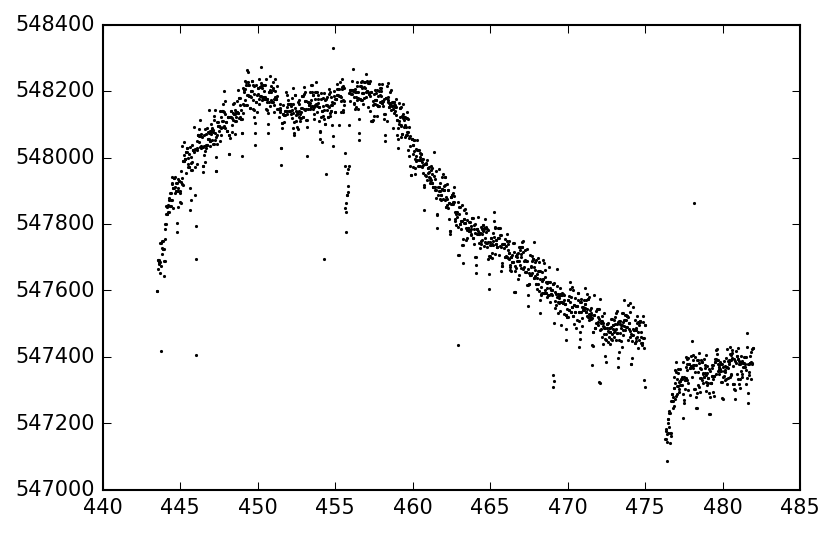

In [73]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)

In [74]:
from lightkurve import LightCurve

 41%|████      | 1840/4492 [01:34<02:16, 19.37it/s]

In [75]:
lc_psf = LightCurve(tpf.time, psf_flux)

In [76]:
lc_aper = tpf.to_lightcurve()

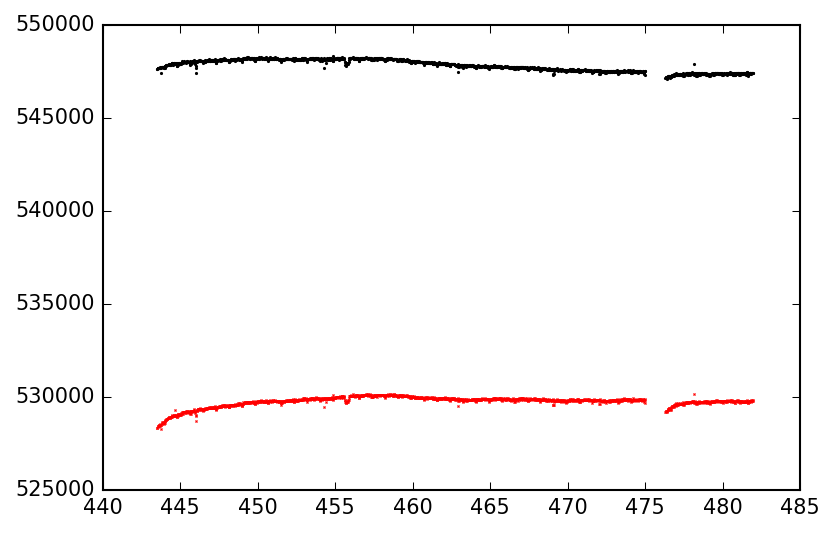

In [78]:
plt.plot(tpf.time, psf_flux, 'ko', markersize=1)
plt.plot(lc_aper.time, lc_aper.flux, 'rx', markersize=1)

In [79]:
lc_aper = lc_aper.flatten().fold(.837495)

In [80]:
lc_psf = lc_psf.flatten().fold(.837495)

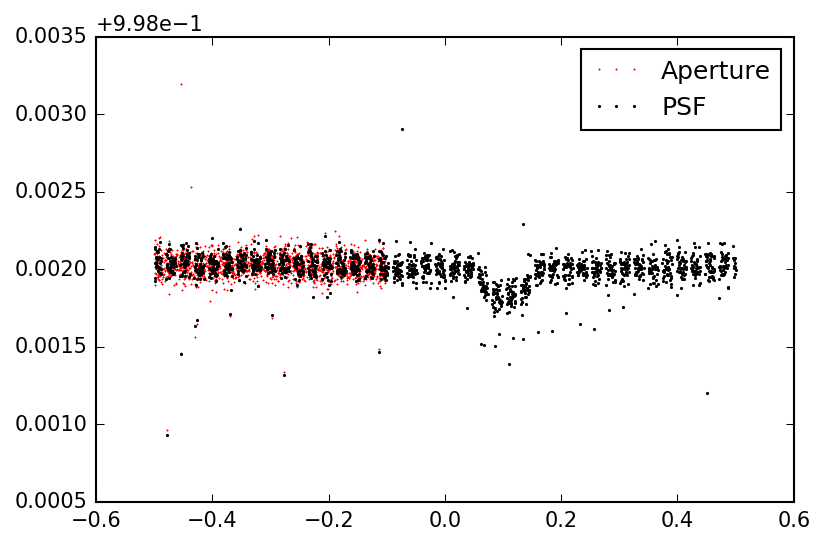

In [82]:
plt.plot(lc_aper.time, lc_aper.flux, 'r+', markersize=1, label='Aperture', alpha=1.0)
plt.plot(lc_psf.time, lc_psf.flux, 'ko', markersize=1, label='PSF', alpha=1.0)
plt.legend(numpoints=3)

In [ ]:
100 * (1 - lc_psf.cdpp() / lc_aper.cdpp())

In [ ]:
lc_psf.cdpp(), lc_aper.cdpp()